# <center><font color='red'>CYTOSKELETON ORGANIZATION EXAMPLES</font></center>

### <center><font color='orange'>AUTHOR: Diogo Vieira</font></center>

-------------------------------------------

### <center><font color='grey'>Imports</font></center>

#### <center><font color='grey'>Libraries</font></center>

In [2]:
# Math, image processing and other useful libraries
from __future__ import print_function, unicode_literals, absolute_import, division
import os

import pandas as pd
import numpy as np
import cv2
from collections import OrderedDict
import copy
import math
import pickle
from matplotlib.ticker import MaxNLocator
from itertools import combinations

# Image processing
from skimage.measure import regionprops
from skimage.filters import meijering, sato, frangi, hessian, threshold_otsu
from skimage.morphology import extrema, skeletonize
from skimage.transform import probabilistic_hough_line
from skimage.draw import disk, circle_perimeter
from scipy.ndimage import gaussian_filter, grey_closing
from scipy.spatial import distance_matrix
from skimage import data, restoration, util
from roipoly import RoiPoly
from matplotlib_scalebar.scalebar import ScaleBar
from biosppy.signals import tools
from biosppy.stats import pearson_correlation
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Plotting
import matplotlib.pyplot as plt
import matplotlib.cm as pltc
import matplotlib.colors as colors
import seaborn as sns

# Widgets
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual
from IPython.display import display

# Feature Extraction (.py files by Teresa Parreira)
# from CytoSkeletonPropsMorph import CytoSkeletonPropsMorph
# from CytoSkeletonRegionPropsInt import RegionPropsInt
# from FreqAnalysis import FreqAnalysis
# from GLCM import GLCM

# Graph
import sknw
import networkx as nx
from scipy.signal import argrelextrema

# 
from skan import Skeleton, summarize,draw
from skan.csr import skeleton_to_csgraph, sholl_analysis,make_degree_image
import scipy as sp
import scipy.sparse
from matplotlib.patches import Circle
from framework.ImageFeatures import ImageFeatures,getvoxelsize
from framework.Functions import cv2toski,pylsdtoski,polar_to_cartesian, remove_not1D, quantitative_analysis,hist_bin,hist_lim,branch,graphAnalysis
from framework.Importing import *
from framework.PreProcessingCYTO import *
#from framework.PreProcessingNUCL import excludeborder, nuclei_preprocessing, df_nuclei_preprocessing, nuclei_segmentation
from framework.Processing import process3Dnuclei,analyze_cell,statistics_from_2D_features,create_separate_DFs
from framework.visualization import *
from framework.analysis import plot_barplot
#from fractal_dimension import fractal_dimension
#from fractal_analysis_fxns import boxcount,boxcount_grayscale,fractal_dimension,fractal_dimension_grayscale,fractal_dimension_grayscale_DBC

print('📚 All libraries successfully imported 📚')

📚 All libraries successfully imported 📚


___

#### <center><font color='grey'>Directories</font></center>

In [3]:
### DATASET #1 (2D)
folder    = os.path.dirname(os.getcwd()) + "\\Datasets\\Set 1-a-tubulin_Sofia"
options   = ["CYTO","NUCL"]
denominator = label_tubulin

### DATASET #2 (3D)
# folder      = os.path.dirname(os.getcwd()) + "\\Datasets\\Set 3D"
# options     = ["CYTO3D","NUCL3D"]
# denominator = label_tubulin3D

### DATASET #3 (Soraia)
# folder      = os.path.dirname(os.getcwd()) + "\\Datasets\\Soraia"
# options     = ["CYTO","NUCL"]
# denominator = label_soraia

### DATASET #4 (Inês)
# folder    = os.path.dirname(os.getcwd()) + "\\Datasets\\Ines"
#options     = []
# denominator  =

### DATASET #4 (SPOCC)
# folder      = os.path.dirname(os.getcwd()) + "\\Datasets\\SPOCC2022"
# options     = ["CYTO"]
# denominator = label_SPOCC

data = init_import(folder,options,denominator)
data['NUCL_PRE'] = pd.read_pickle(folder + "\\NUCL_PRE\\NUCL_PRE.pkl") # pd.read_pickle(os.getcwd() + "\\NUCL_PRE_2D_StarDist.pkl") #
data['CYTO_PRE'] = pd.read_pickle(folder + "\\CYTO_PRE\\CYTO_PRE.pkl") 

ResultsDF = pd.read_pickle(folder + "\\ResultsDF_7_dez_23.pkl")
CentroidsDF = pickle.load(open(folder + '\\Centroids.p', 'rb'))  
#TextureDF = pd.read_pickle("TextureDF_paper.pkl")



>>> [CYTO] added.
>>> [NUCL] added.


#### <font color='grey'>Unfold dataset</font>

In [4]:
SEP  = create_separate_DFs(ResultsDF,options=["FULL"])
data = SEP["FULL"]
data

Name Img Index            Label  \
0     MAX_38_IF6_CHO_L-W5_Z_decon_ch02_PS.tif        38  No transfection   
1     MAX_38_IF6_CHO_L-W5_Z_decon_ch02_PS.tif        38  No transfection   
2     MAX_38_IF6_CHO_L-W5_Z_decon_ch02_PS.tif        38  No transfection   
3     MAX_38_IF6_CHO_L-W5_Z_decon_ch02_PS.tif        38  No transfection   
4     MAX_38_IF6_CHO_L-W5_Z_decon_ch02_PS.tif        38  No transfection   
...                                       ...       ...              ...   
1041  MAX_40_IF6_CHO_L-W6_Z_decon_ch02_PS.tif        40         Del38_46   
1042  MAX_40_IF6_CHO_L-W6_Z_decon_ch02_PS.tif        40         Del38_46   
1043  MAX_40_IF6_CHO_L-W6_Z_decon_ch02_PS.tif        40         Del38_46   
1044  MAX_40_IF6_CHO_L-W6_Z_decon_ch02_PS.tif        40         Del38_46   
1045  MAX_40_IF6_CHO_L-W6_Z_decon_ch02_PS.tif        40         Del38_46   

                                                   Mask  \
0     [[False, False, False, False, False, False, Fa...   
1     [[False, False, False, False, False, False, Fa...   
2     [[False, False, False, False, False, False, Fa...   
3     [[False, False, False, False, False, False, Fa...   
4     [[False, False, False, False, False, False, Fa...   
...                                                 ...   
1041  [[False, False, False, False, False, False, Fa...   
1042  [[False, False, False, False, False, False, Fa...   
1043  [[False, False, False, False, False, False, Fa...   
1044  [[False, False, False, False, False, False, Fa...   
1045  [[False, False, False, False, False, False, Fa...   

                                                Patches    DCF:AAI  \
0     [[[False, False, False, False, False, False, F...  37.931631   
1     [[[False, False, False, False, False, False, F...  45.605331   
2     [[[False, False, False, False, False, False, F...  37.753234   
3     [[[False, True, False, False, False, False, Fa...  49.827183   
4     [[[False, True, True, False, False, False, Fal...  44.742942   
...                                                 ...        ...   
1041  [[[True, False, False, False, False, False, Fa...  39.447532   
1042  [[[False, False, False, False, False, False, F...  46.875071   
1043  [[[False, False, False, False, False, False, F...  43.826114   
1044  [[[False, True, False, False, False, False, Fa...  40.970373   
1045  [[[False, False, False, False, False, False, F...  52.266549   

      DCF:Fractal Dim B  DCF:Fractal Dim D DCF:Area DCF:BB Area  ...  \
0                 1.102             -0.702    10873       47886  ...   
1                 1.211             -0.703    11324       26070  ...   
2                 1.156             -0.628    10809       45968  ...   
3                 1.167             -0.682     9166       25056  ...   
4                 1.209             -0.650    11128       27560  ...   
...                 ...                ...      ...         ...  ...   
1041              1.136             -0.610    10951       23635  ...   
1042              1.104             -0.674     9067       16236  ...   
1043              1.096             -0.770     7429       10541  ...   
1044              1.144             -0.723     8173       17548  ...   
1045              1.193             -0.523     9198       14271  ...   

      OTHERS:Cytoskeleton-Nuclei Centroid Distance  \
0                                        49.774633   
1                                        12.957109   
2                                        45.713312   
3                                        31.785819   
4                                        13.882796   
...                                            ...   
1041                                      9.726985   
1042                                      3.374775   
1043                                      2.047217   
1044                                      1.912660   
1045                                      4.107980   

      OTHERS:Weighted Cytoskeleton-Nuclei Centroid Distance  \
0

#### <font color='grey'>Filter dataset</font>

In [11]:
temp = data.drop(data.loc[data['Label'] == 'No transfection'].index)
temp = temp.drop(temp.loc[temp['Label'] == 'Mock'].index)
temp = temp.drop(temp.loc[temp['Label'] == 'Dup41_46'].index)
temp = temp.drop(temp.loc[temp['Label'] == 'Mut394'].index)

---

View deconvoluted cells with the same image index:

930


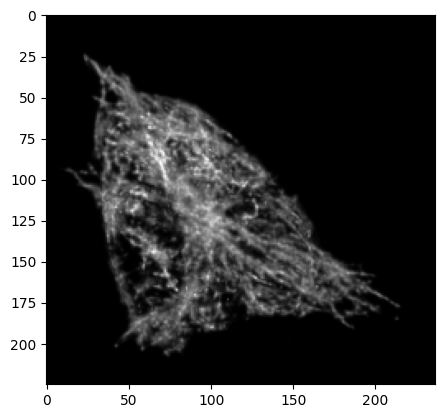

931


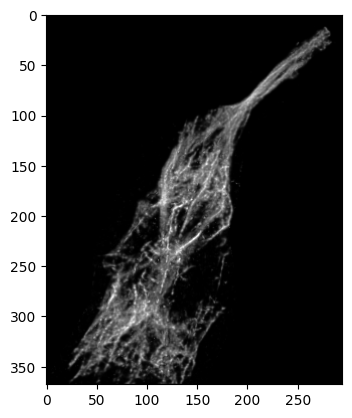

932


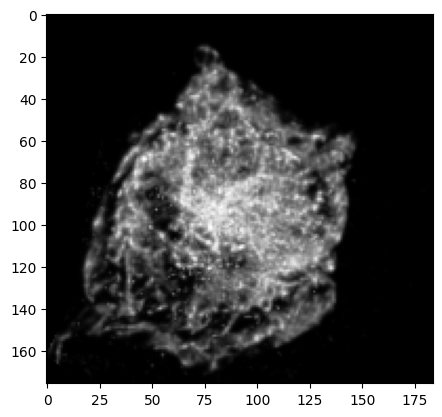

933


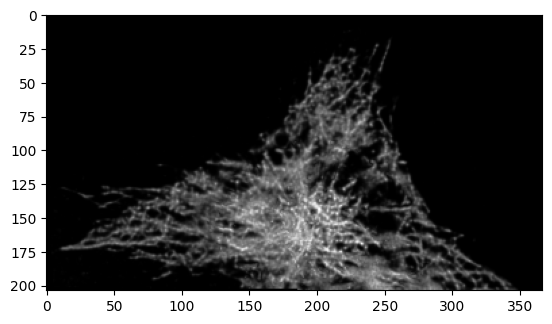

934


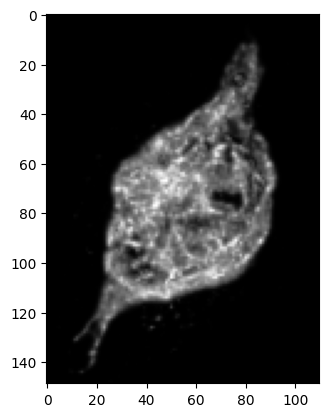

935


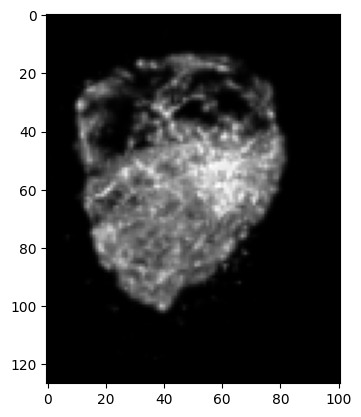

936


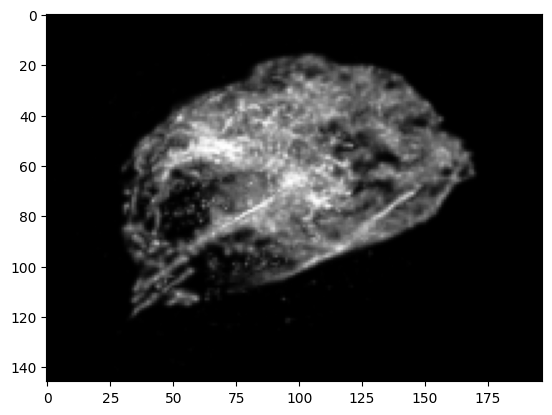

937


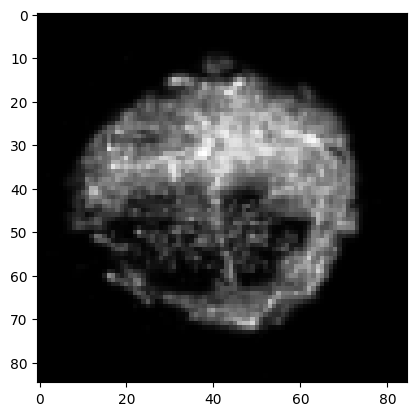

938


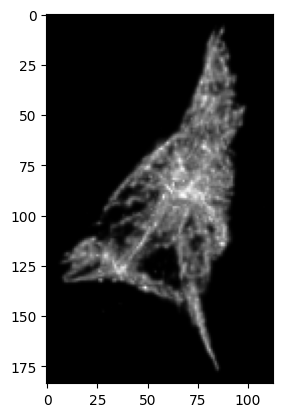

939


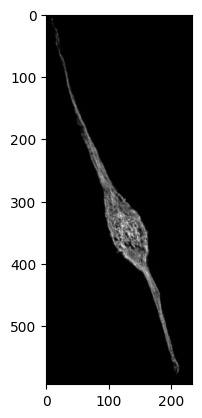

940


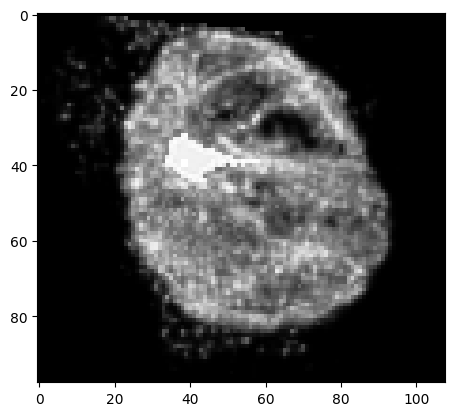

941


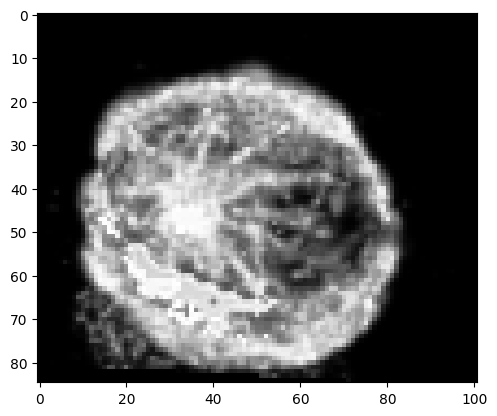

942


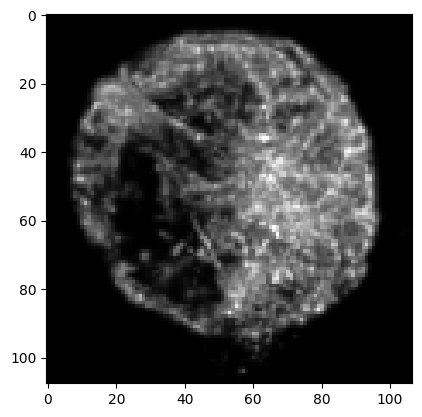

943


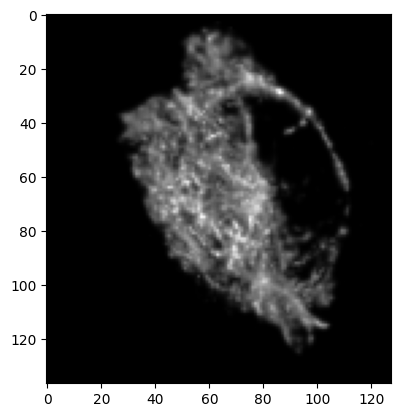

944


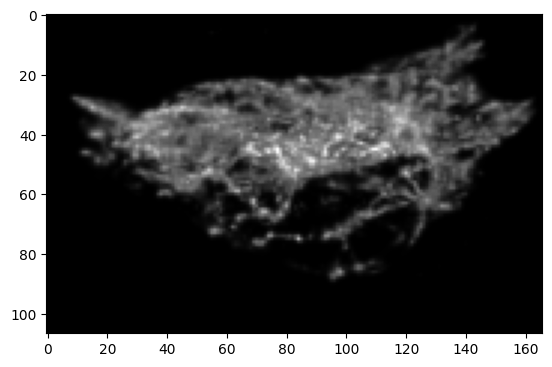

945


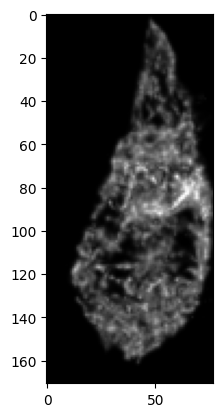

946


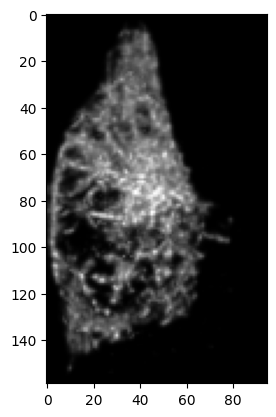

947


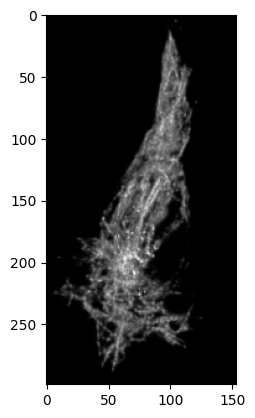

948


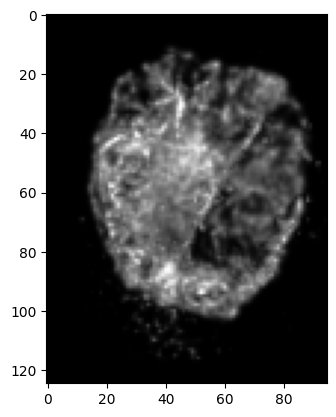

949


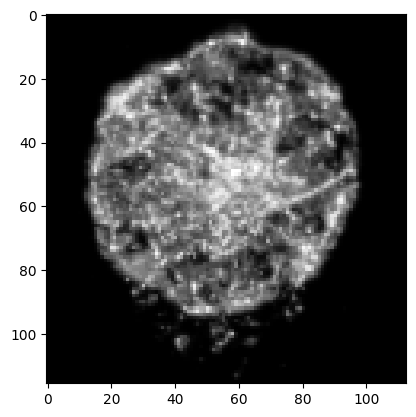

950


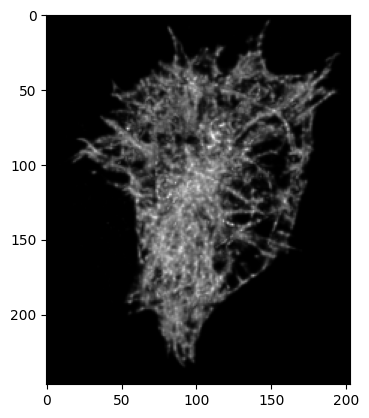

951


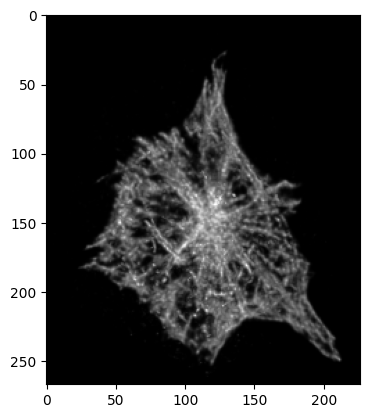

952


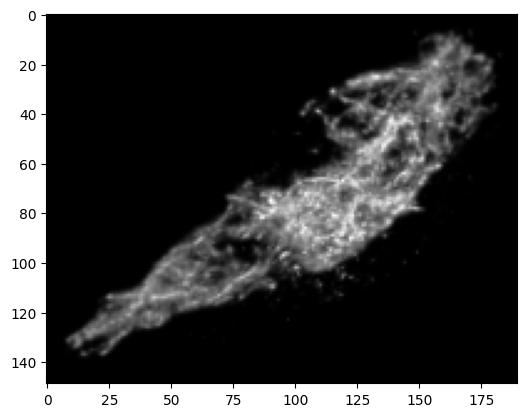

953


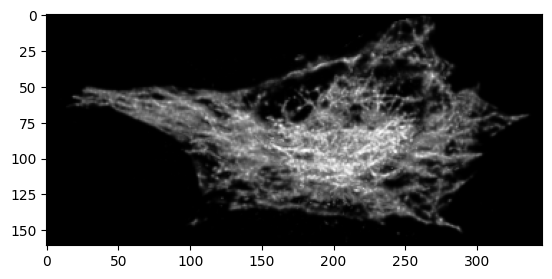

954


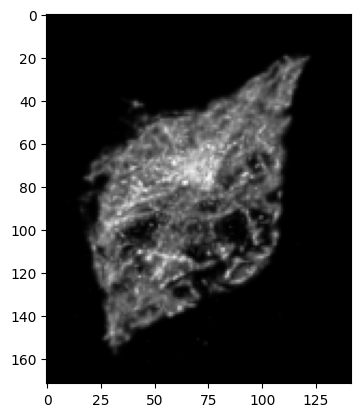

955


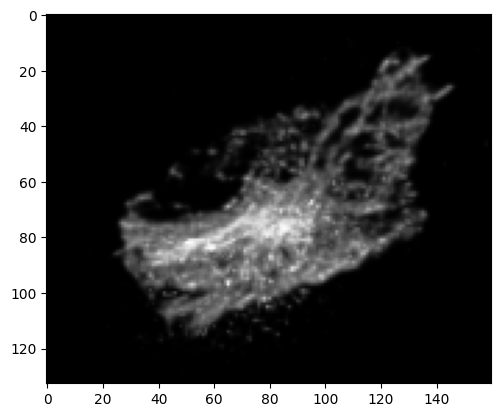

956


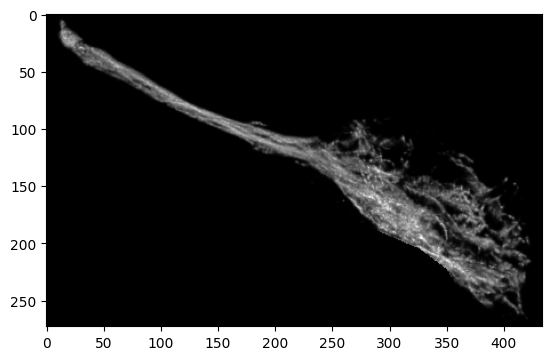

957


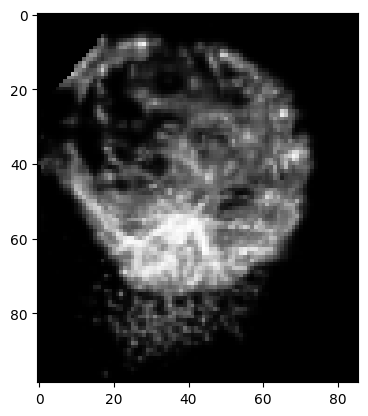

958


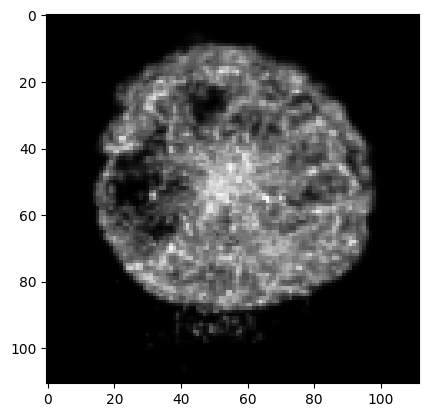

959


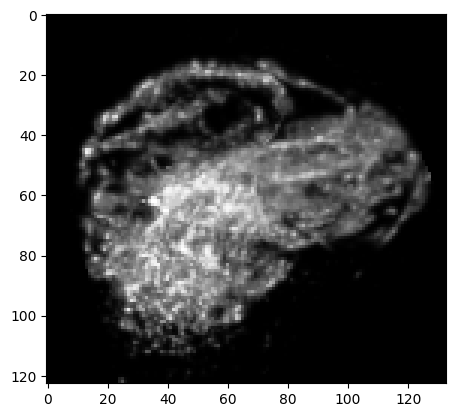

960


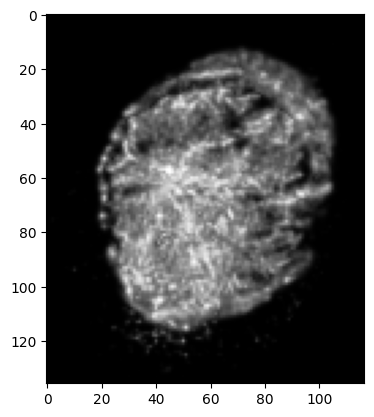

961


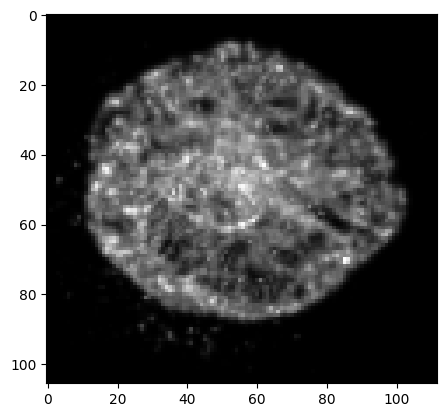

962


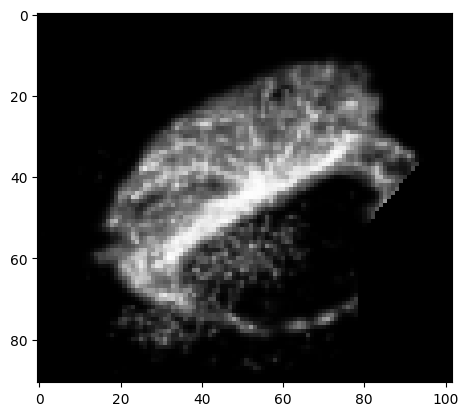

963


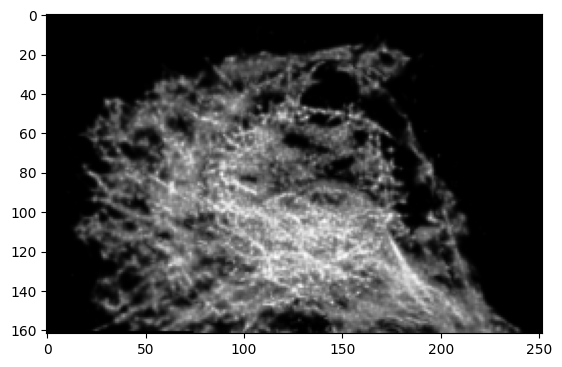

964


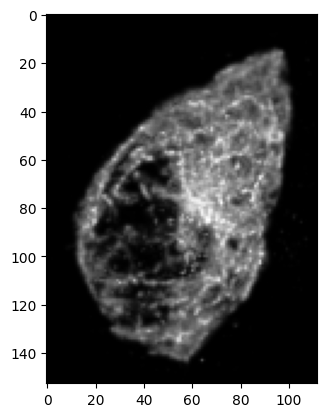

965


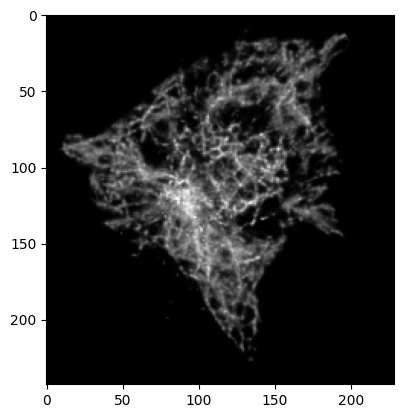

In [11]:
INDEX = 9
dff = data[data['Img Index'] == INDEX]
for index,row in dff.iterrows():
    plt.imshow(row['Patches'][1],cmap='gray')
    print(index)
    plt.show()

---

# <font color='red'>Preprocessing</font>

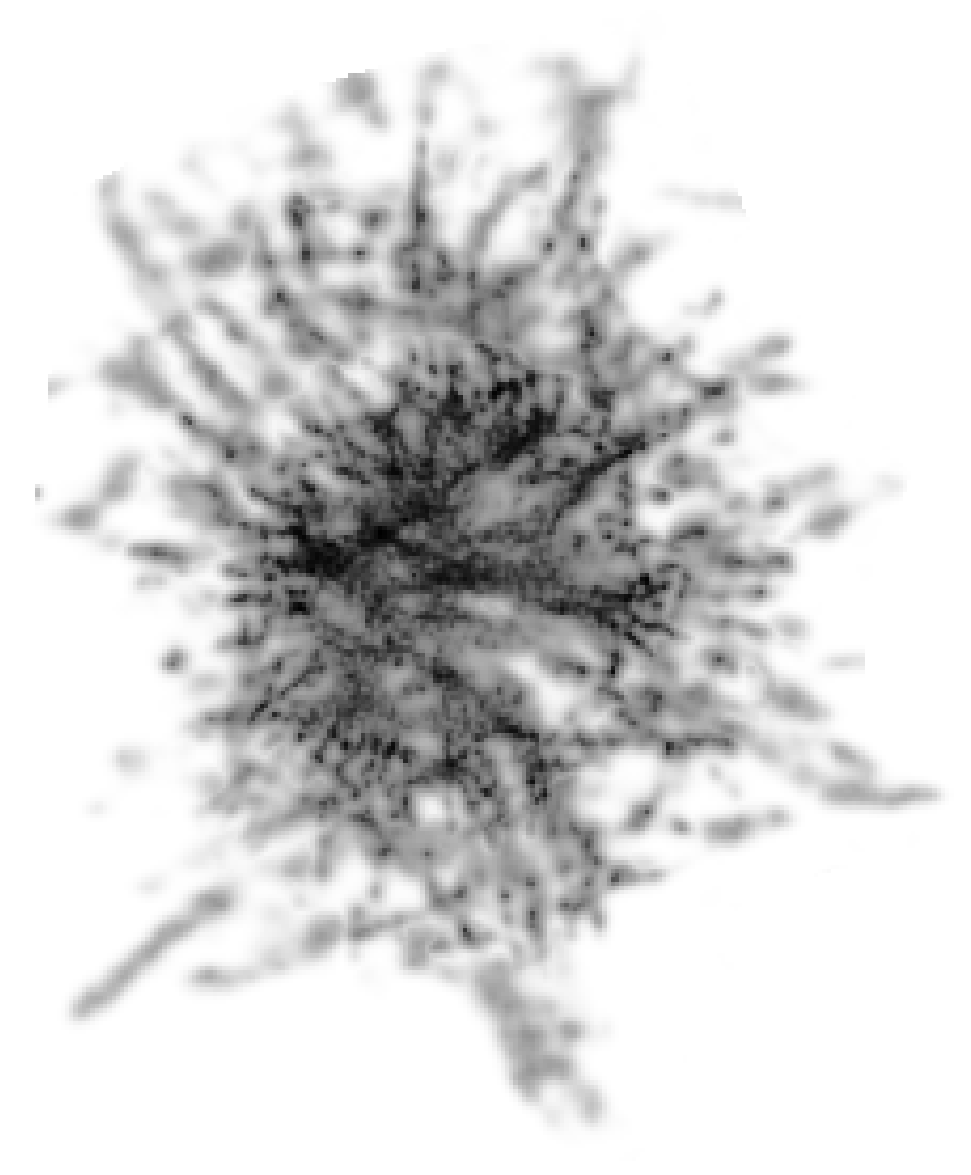

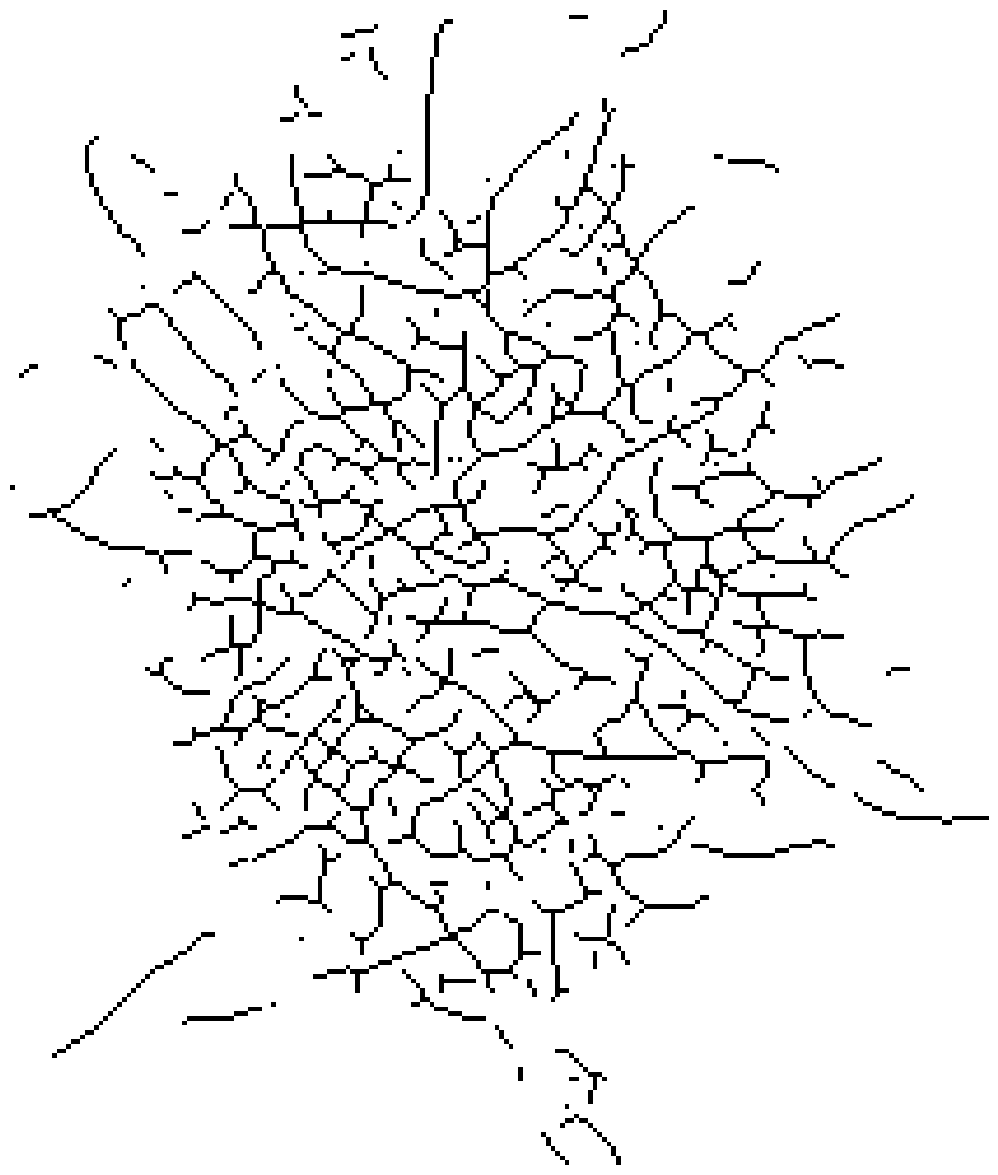

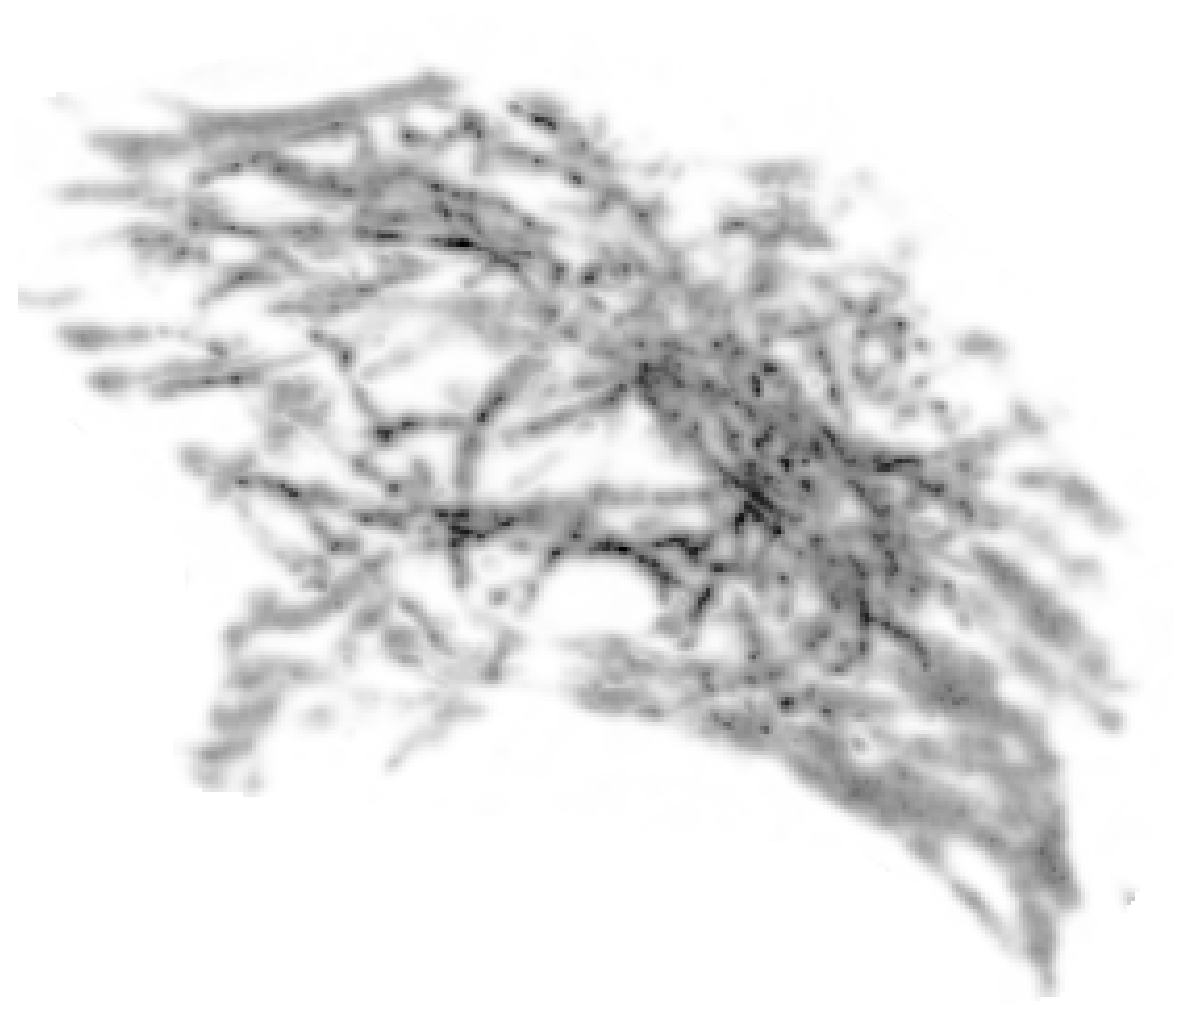

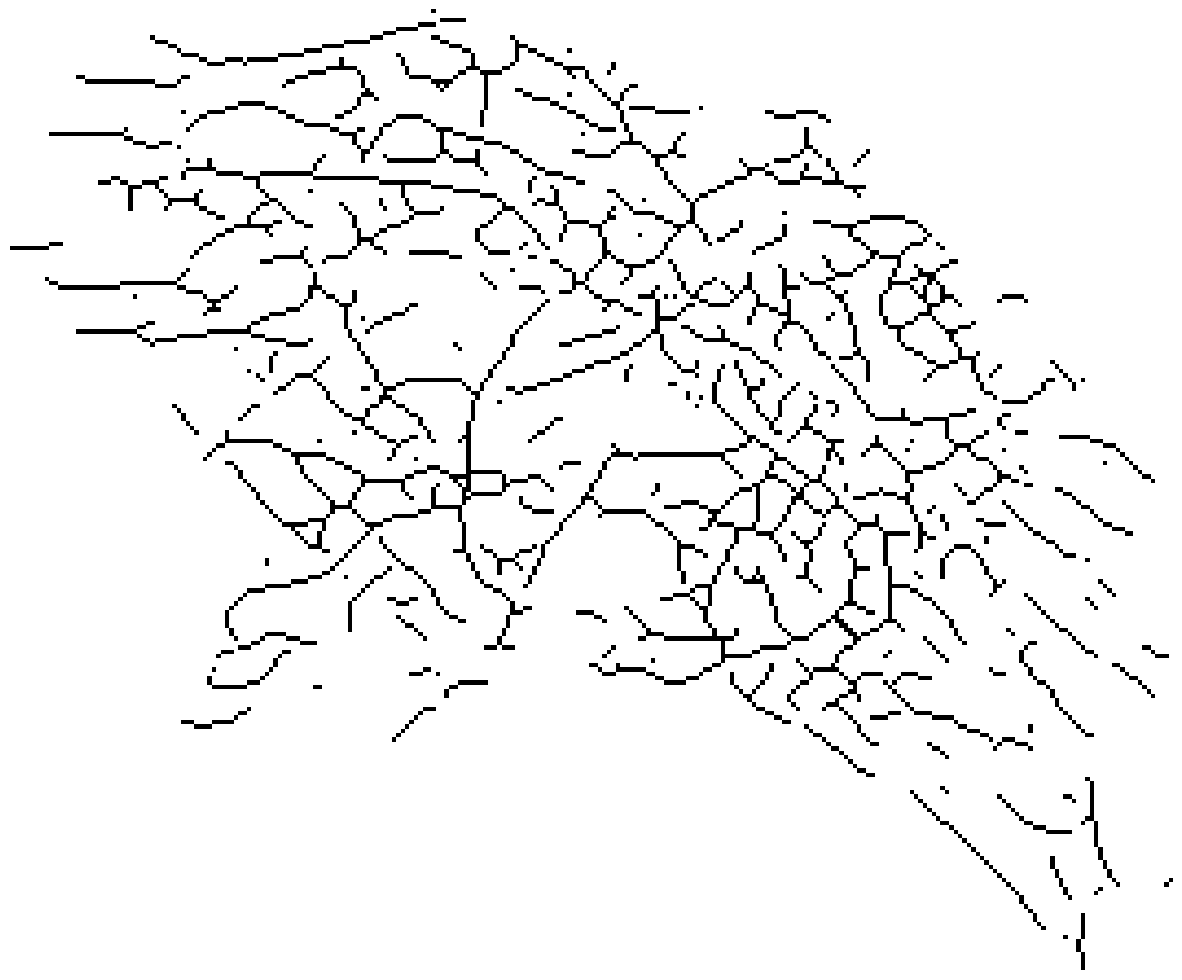

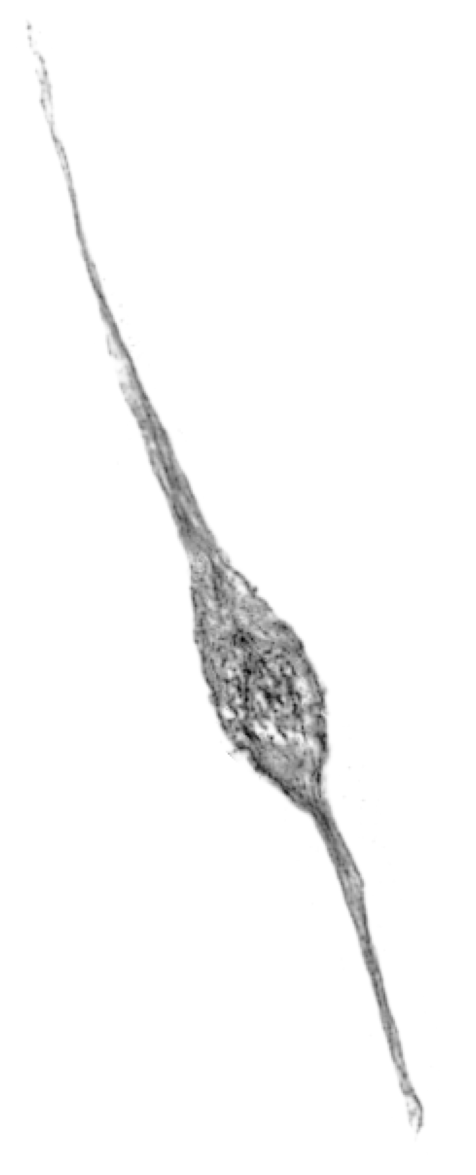

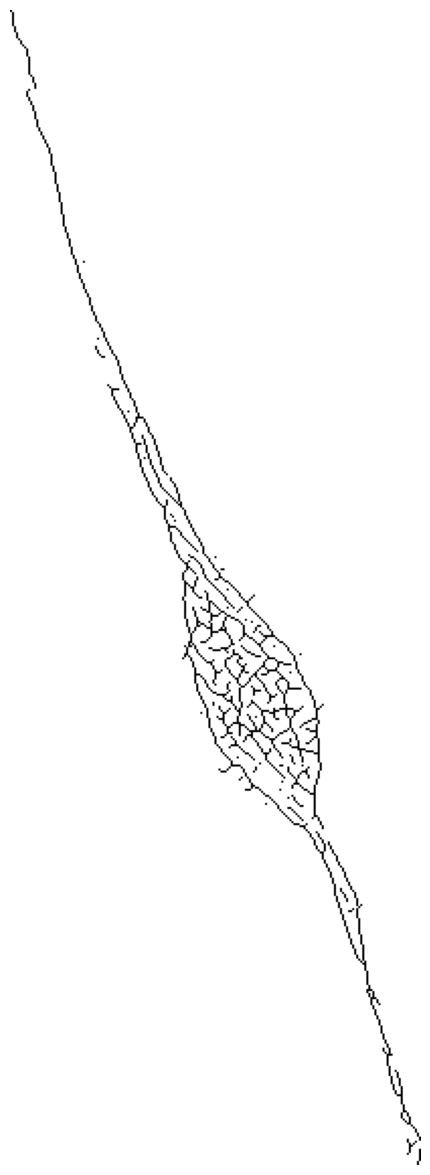

In [13]:
low_mid_high = [data.loc[144],data.loc[145],data.loc[939]]

for i in range(3):
    # Deconv
    fig,ax = plt.subplots(figsize=(15,15))
    plt.imshow(np.max(low_mid_high[i]['Patches'][1]) - low_mid_high[i]['Patches'][1],cmap='gray')
    plt.axis('off')
    #plt.savefig(".//CytoskeletonOrganisationExamples//orientation_deconv" + str(i) + ".png",format='png',transparent=True,bbox_inches='tight',dpi=500)
    plt.show()
    
    # Skel
    fig,ax = plt.subplots(figsize=(15,15))
    plt.imshow(1-low_mid_high[i]['Patches'][0],cmap='gray')
    plt.axis('off')
    #scalebar = ScaleBar(1,"um",color='k',box_alpha=0,dimension='si-length') 
    #ax.add_artist(scalebar)
    #plt.savefig(".//CytoskeletonOrganisationExamples//orientation_skel" + str(i) + ".png",format='png',transparent=True,bbox_inches='tight',dpi=500)
        
    plt.show()
    
df = pd.concat(low_mid_high,axis=1).transpose()

In [32]:
def preprocessver(ResultsRow):
    image = DeconvDF.loc[ResultsRow['Img Index']]['Image']
    #image = ResultsRow['Patches'][1]
    ini = image / np.max(image)
    gau = gaussian_filter(ini, sigma=1)
    s = sato(gau,black_ridges=False,sigmas=[1],mode='reflect') 
    h = hessian(s,black_ridges=False,sigmas=[0.006],mode='reflect') 
    texture = ((1 - h)!=0)*1
    skeleton = skeletonize(texture)
    
    ch2 = ResultsRow['Mask']*OriginalDF['Image'][ResultsRow['Img Index']][:,:,2]
    ch1 = ResultsRow['Mask']*OriginalDF['Image'][ResultsRow['Img Index']][:,:,1]
    sl_i = slice(min(ResultsRow['Patches'][4]), max(ResultsRow['Patches'][4]))
    sl_j = slice(min(ResultsRow['Patches'][5]), max(ResultsRow['Patches'][5]))
    ch2 = ch2[sl_i, sl_j]
    ch1 = ch1[sl_i, sl_j]
    
    
    tempi = ini
    RED = np.stack([tempi,np.zeros_like(tempi),np.zeros_like(tempi)],axis=2)
#     test3 = np.stack([skeleton*255,ch2,ch1],axis=2)
    #test3 = np.stack([1.3*(ch2 / np.max(ch2)),1.5*skeleton*(ch2 / np.max(ch2)), 0.4 * (ch1 / np.max(ch1))],axis=2)

#     fig,ax = plt.subplots(figsize=(15,15))
#     #plt.title('original');              
#     #ax.set_ylim([min(ResultsRow['Patches'][4]),max(ResultsRow['Patches'][4])])
#     #ax.set_xlim([min(ResultsRow['Patches'][5]),max(ResultsRow['Patches'][5])])
#     ax.imshow(np.max(ini) - ini,cmap='gray'); 
#     plt.axis('off')
#     plt.savefig(".//CytoskeletonOrganisationExamples//Preprocessing//l_1original.png",format='png',transparent=True,bbox_inches='tight',dpi=500)
#     plt.show()
    
#     fig,ax = plt.subplots(figsize=(15,15))
#     #plt.title('gaussian');    
#     plt.axis('off')
#     plt.imshow(gau,cmap='gray');
#     plt.savefig(".//output_g.png",format='png',transparent=True,bbox_inches='tight',dpi=500)
#     plt.show()
    
#     fig,ax = plt.subplots(figsize=(15,15))
#     #plt.title('sato');                  
#     plt.imshow(s,cmap='gray');
#     plt.axis('off')
#     plt.savefig(".//output.png",format='png',transparent=True,bbox_inches='tight',dpi=500)
#     plt.show()
    
#     fig,ax = plt.subplots(figsize=(15,15)) 
#     #plt.title('hessian');               
#     plt.imshow(texture,cmap='gray');
#     plt.axis('off')
#     plt.savefig(".//output_h.png",format='png',transparent=True,bbox_inches='tight',dpi=500)
#     plt.show()

#     fig,ax = plt.subplots(figsize=(15,15))
#     #plt.title('skeleton');              
#     plt.imshow(skeleton,cmap='gray');
#     plt.axis('off')
#     plt.savefig(".//output_sk.png",format='png',transparent=True,bbox_inches='tight',dpi=500)
#     plt.show()
    
    
    fig,ax = plt.subplots(figsize=(15,15)) 
    #plt.title('all');
    tempi = ini * ResultsRow['Mask']
    test3 = np.stack([tempi,1.3*skeleton*tempi,np.zeros_like(tempi)],axis=2)
    #test3 = np.stack([tempi,np.zeros_like(tempi),np.zeros_like(tempi)],axis=2)
    
    plt.imshow(test3);
    ax.set_ylim([min(ResultsRow['Patches'][4]),max(ResultsRow['Patches'][4])])
    ax.set_xlim([min(ResultsRow['Patches'][5]),max(ResultsRow['Patches'][5])])
    plt.axis('off')
    ax.plot(ResultsRow['Nucleus Centroid'][1],ResultsRow['Nucleus Centroid'][0],'o',color='#6495ED',markersize=12,zorder=8)
    ax.plot(ResultsRow['Nucleus Contour'][:,0],ResultsRow['Nucleus Contour'][:,1],'--',color='#6495ED',zorder=11,linewidth=2.5)
    scalebar = ScaleBar(1,"um",color='w',box_alpha=0,dimension='si-length',location='upper right') 
    ax.add_artist(scalebar)
    #plt.savefig(".//CytoskeletonOrganisationExamples//Preprocessing//7final_.png",format='png',transparent=True,bbox_inches='tight',dpi=500)
    plt.show()

preprocessver(data.loc[0])

IndexError: list index out of range

# <font color='red'>Fiber Orientation</font>

##### <font color='red'>Sort by desired feature, choose cells and get new dataset</font>

In [17]:
temp = data.sort_values(by=['LSF1D:OOP'])

Del38_46 315


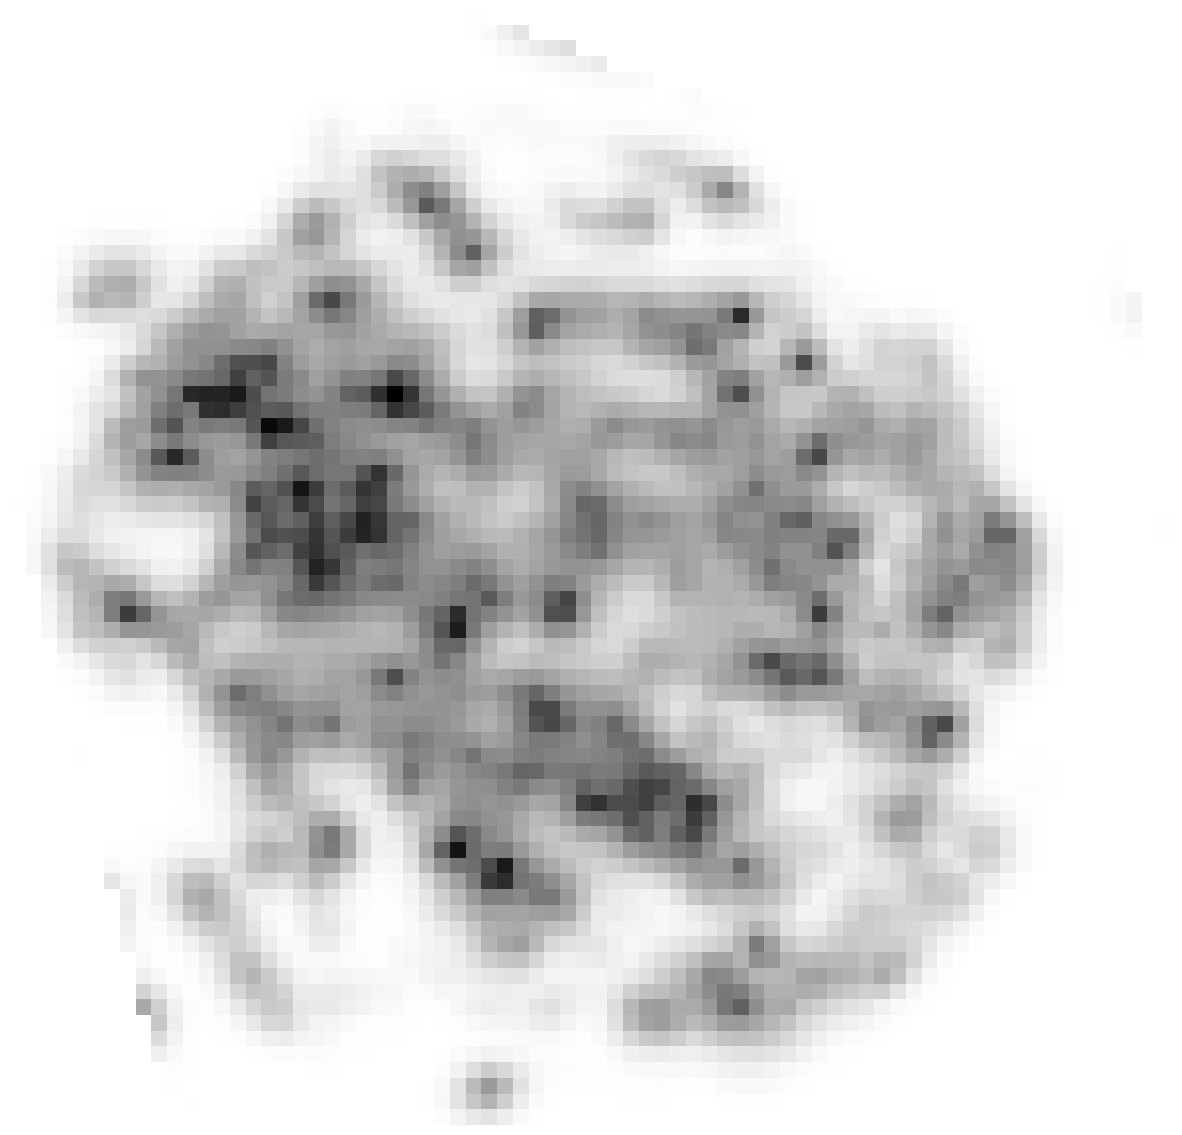

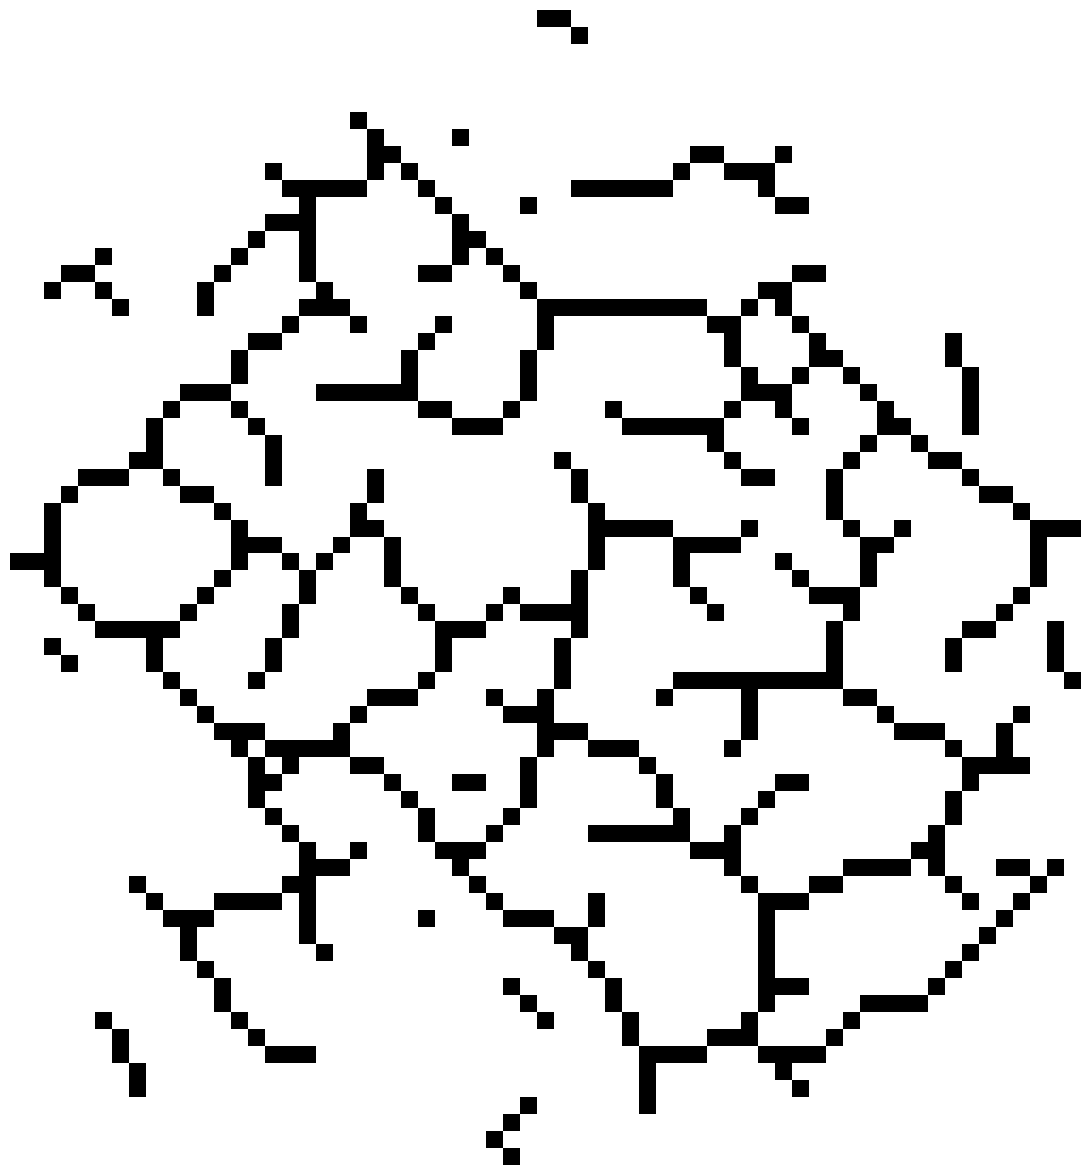

WT 471


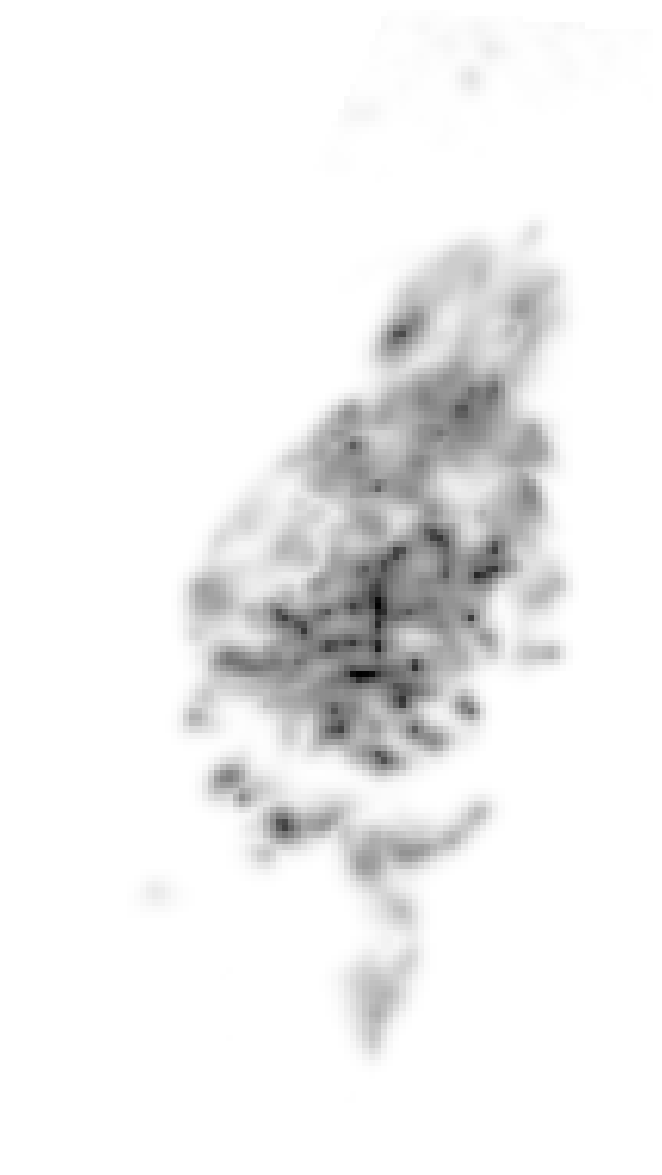

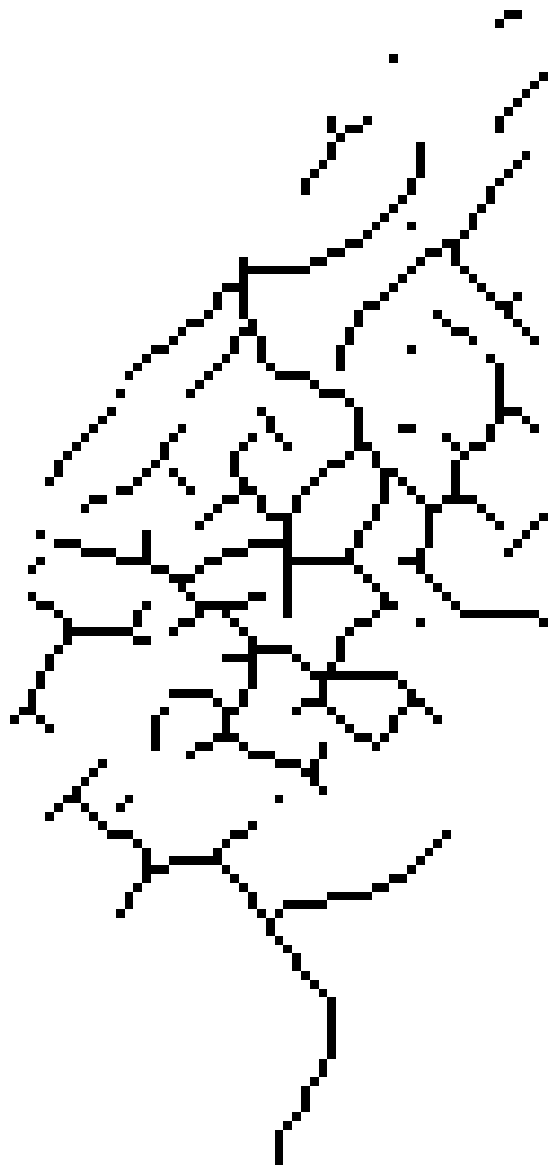

Del38_46 30


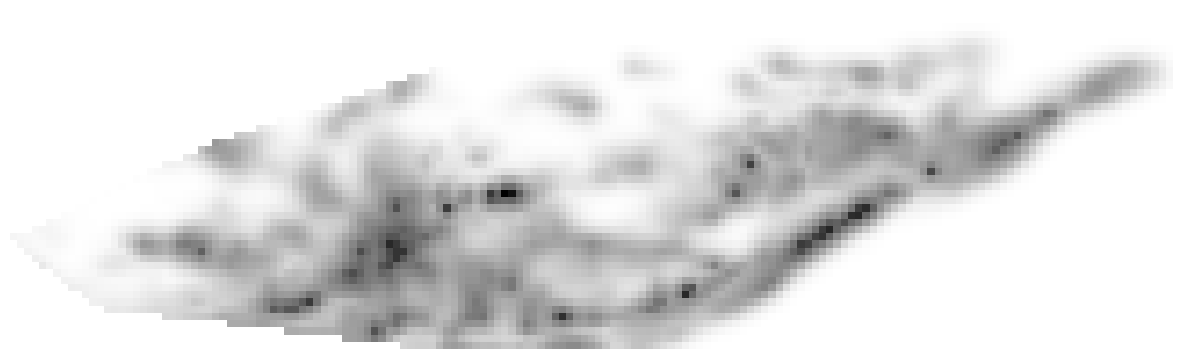

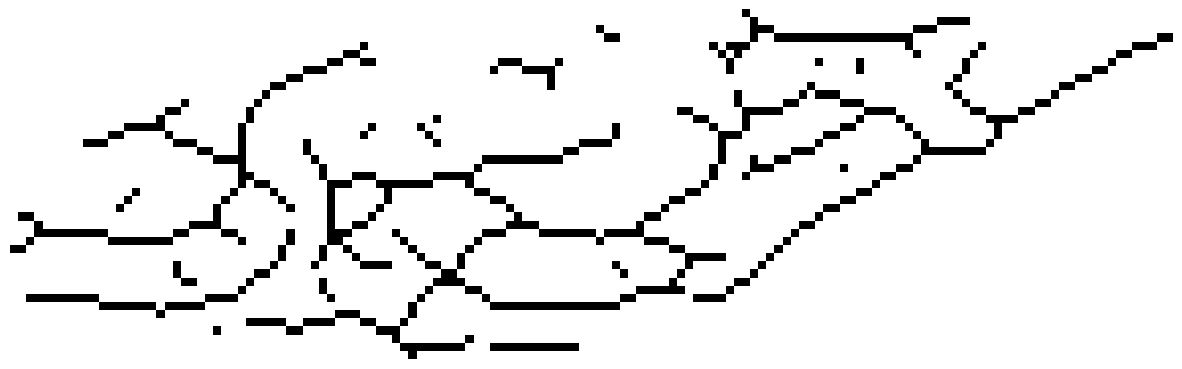

In [20]:
#low_mid_high = [data.loc[541],data.loc[1030],data.loc[622]] # PREV
#low_mid_high = [data.loc[864],data.loc[1030],data.loc[786]]
low_mid_high = [data.loc[315],data.loc[471],data.loc[30]] # PREV

for i in range(3):
    # Label & Value
    print(low_mid_high[i]['Label'],low_mid_high[i].name)
    
    # Deconv
    fig,ax = plt.subplots(figsize=(15,15))
    plt.imshow(np.max(low_mid_high[i]['Patches'][1]) - low_mid_high[i]['Patches'][1],cmap='gray')
    plt.axis('off')
    #plt.savefig(".//CytoskeletonOrganisationExamples//orientation_deconv" + str(i) + ".png",format='png',transparent=True,bbox_inches='tight',dpi=500)
    plt.show()
    
    # Skel
    fig,ax = plt.subplots(figsize=(15,15))
    plt.imshow(1-low_mid_high[i]['Patches'][0],cmap='gray')
    plt.axis('off')
    #scalebar = ScaleBar(1,"um",color='k',box_alpha=0,dimension='si-length') 
    #ax.add_artist(scalebar)
    #plt.savefig(".//CytoskeletonOrganisationExamples//orientation_skel" + str(i) + ".png",format='png',transparent=True,bbox_inches='tight',dpi=500)
        
    plt.show()
    
df = pd.concat(low_mid_high,axis=1).transpose()

# <font color='red'>Fiber Bundling</font>

##### <font color='red'>Sort by desired feature, choose cells and get new dataset</font>

In [6]:
temp = data.sort_values(by=['DCF:Skewness'])

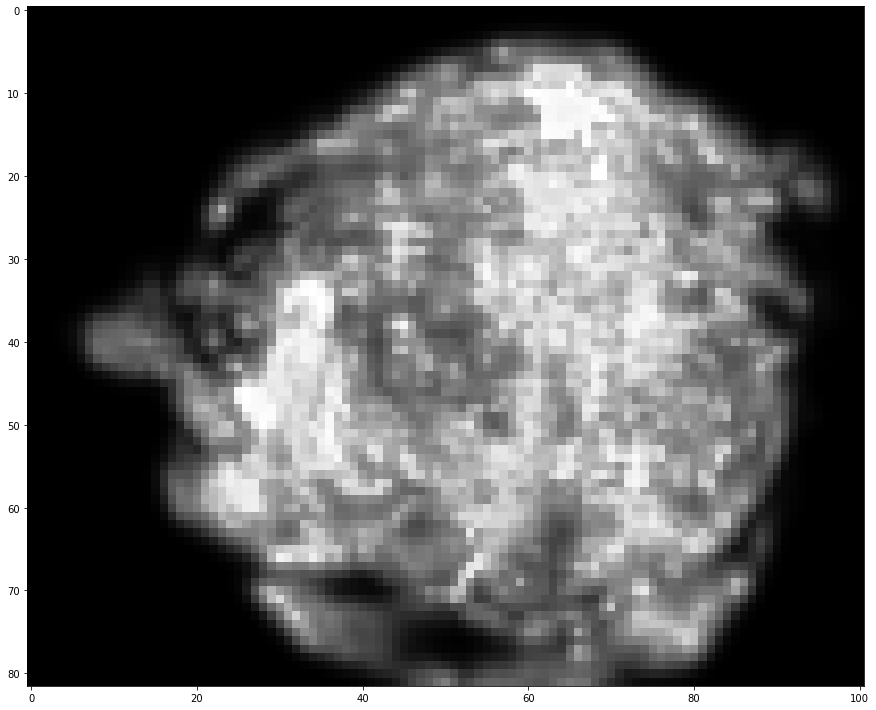

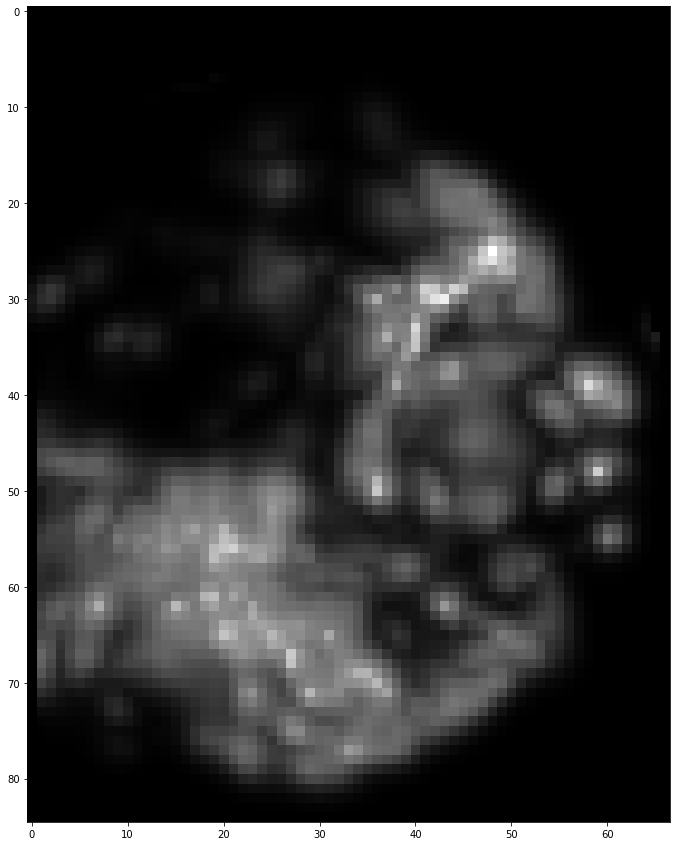

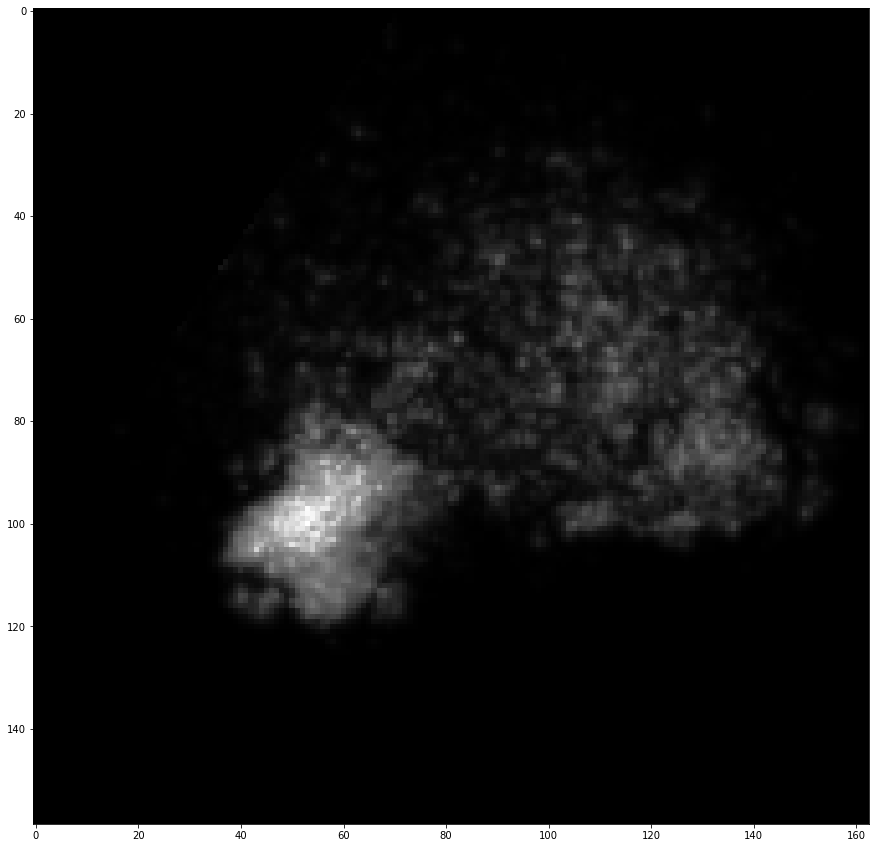

In [59]:
low_mid_high = [temp.loc[temp.index[0]],temp.loc[temp.index[int(len(temp)/2)]],temp.loc[temp.index[-2]]]

for i in range(3):
    plt.figure(figsize=(15,15))
    plt.imshow(low_mid_high[i]['Patches'][1],cmap='gray')
    plt.show()
    
df = pd.concat(low_mid_high,axis=1).transpose()

# <font color='red'>Fiber Complexity</font>

##### <font color='red'>Sort by desired feature, choose cells and get new dataset</font>

In [22]:
temp = ResultsDF.sort_values(by='CNF1D:Fractal Dimension')

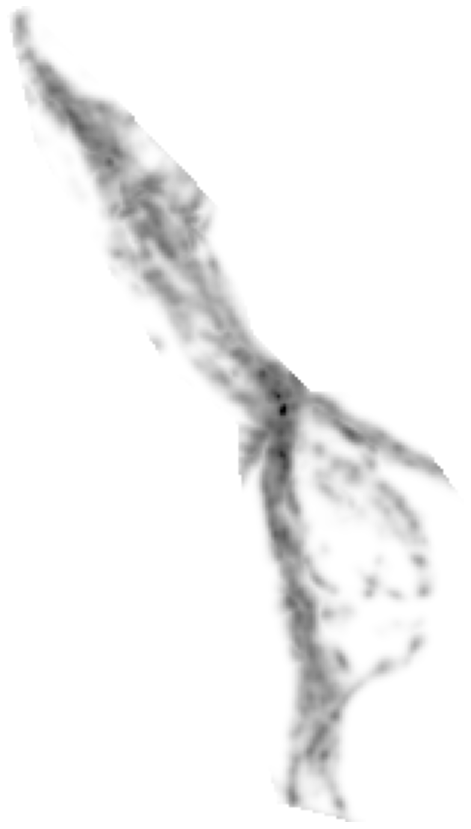

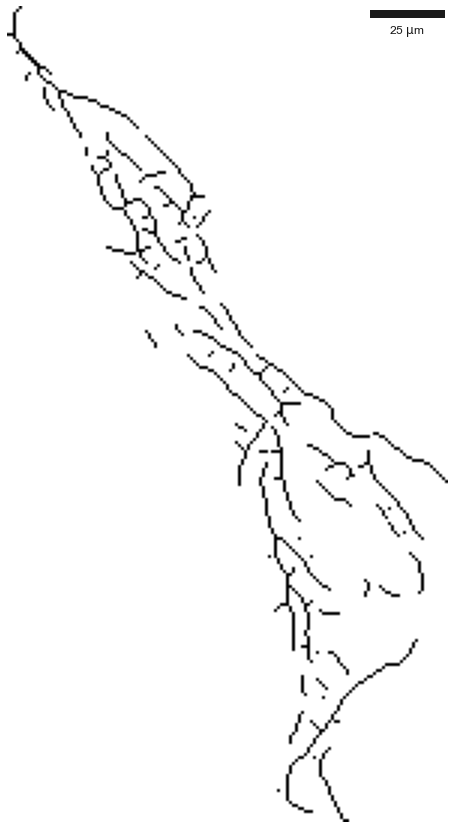

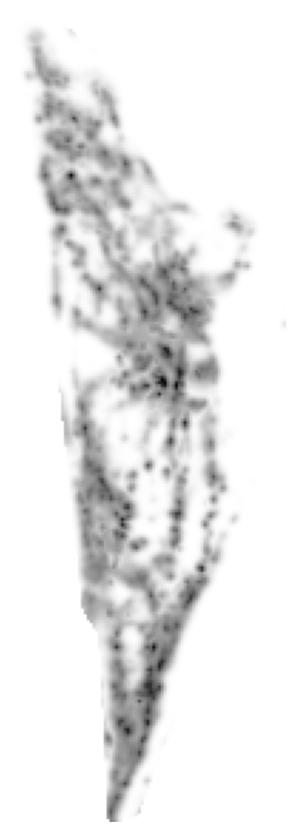

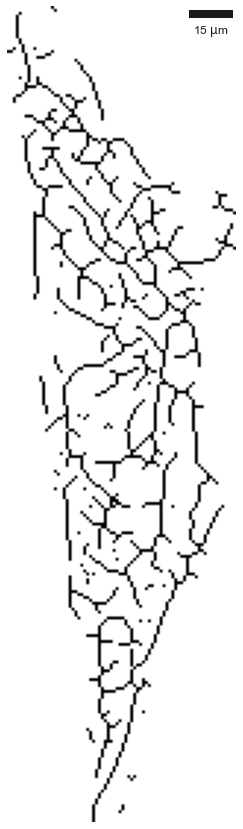

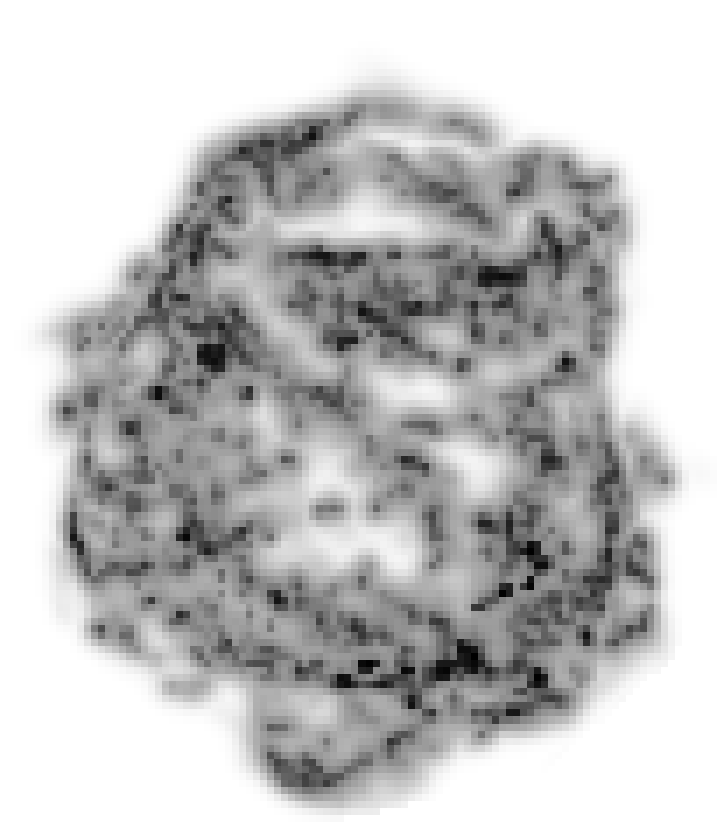

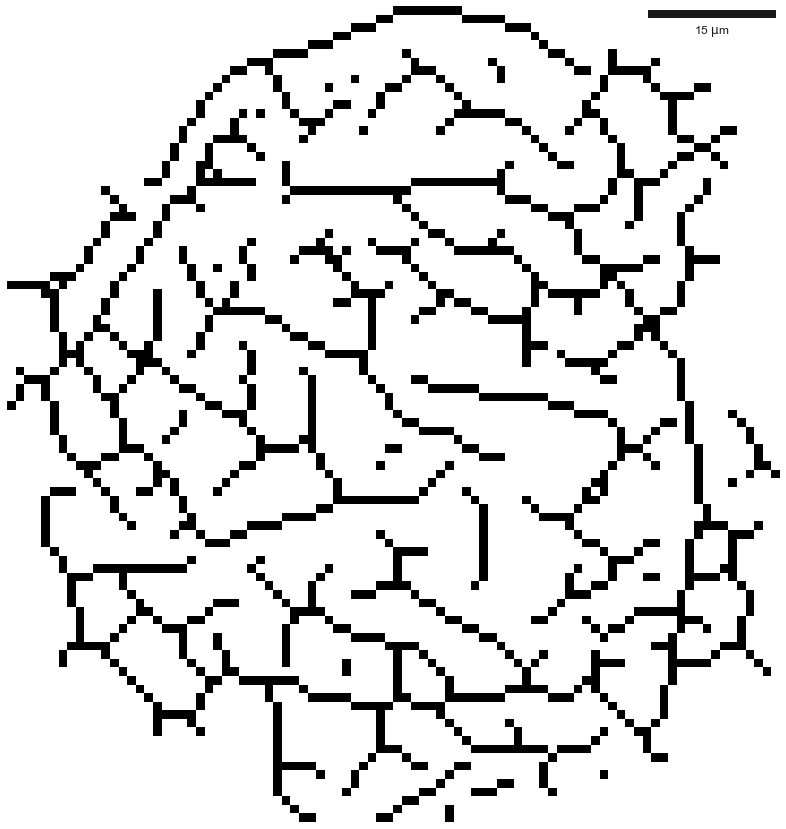

In [216]:
low_mid_high = [temp.loc[temp.index[12]],temp.loc[temp.index[2+int(len(temp)/2)]],temp.loc[temp.index[-1]]]

for i in range(3):
    # Deconv
    fig,ax = plt.subplots(figsize=(15,15))
    plt.imshow(np.max(low_mid_high[i]['Patches'][1]) - low_mid_high[i]['Patches'][1],cmap='gray')
    plt.axis('off')
    #plt.savefig(".//CytoskeletonOrganisationExamples//complexity_deconv" + str(i) + ".png",format='png',transparent=True,bbox_inches='tight',dpi=500)
    plt.show()
    
    # Skel
    fig,ax = plt.subplots(figsize=(15,15))
    plt.imshow(1-low_mid_high[i]['Patches'][0],cmap='gray')
    plt.axis('off')
    scalebar = ScaleBar(1,"um",color='k',box_alpha=0,dimension='si-length') 
    ax.add_artist(scalebar)
    #plt.savefig(".//CytoskeletonOrganisationExamples//complexity_skel" + str(i) + ".png",format='png',transparent=True,bbox_inches='tight',dpi=500)
        
    plt.show()
    
df = pd.concat(low_mid_high,axis=1).transpose()

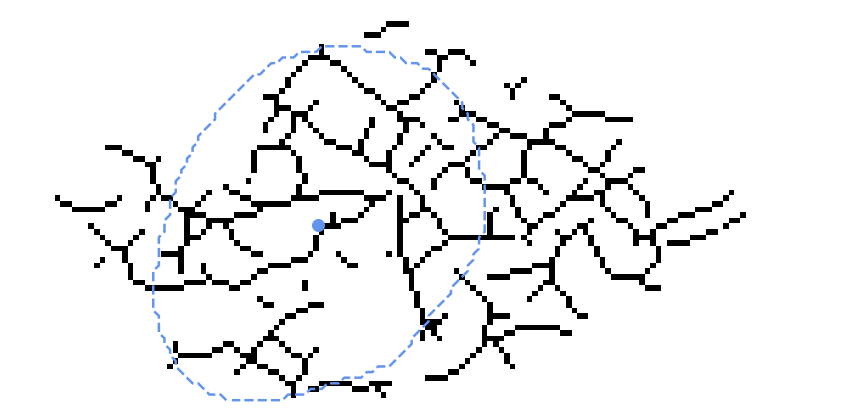

In [266]:
#plt.imshow(ResultsDF.loc[0]['Patches'][0]
ResultsRow = subResultsDF.loc[0]
sk = ResultsRow['Patches'][0]
nuc = ResultsRow['Patches'][2]
props    = regionprops((nuc!=0)*1,nuc)

orientation = props[0].orientation
skrot = rotate(sk,90-orientation*180/np.pi,resize=True)
fig,ax=plt.subplots(figsize=(15,15))
#ax.imshow(np.zeros((1040, 1388)),cmap='gray',alpha=0)
#plt.imshow(1-skrot,cmap='gray',zorder=2)
y0, x0 = props[0].centroid
x1 = x0 + math.cos(orientation) * 0.5 * props[0].axis_minor_length
y1 = y0 - math.sin(orientation) * 0.5 * props[0].axis_minor_length
x2 = x0 - math.sin(orientation) * 0.5 * props[0].axis_major_length
y2 = y0 - math.cos(orientation) * 0.5 * props[0].axis_major_length
#ax.plot(x0, y0, '.g', markersize=15,zorder=8)

ax.imshow(1- ResultsRow['Mask']*TextureDF['Skeleton'][row['Img Index']],cmap='gray',zorder=1)
#ax.imshow(1-)
ax.plot(ResultsRow['Nucleus Centroid'][1],ResultsRow['Nucleus Centroid'][0],'o',color='#6495ED',markersize=12,zorder=8)
ax.plot(ResultsRow['Nucleus Contour'][:,0],ResultsRow['Nucleus Contour'][:,1],'--',color='#6495ED',zorder=11,linewidth=2.5)
      
ax.set_ylim([min(ResultsRow['Patches'][4]),max(ResultsRow['Patches'][4])])
ax.set_xlim([min(ResultsRow['Patches'][5]),max(ResultsRow['Patches'][5])])

#ax.plot(min(ResultsRow['Patches'][4])-ResultsRow['Nucleus Centroid'][1],min(ResultsRow['Patches'][4])-ResultsRow['Nucleus Centroid'][0],'o',color='#6495ED',markersize=12,zorder=8)
#ax.plot(min(ResultsRow['Patches'][4])-ResultsRow['Nucleus Contour'][:,0],min(ResultsRow['Patches'][5])-ResultsRow['Nucleus Contour'][:,1],'--',color='#6495ED',zorder=11,linewidth=2.5)
#ax.set_ylim([min(ResultsRow['Patches'][4]),max(ResultsRow['Patches'][4])])
#ax.set_xlim([min(ResultsRow['Patches'][5]),max(ResultsRow['Patches'][5])])         

# #ax.plot(y0, y1, 'r', linewidth=5,zorder=5)
# ax.plot((x0, x1),(y0, y1), 'r', linewidth=5,zorder=5)
# ax.plot((x0, x1),(y0, y1), 'r', linewidth=5,zorder=5)
# ax.plot((x0, x2), (y0, y2), '-r', linewidth=5,zorder=6)
plt.axis('off')
plt.savefig(".//CytoskeletonOrganisationExamples//complexity_nuc" + str(i) + ".png",format='png',transparent=True,bbox_inches='tight',dpi=500)
plt.show()

In [34]:
# FRACTAL DIMENSION LAST ?

def FractalDimensionROT7(data):
    "Get fractal dimension from skeletons, from row['Patches']"
    
    from framework.ImageFeatures import fractal_dimension
    from skimage.transform import rotate
    i = 0
    res = []
    for index,row in data.iterrows():
        sk = row['Patches'][0]
        nuc = row['Patches'][2]
        #dv = row['Patches'][1]
        props    = regionprops((nuc!=0)*1,nuc)
        orientation = props[0].orientation
        skrot = rotate(sk,90-orientation*180/np.pi,resize=True)
        act = []

        for ang in np.arange(0,90,15):
            # Get cell major axis
            #props    = regionprops((dv!=0)*1,dv)
            rot = rotate(skrot,ang,resize=True)
            act += [fractal_dimension(1-rot)]

        res += [np.mean(act)]
        print(100*i/len(data))
        i = i + 1
        
    return res

# OU SERÁ ??:
# from fractal_dimension import fractal_dimension
# from skimage.transform import rotate
# i = 0
# res = []
# for index,row in ResultsDF.iterrows():
#     sk = row['Patches'][0]
#     #dv = row['Patches'][1]
#     act = []
    
#     for ang in np.arange(0,360,10):
#         # Get cell major axis
#         #props    = regionprops((dv!=0)*1,dv)
#         rot = rotate(sk,ang,resize=True)
#         act += [fractal_dimension(rot,threshold=1)]
    
#     print(100*i/len(ResultsDF))
#     i += 1
#     res += [np.mean(act)]

# OU SERÁ??:

# from fractal_dimension import fractal_dimension
# from skimage.transform import rotate
# i = 0
# res = []
# for index,row in ResultsDF.iterrows():
#     sk = row['Patches'][0]
#     #dv = row['Patches'][1]
#     act = []
    
#     for ang in np.arange(0,360,10):
#         # Get cell major axis
#         #props    = regionprops((dv!=0)*1,dv)
#         rot = rotate(sk,ang,resize=True)
#         act += [fractal_dimension(rot,threshold=1)]
    
#     print(100*i/len(ResultsDF))
#     i += 1
#     res += [np.mean(act)]

# data['DCF:Fractal Dimension New'] = res 

# OU SERÁ:
# from framework.ImageFeatures import fractal_dimension
# from skimage.transform import rotate
# i = 0
# res = []
# for index,row in ResultsDF.iterrows():
#     sk = row['Patches'][0]
#     nuc = row['Patches'][2]
#     #dv = row['Patches'][1]
#     props    = regionprops((nuc!=0)*1,nuc)
#     orientation = props[0].orientation
#     skrot = rotate(sk,90-orientation*180/np.pi,resize=True)
#     act = []
    
#     for ang in np.arange(0,90,15):
#         # Get cell major axis
#         #props    = regionprops((dv!=0)*1,dv)
#         rot = rotate(skrot,ang,resize=True)
#         act += [fractal_dimension(1-rot)]

#     res += [np.mean(act)]
#     print(100*i/len(ResultsDF))
#     i = i + 1

# OU SERA
# from framework.ImageFeatures import fractal_dimension
# from skimage.transform import rotate
# i = 0
# res = []
# for index,row in ResultsDF.iterrows():
#     sk = row['Patches'][0]
#     nuc = row['Patches'][2]
#     #dv = row['Patches'][1]
#     props    = regionprops((nuc!=0)*1,nuc)
#     orientation = props[0].orientation
#     skrot = rotate(sk,90-orientation*180/np.pi,resize=True)
#     act = []
    
#     for ang in np.arange(0,90,15):
#         # Get cell major axis
#         #props    = regionprops((dv!=0)*1,dv)
#         rot = rotate(skrot,ang,resize=True)
#         act += [fractal_dimension(1-rot)]

#     res += [np.mean(act)]
#     print(100*i/len(ResultsDF))
#     i = i + 1

    
# data['DCF:Fractal Dimension New'] = res

    
ResultsDF['CNF1D:Fractal Dimension'] = FractalDimensionROT7(data)

0.0
0.09560229445506692
0.19120458891013384
0.28680688336520077
0.3824091778202677
0.4780114722753346
0.5736137667304015
0.6692160611854685
0.7648183556405354
0.8604206500956023
0.9560229445506692
1.0516252390057361
1.147227533460803
1.24282982791587
1.338432122370937
1.4340344168260037
1.5296367112810707
1.6252390057361377
1.7208413001912046
1.8164435946462716
1.9120458891013383
2.0076481835564053
2.1032504780114722
2.198852772466539
2.294455066921606
2.390057361376673
2.48565965583174
2.581261950286807
2.676864244741874
2.7724665391969405
2.8680688336520075
2.9636711281070744
3.0592734225621414
3.1548757170172084
3.2504780114722753
3.3460803059273423
3.4416826003824093
3.537284894837476
3.632887189292543
3.72848948374761
3.8240917782026767
3.9196940726577436
4.015296367112811
4.1108986615678775
4.2065009560229445
4.3021032504780115
4.397705544933078
4.493307839388145
4.588910133843212
4.684512428298279
4.780114722753346
4.875717017208413
4.97131931166348
5.066921606118547
5.162523900

43.021032504780116
43.11663479923518
43.21223709369025
43.30783938814532
43.40344168260038
43.49904397705545
43.59464627151051
43.69024856596558
43.78585086042065
43.881453154875715
43.977055449330784
44.072657743785854
44.168260038240916
44.263862332695986
44.35946462715105
44.45506692160612
44.55066921606119
44.64627151051625
44.74187380497132
44.83747609942639
44.93307839388145
45.02868068833652
45.124282982791584
45.219885277246654
45.31548757170172
45.411089866156786
45.506692160611856
45.602294455066925
45.69789674952199
45.79349904397706
45.88910133843212
45.98470363288719
46.08030592734226
46.17590822179732
46.27151051625239
46.367112810707454
46.46271510516252
46.55831739961759
46.653919694072655
46.749521988527725
46.845124282982795
46.94072657743786
47.03632887189293
47.13193116634799
47.22753346080306
47.32313575525813
47.41873804971319
47.51434034416826
47.60994263862333
47.70554493307839
47.80114722753346
47.896749521988525
47.992351816443595
48.087954110898664
48.1835564

87.38049713193116
87.47609942638623
87.5717017208413
87.66730401529637
87.76290630975143
87.8585086042065
87.95411089866157
88.04971319311663
88.14531548757171
88.24091778202677
88.33652007648183
88.43212237093691
88.52772466539197
88.62332695984703
88.7189292543021
88.81453154875717
88.91013384321224
89.0057361376673
89.10133843212238
89.19694072657744
89.2925430210325
89.38814531548758
89.48374760994264
89.5793499043977
89.67495219885278
89.77055449330784
89.8661567877629
89.96175908221797
90.05736137667304
90.1529636711281
90.24856596558317
90.34416826003824
90.43977055449331
90.53537284894837
90.63097514340345
90.72657743785851
90.82217973231357
90.91778202676865
91.01338432122371
91.10898661567877
91.20458891013385
91.30019120458891
91.39579349904398
91.49139579349904
91.58699808795411
91.68260038240918
91.77820267686424
91.87380497131932
91.96940726577438
92.06500956022944
92.16061185468452
92.25621414913958
92.35181644359464
92.44741873804972
92.54302103250478
92.63862332695984


# <font color='red'>Fibre Quantity</font>

##### <font color='red'>Sort by desired feature, choose cells and get new dataset</font>

In [136]:
temp = temp.sort_values(by=['LSF1D:Number of Lines'])

71 Del38_46 354


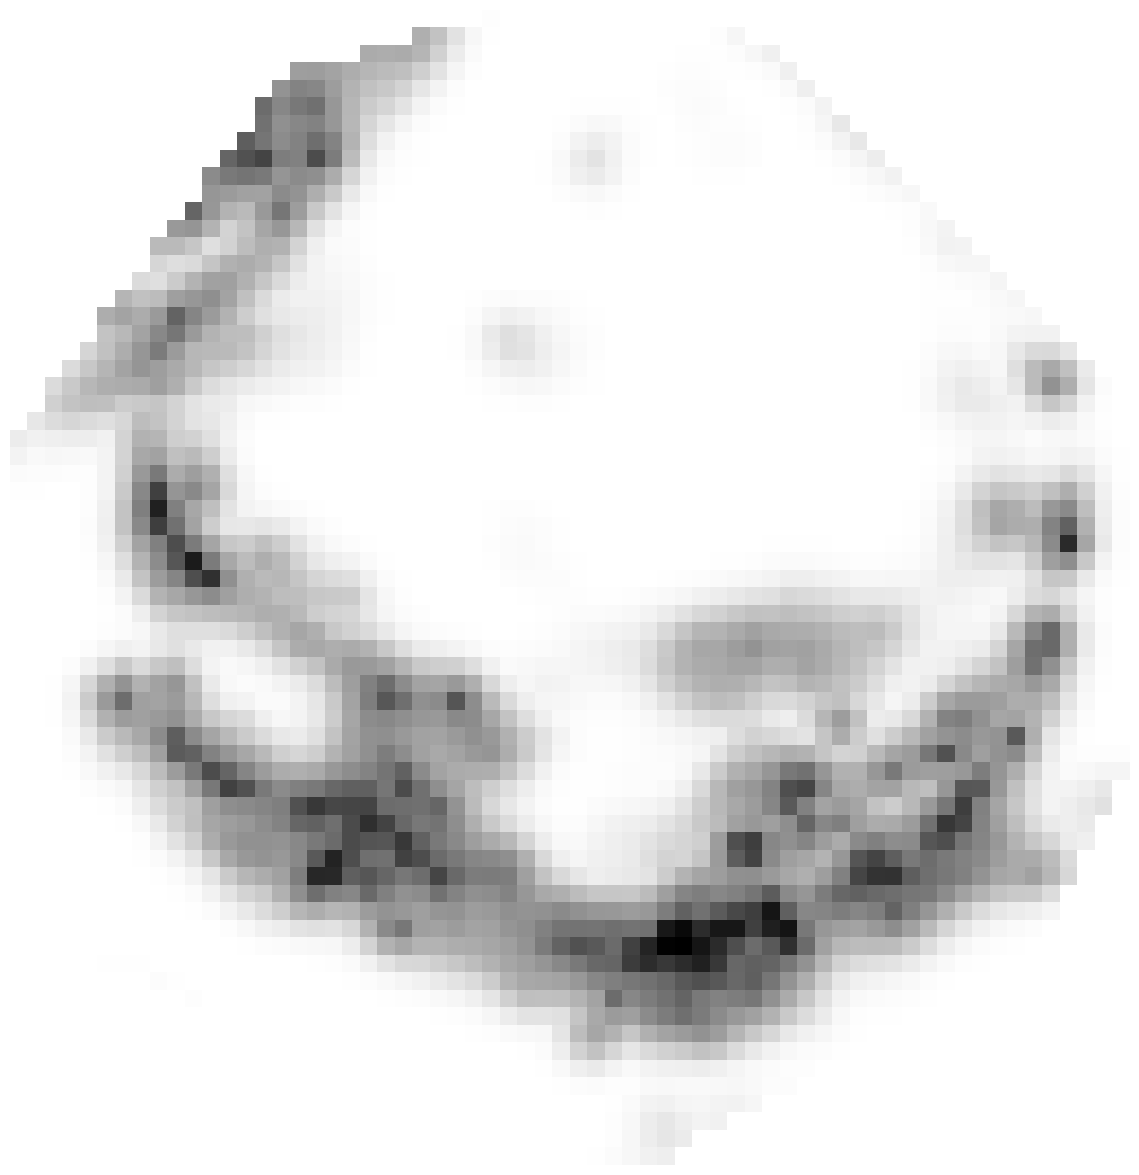

142 Del38_46 367


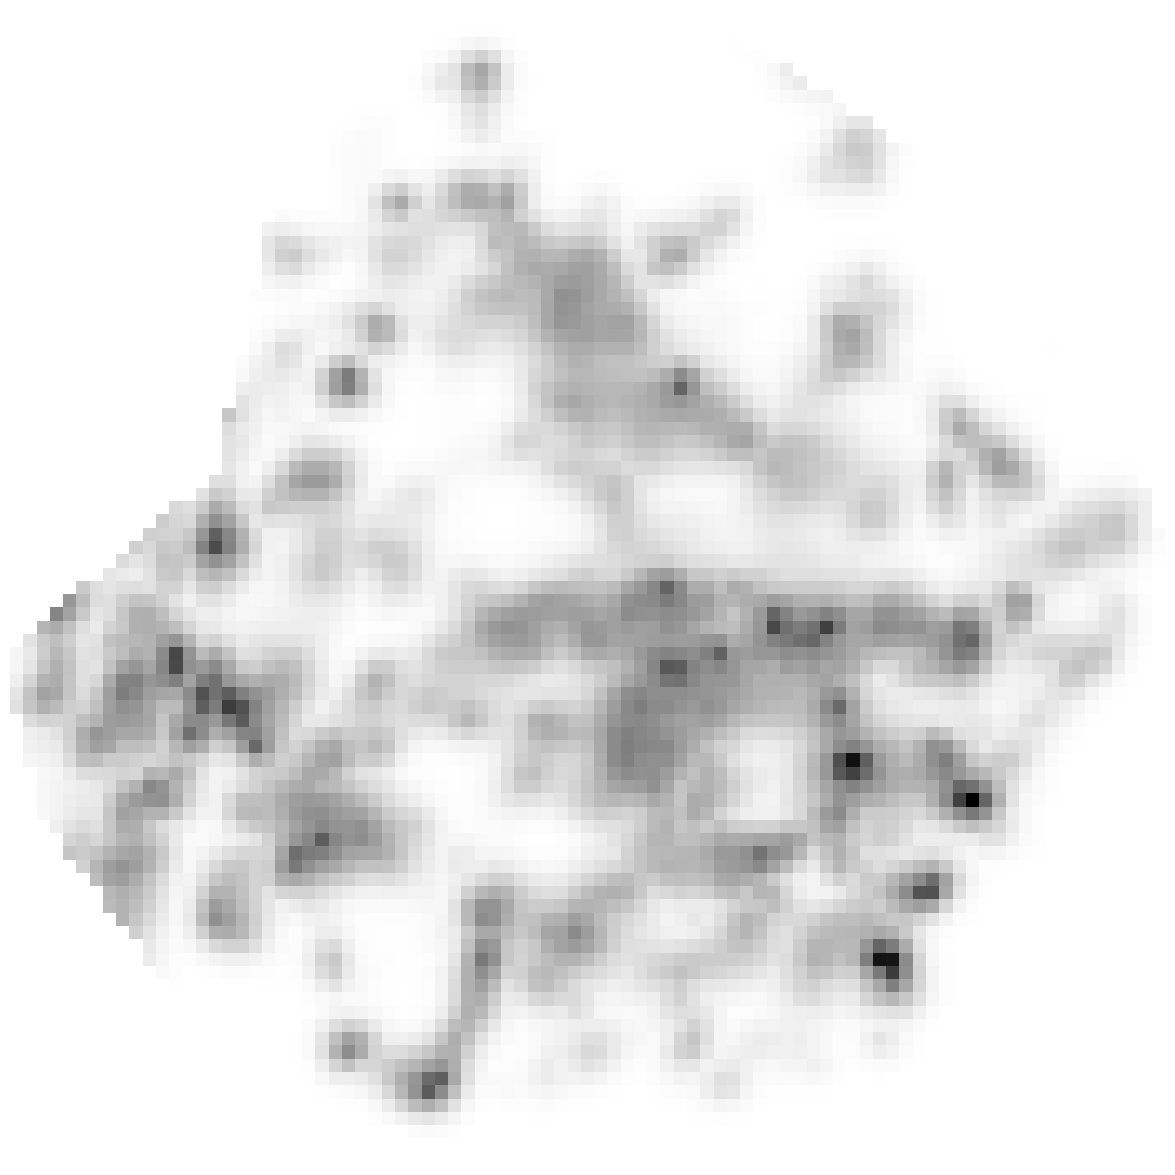

348 Del38_46 72


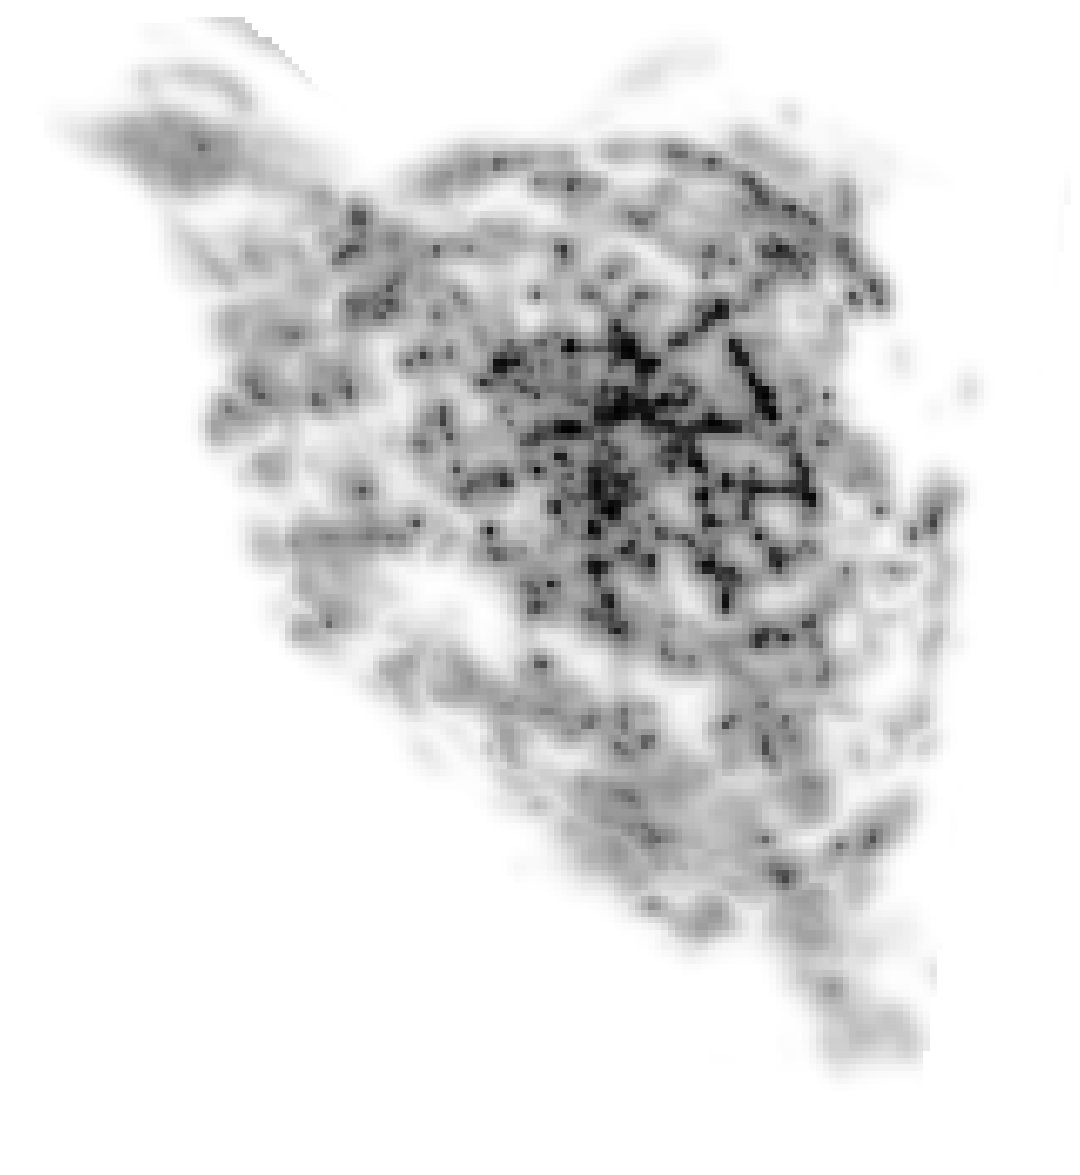

In [159]:
low_mid_high = [data.loc[354],data.loc[367],data.loc[72]]

for i in range(3): 
    print(low_mid_high[i]['LSF1D:Number of Lines'],low_mid_high[i]['Label'],low_mid_high[i].name)
    fig,ax = plt.subplots(figsize=(15,15))
    plt.imshow(np.max(low_mid_high[i]['Patches'][1]) - low_mid_high[i]['Patches'][1],cmap='gray')
    plt.axis('off')
    #scalebar = ScaleBar(1,"px",color='k',box_alpha=0,dimension='pixel-length') 
    #ax.add_artist(scalebar)
    #plt.savefig(".//CytoskeletonOrganisationExamples//quantity_deconv" + str(i) + ".png",format='png',transparent=True,bbox_inches='tight',dpi=500)
    plt.show()    
    
df = pd.concat(low_mid_high,axis=1).transpose()

# <font color='red'>Fibre Parallelism</font>

##### <font color='red'>Sort by desired feature, choose cells and get new dataset</font>

In [6]:
temp = data.sort_values(by=['LSF1D:Angle Difference mean'])

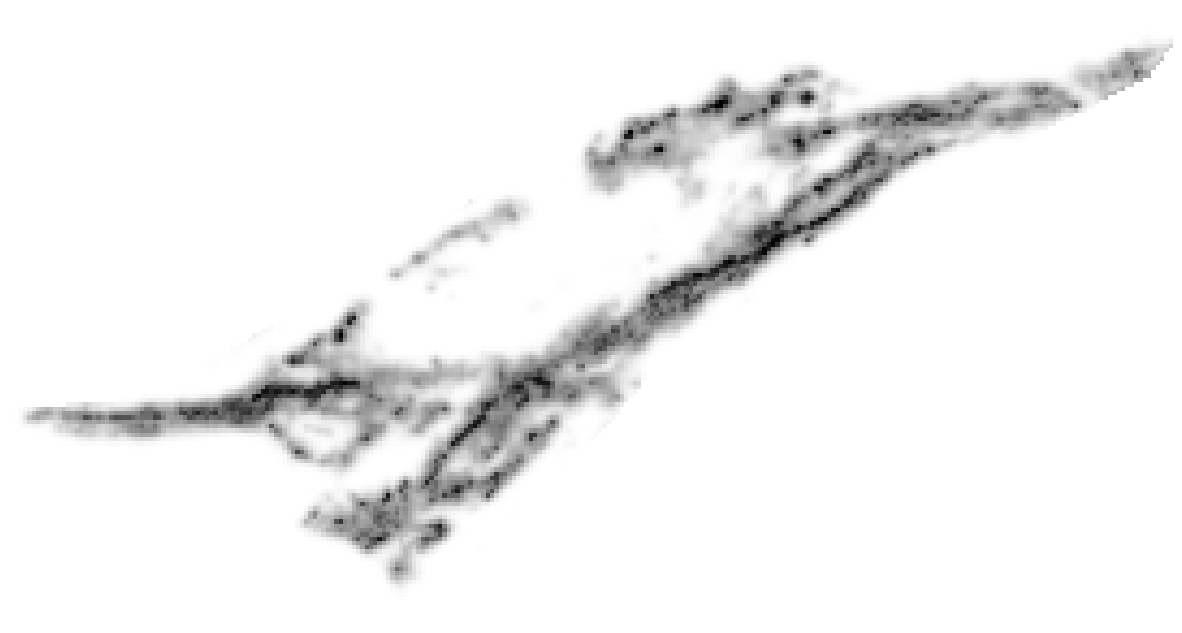

421


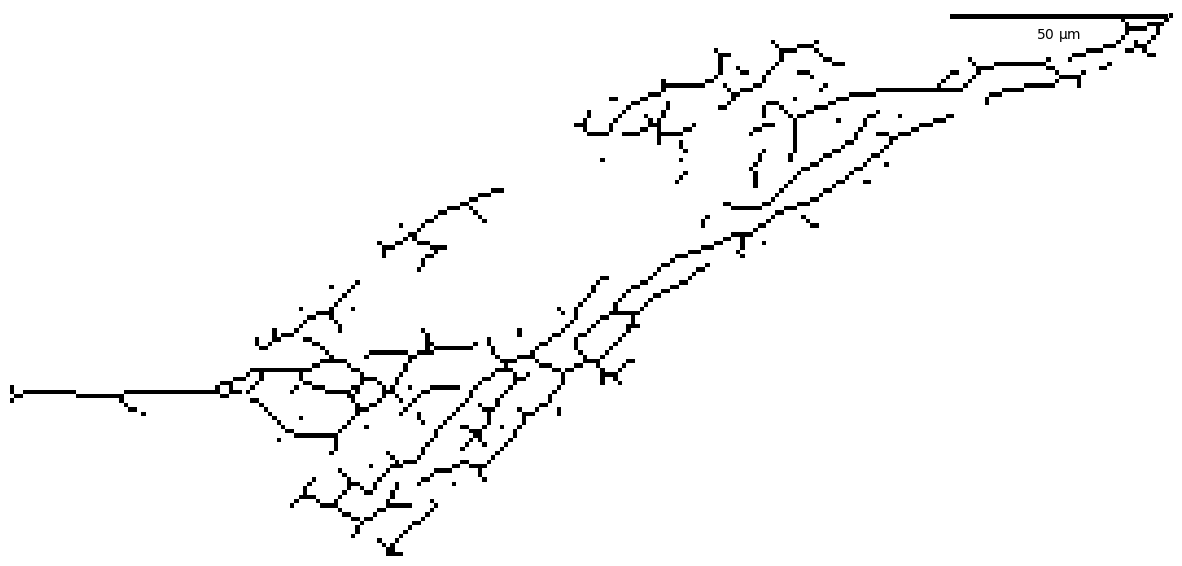

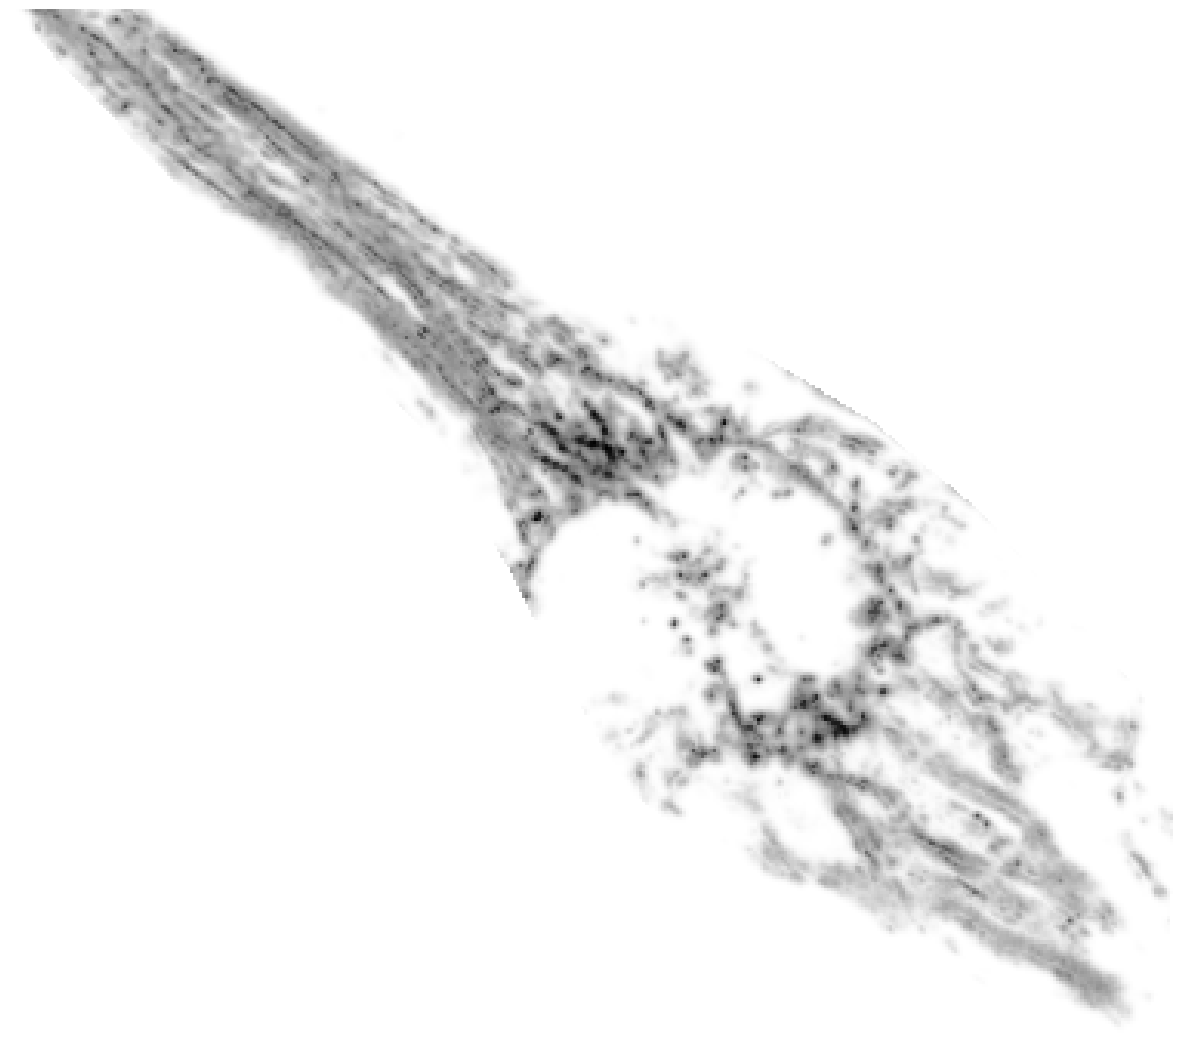

7


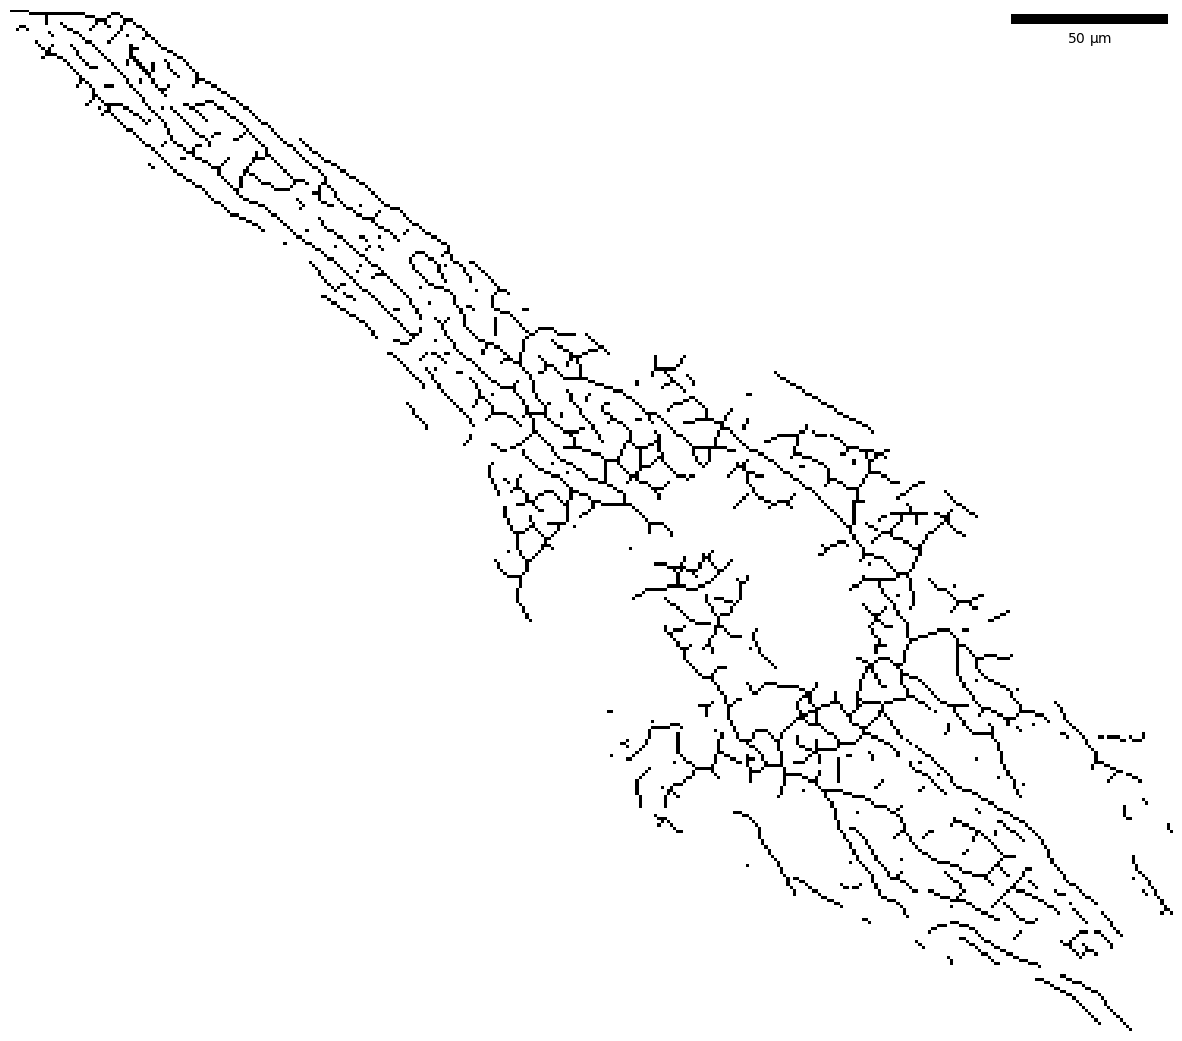

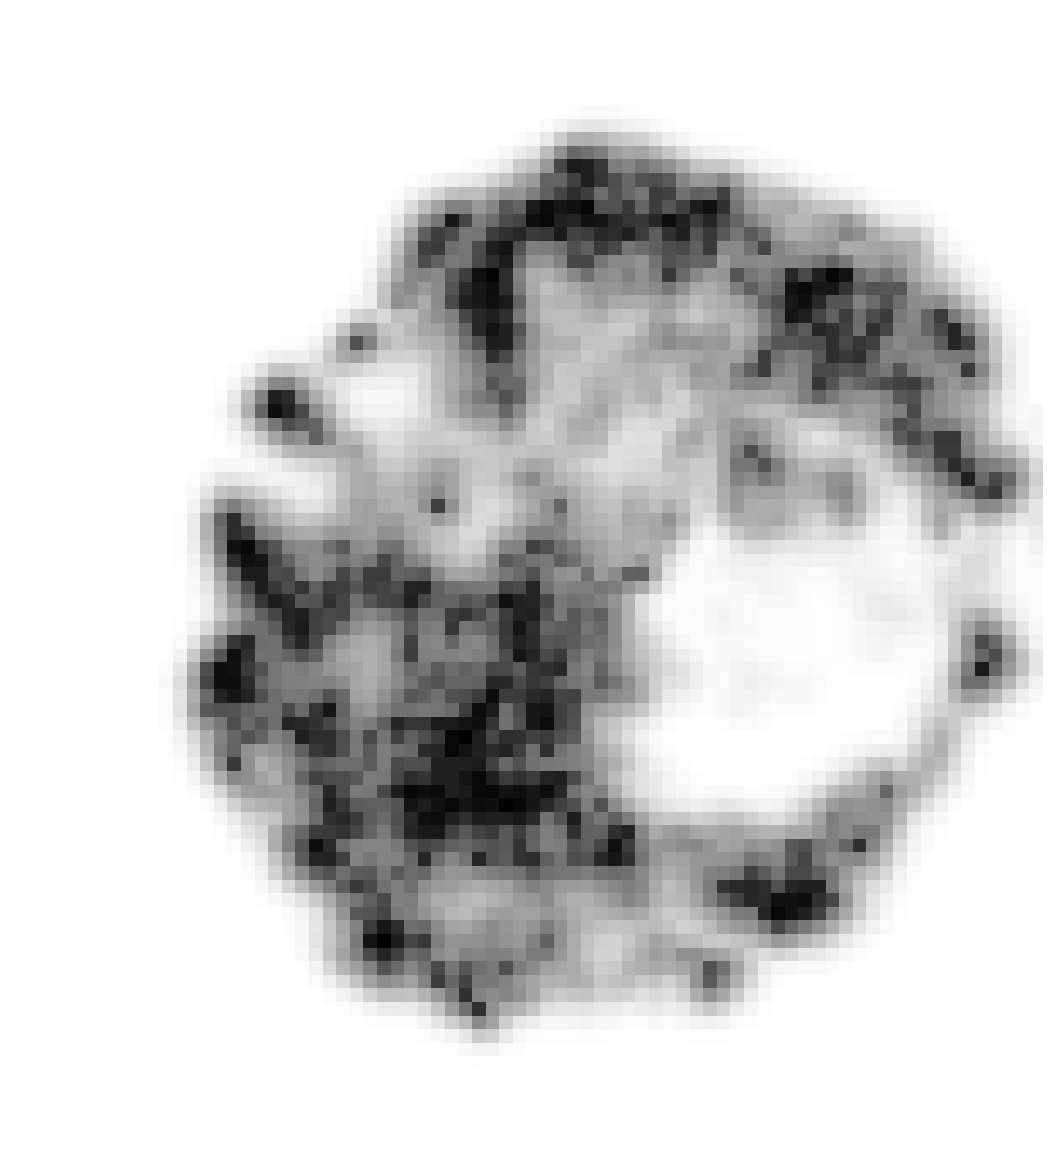

556


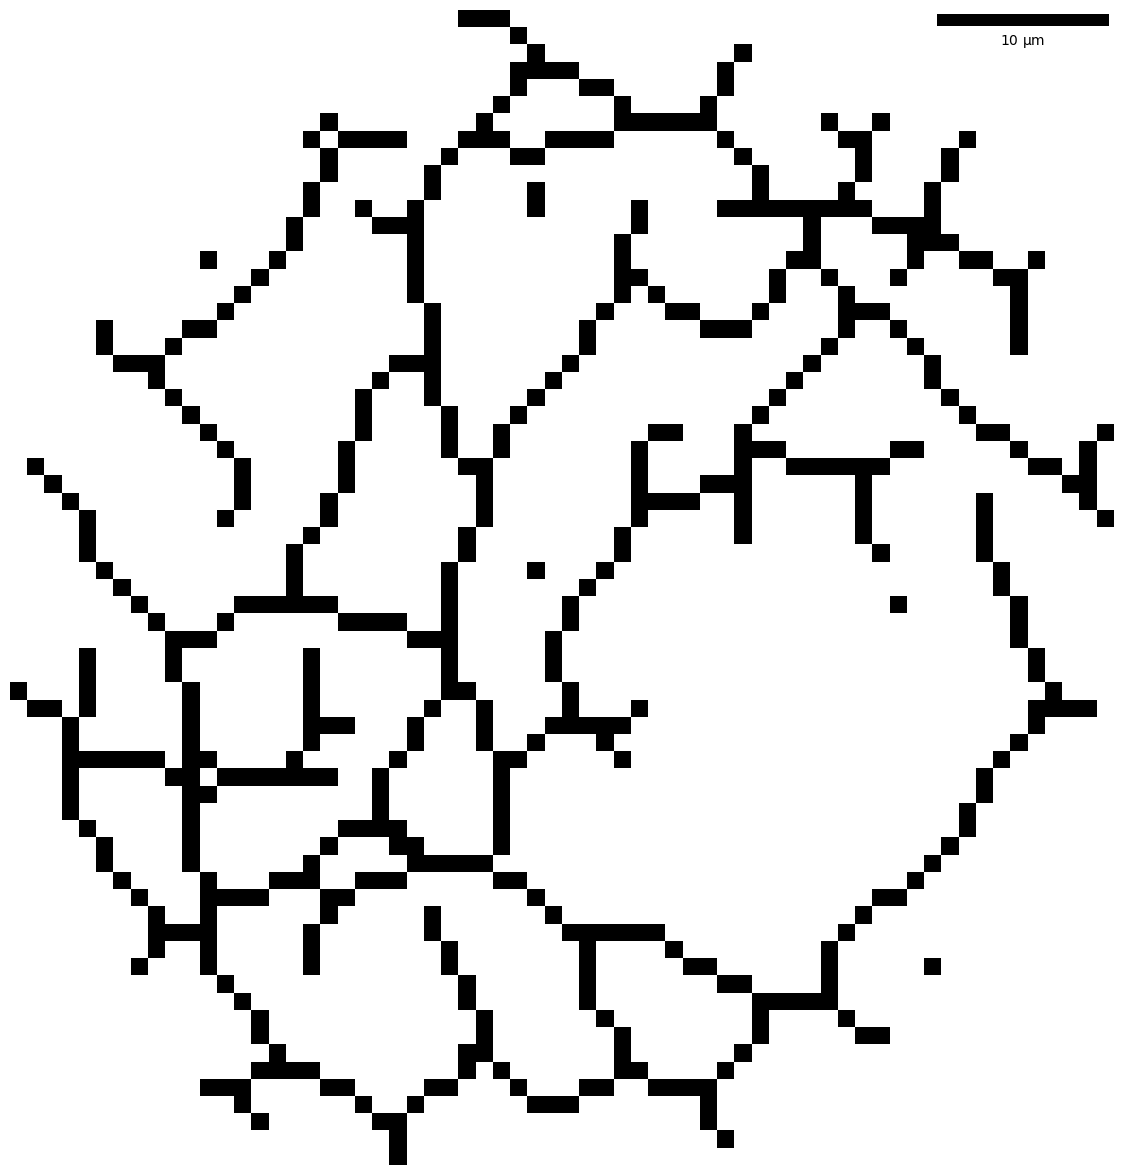

In [12]:
low_mid_high = [temp.loc[temp.index[16]],temp.loc[7],temp.loc[temp.index[-11]]]

for i in range(3):     
    # Deconv
    fig,ax = plt.subplots(figsize=(15,15))
    plt.imshow(np.max(low_mid_high[i]['Patches'][1]) - low_mid_high[i]['Patches'][1],cmap='gray')
    plt.axis('off')
    #plt.savefig(".//CytoskeletonOrganisationExamples//parallelism_deconv" + str(i) + ".png",format='png',transparent=True,bbox_inches='tight',dpi=500)
    plt.show()
    
    # Skel
    fig,ax = plt.subplots(figsize=(15,15))
    plt.imshow(1-low_mid_high[i]['Patches'][0],cmap='gray')
    plt.axis('off')
    scalebar = ScaleBar(1,"um",color='k',box_alpha=0,dimension='si-length') 
    ax.add_artist(scalebar)
    #plt.savefig(".//CytoskeletonOrganisationExamples//parallelism_skel" + str(i) + ".png",format='png',transparent=True,bbox_inches='tight',dpi=500)
     
    print(low_mid_high[i].name)
    
    
df = pd.concat(low_mid_high,axis=1).transpose()

# <font color='red'>Fibre Compactness</font>

##### <font color='red'>Sort by desired feature, choose cells and get new dataset</font>

In [53]:
def intraclustermetrics(lines,out):
    median_points  = [((line[0][0] + line[1][0])/2,(line[0][1] + line[1][1])/2) for line in lines]
    d              = distance_matrix(median_points,median_points); np.fill_diagonal(d,np.max(d));
    d_0            = distance_matrix(median_points,median_points); np.fill_diagonal(d_0,0);
    center         = (np.mean(np.array(median_points)[:,0]), np.mean(np.array(median_points)[:,1]))
    
    max_d          = np.max(d)
    avg_diam_dist  = np.sum(d_0) / (len(lines)*(len(lines) - 1))
    cent_diam_dist = 2*np.sum([np.linalg.norm(np.array(m)-np.array(center)) for m in median_points]) / len(lines)
            
    if out == 0:
        return max_d*0.16125
    if out == 1:
        return avg_diam_dist*0.16125
    if out == 2:
        return cent_diam_dist*0.16125
    
ResultsDF['OTHERS:IntCluMet Maximum Distance'] = [intraclustermetrics(l,out=0) for l in ResultsDF['Lines']] # Maximum distance
ResultsDF['OTHERS:IntCluMet Mean Distance'] = [intraclustermetrics(l,out=1) for l in ResultsDF['Lines']] # Mean distance?
ResultsDF['OTHERS:IntCluMet Distance to CoM'] = [intraclustermetrics(l,out=2) for l in ResultsDF['Lines']] # Distance to center of mass
ResultsDF['OTHERS:IntCluMet Distance to CoM (divided by Nlines)'] = np.array([intraclustermetrics(l,out=2) for l in ResultsDF['Lines']]) / np.array(ResultsDF['LSF1D:Number of Lines'])

In [61]:
temp = ResultsDF.sort_values(by=['LSF1D:N over A 2 (scaled)'])

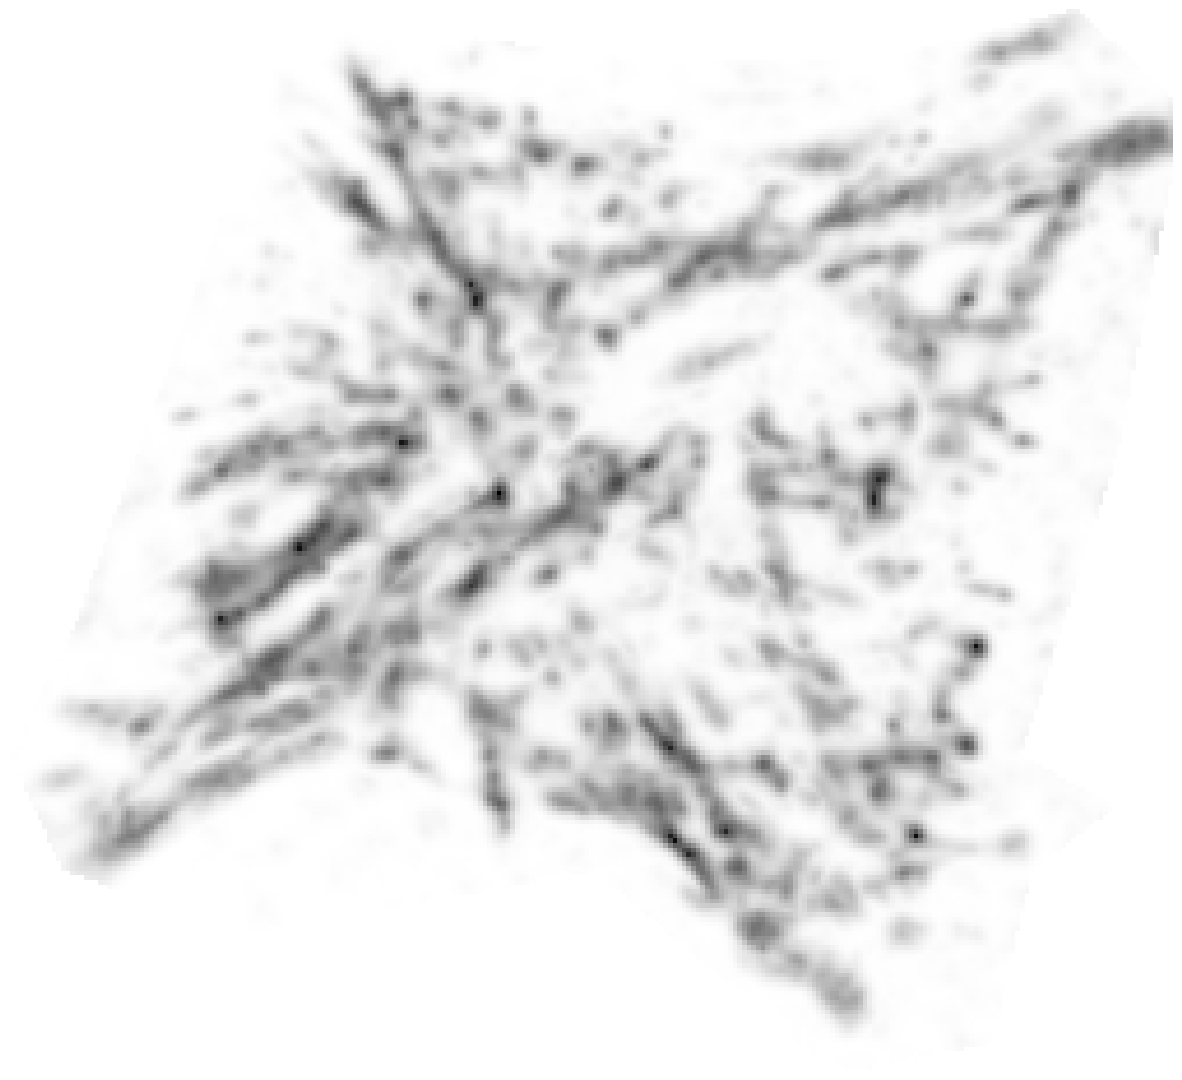

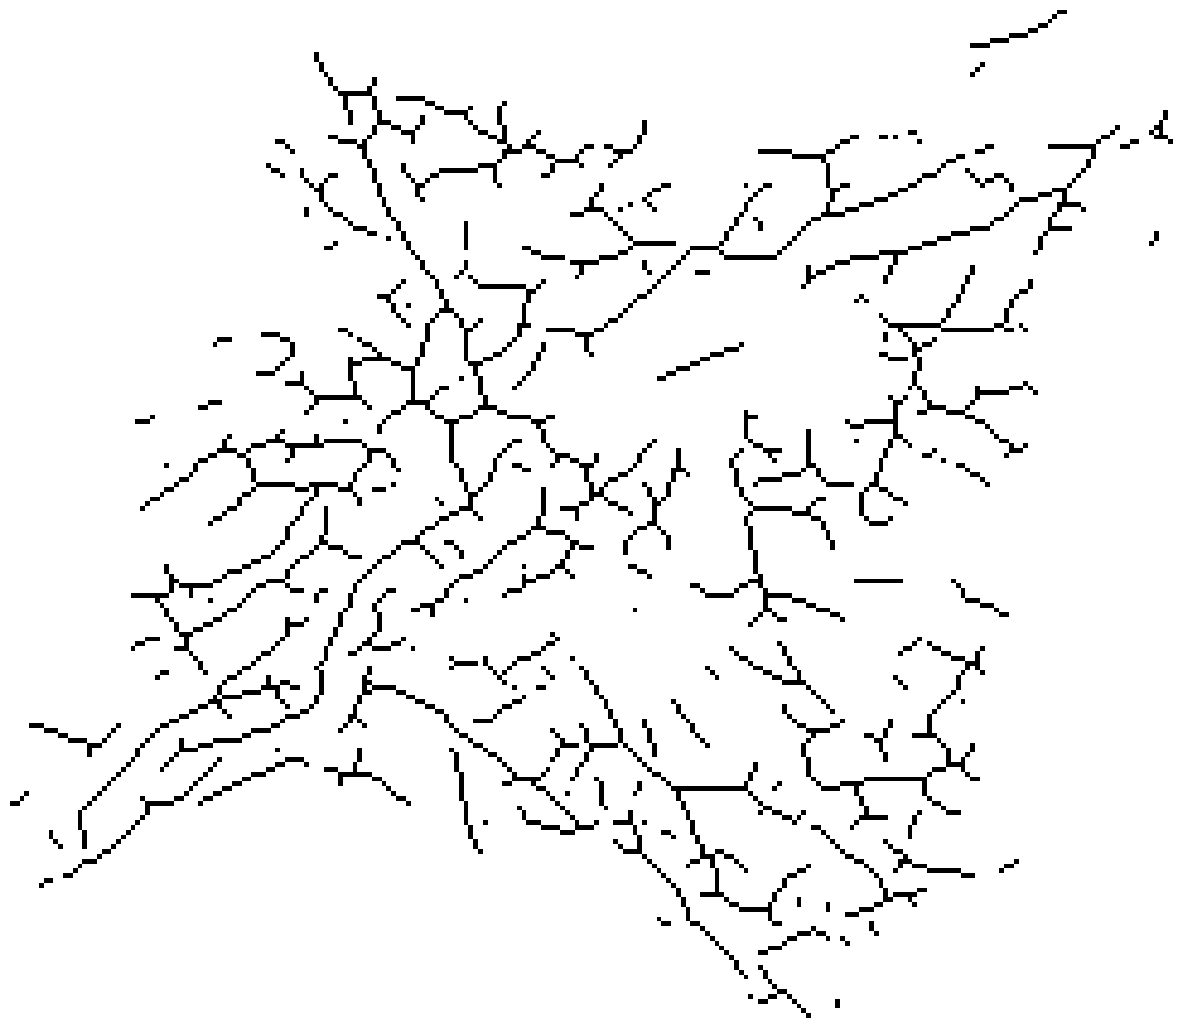

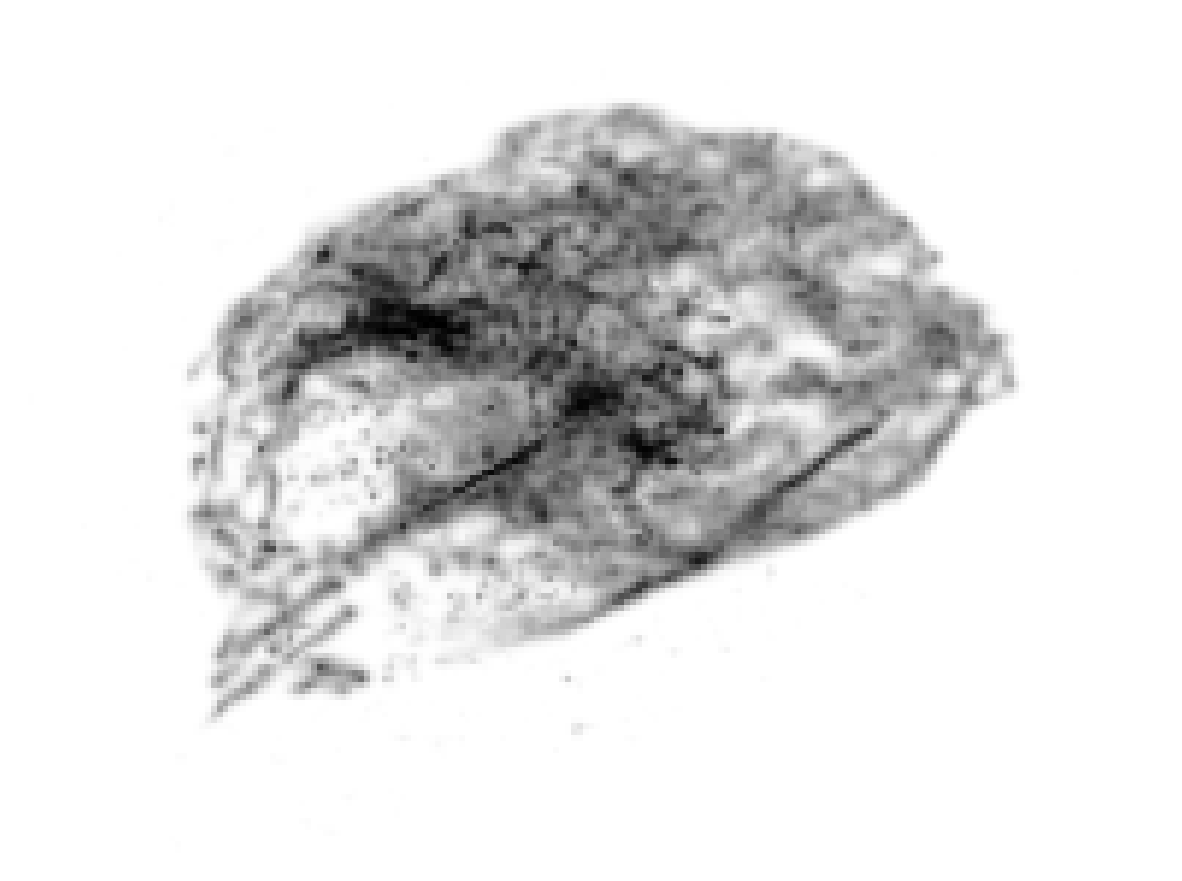

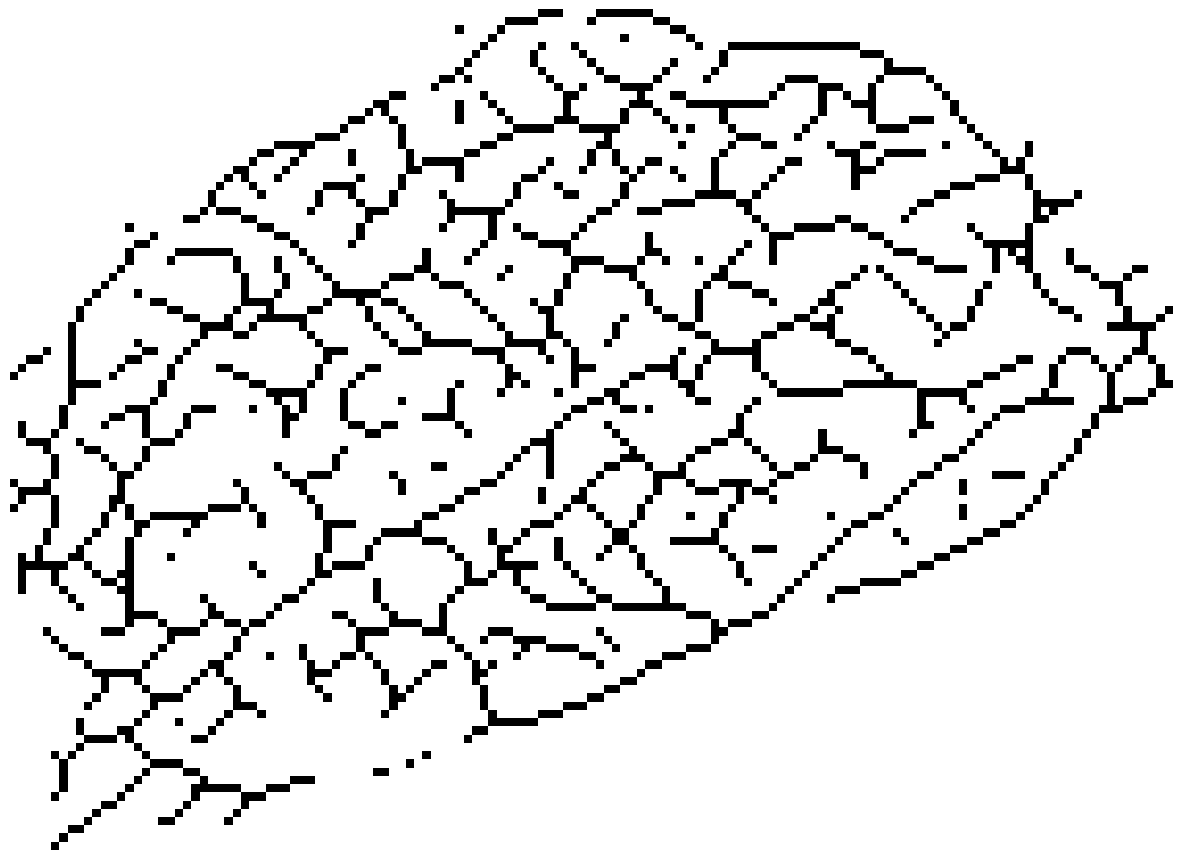

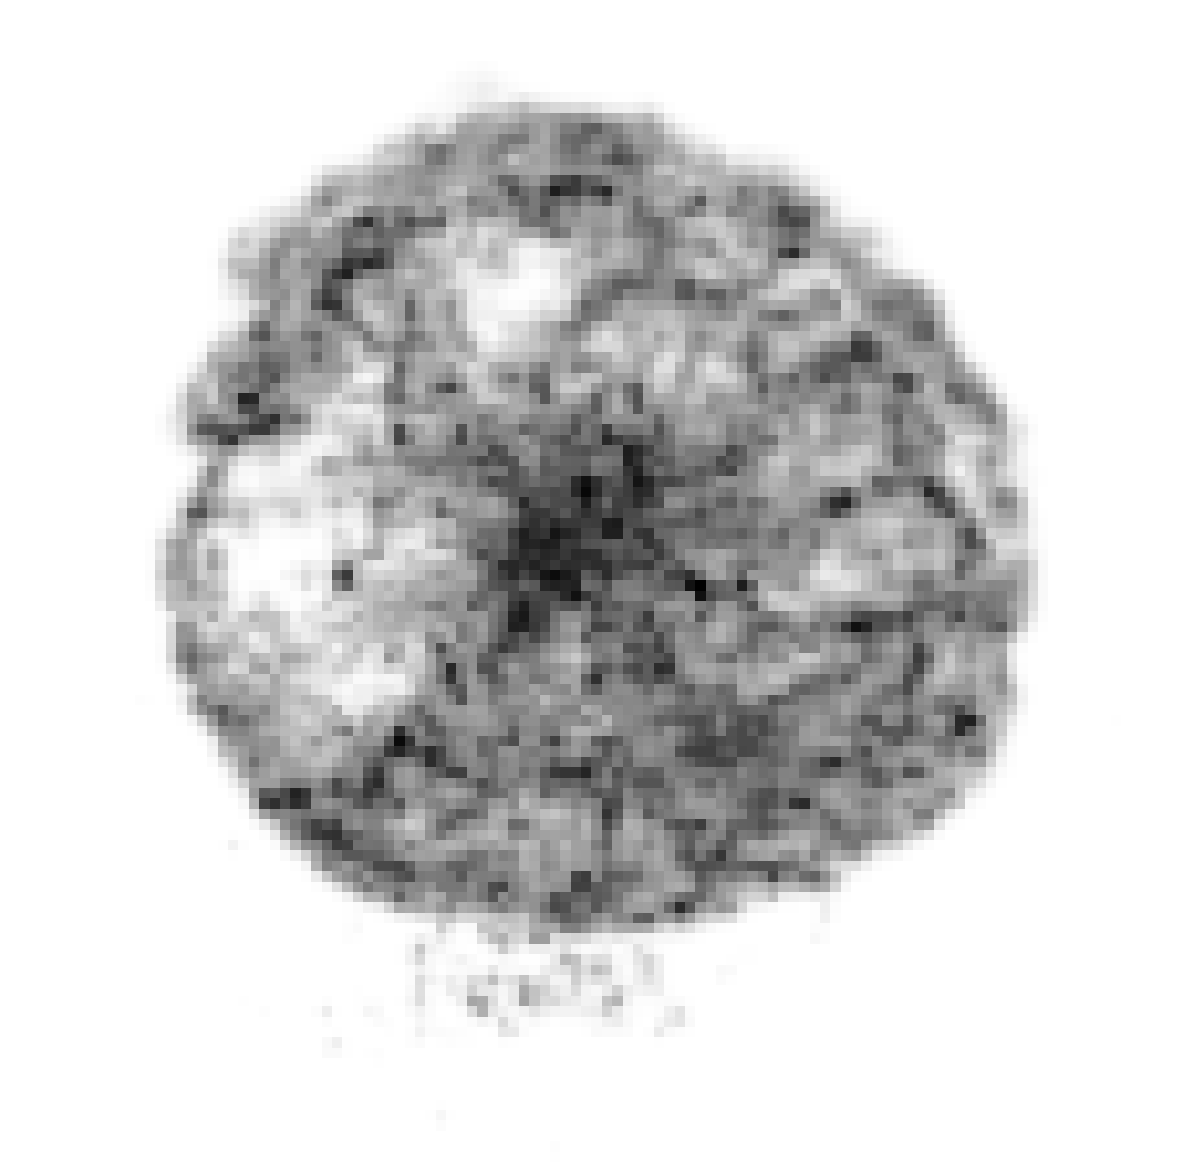

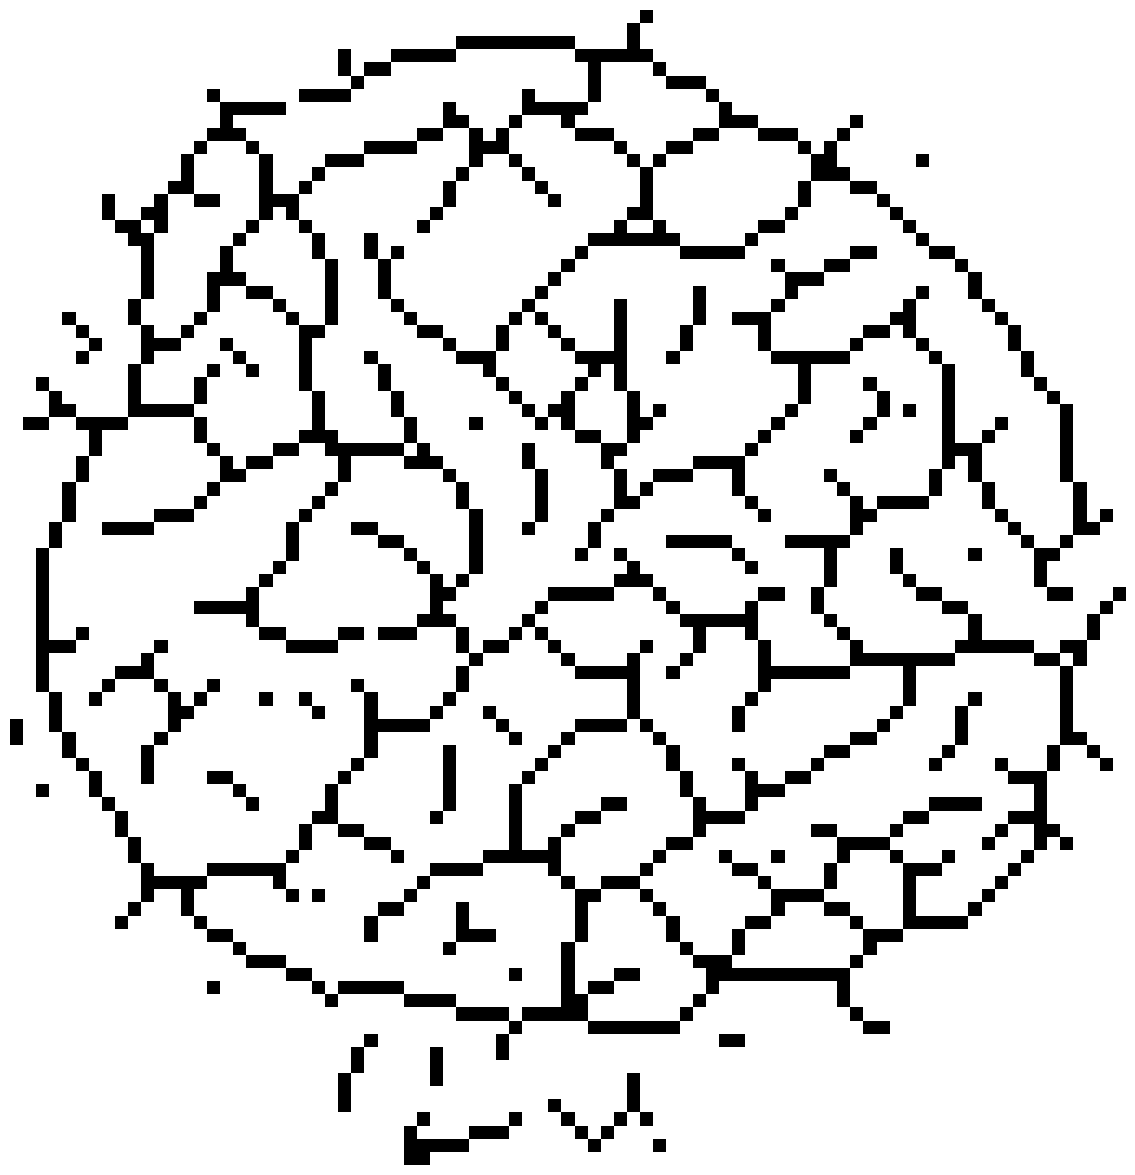

In [14]:
#low_mid_high = [temp.loc[1025],temp.loc[temp.index[4+int(len(temp)/2)]],temp.loc[temp.index[-2]]]
#low_mid_high = [temp.loc[1025],temp.loc[391],temp.loc[231]]
low_mid_high = [temp.loc[1025],temp.loc[936],temp.loc[958]]

for i in range(3):
    # Deconv
    fig,ax = plt.subplots(figsize=(15,15))
    plt.imshow(np.max(low_mid_high[i]['Patches'][1]) - low_mid_high[i]['Patches'][1],cmap='gray')
    plt.axis('off')
    #plt.savefig(folder + ".//compactness_deconv" + str(i) + ".pdf",format='pdf',transparent=True,bbox_inches='tight')
    plt.show()
    
    # Skel
    fig,ax = plt.subplots(figsize=(15,15))
    plt.imshow(1-low_mid_high[i]['Patches'][0],cmap='gray')
    plt.axis('off')
    #scalebar = ScaleBar(1,"um",color='k',box_alpha=0,dimension='si-length') 
    #ax.add_artist(scalebar)
    #plt.savefig(".//CytoskeletonOrganisationExamples//compactness_skel" + str(i) + ".png",format='png',transparent=True,bbox_inches='tight',dpi=500)
        
    plt.show()
    
df = pd.concat(low_mid_high,axis=1).transpose()

# <font color='red'>Fiber Cytoskeleton-Nucleus Interaction</font>

##### <font color='red'>Sort by desired feature, choose cells and get new dataset</font>

In [4]:
temp = data.sort_values(by=['LSF1D:Distances to Centroid mean'])

27.05368181818182 Dup41_46 539
34.588801556420236 Mut394 129
68.24331512605043 No transfection 841


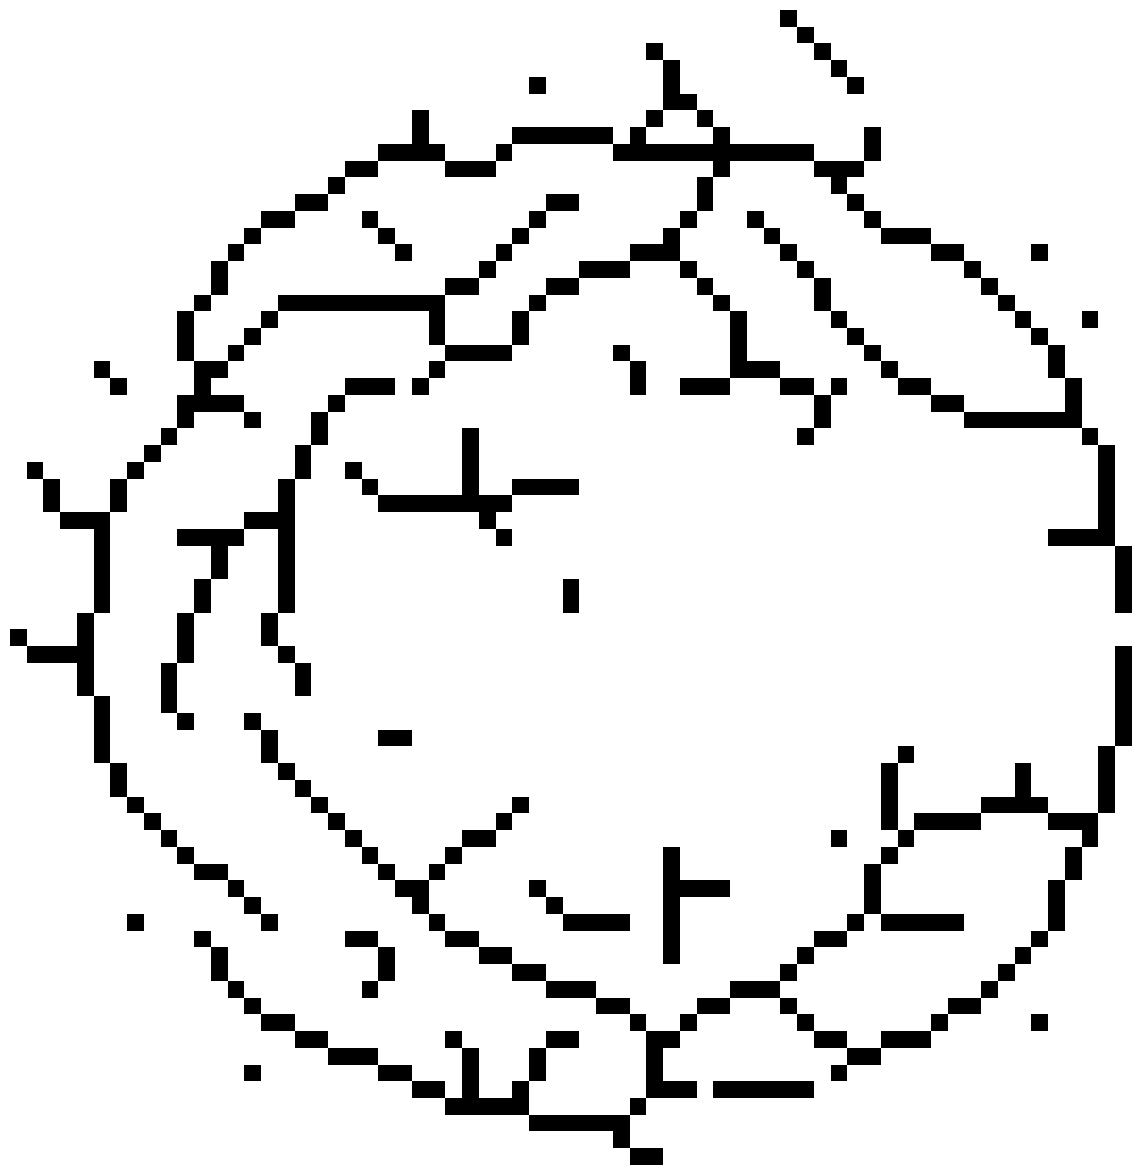

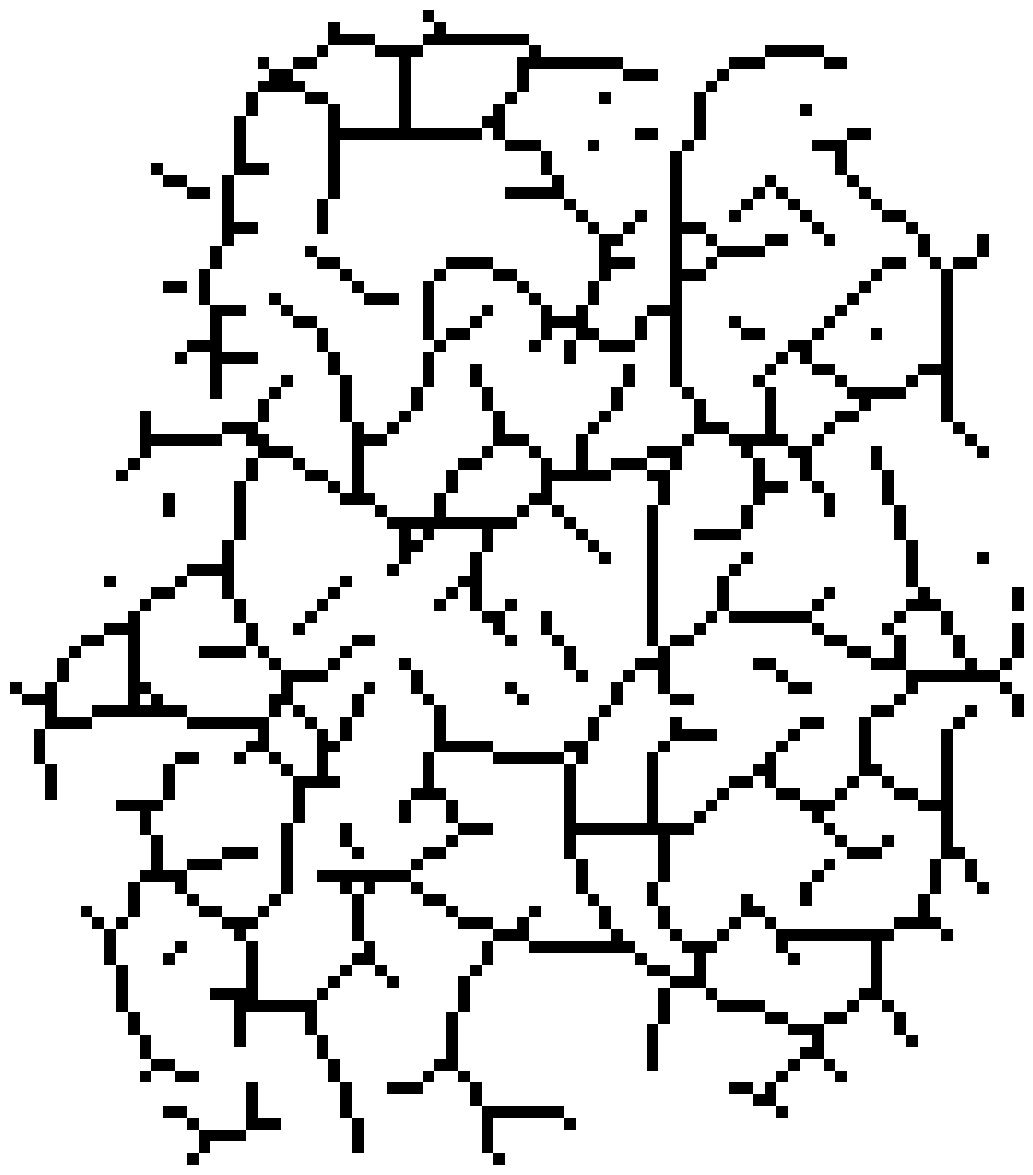

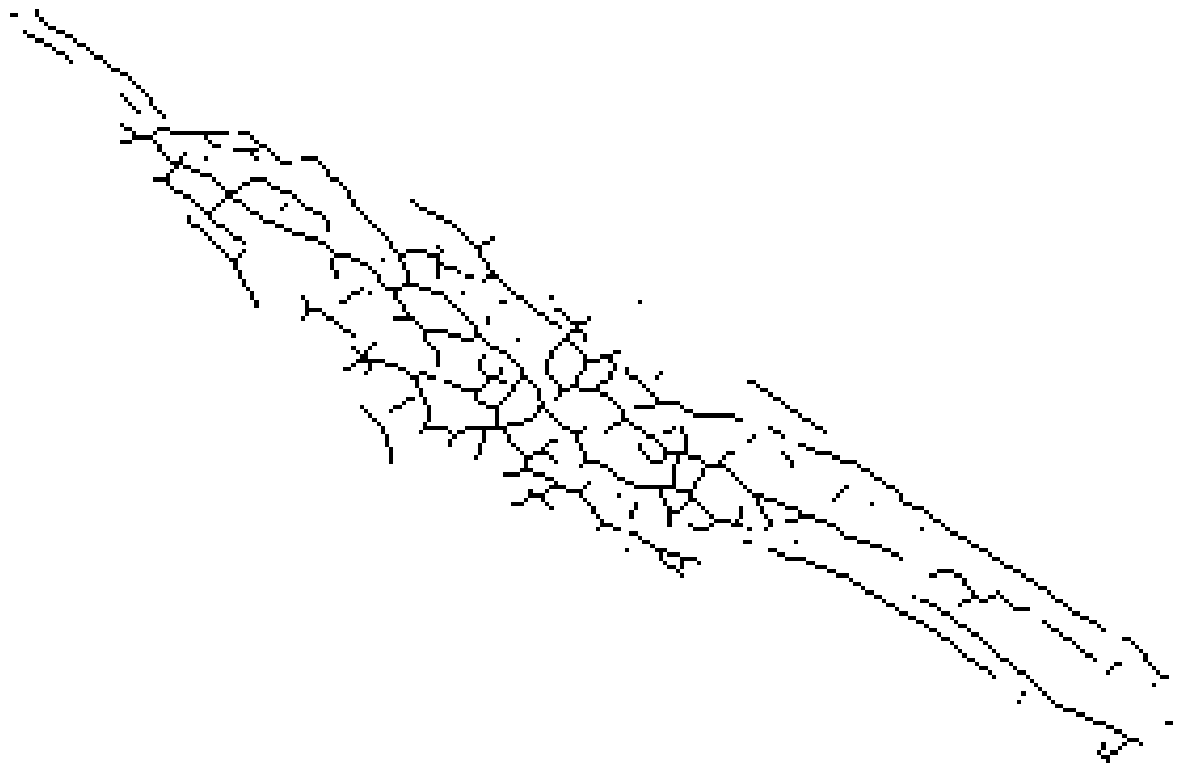

In [7]:
#low_mid_high = [temp.loc[temp.index[5]],temp.loc[temp.index[9+int(len(temp)/2)]],temp.loc[temp.index[-7]]]
#low_mid_high = [temp.loc[144],temp.loc[temp.index[int(len(temp)/2)]],temp.loc[temp.index[-2]]]
low_mid_high = [temp.loc[539],temp.loc[129],temp.loc[841]]
#low_mid_high = [temp.loc[31],temp.loc[165],temp.loc[713]]

for i in range(3): 
    print(low_mid_high[i]['LSF1D:Distances to Centroid mean'],low_mid_high[i]['Label'],low_mid_high[i].name)
    # Deconv
#     fig,ax = plt.subplots(figsize=(15,15))
#     im = np.max(low_mid_high[i]['Patches'][1]) - low_mid_high[i]['Patches'][1]
#     props = regionprops((im!=0)*1,im)
#     cent = props[0].centroid
#     plt.imshow(np.max(low_mid_high[i]['Patches'][1]) - low_mid_high[i]['Patches'][1],cmap='gray')
#     plt.axis('off')
#     plt.plot()
#     #plt.savefig(".//CytoskeletonOrganisationExamples//distfromcent_deconv" + str(i) + ".png",format='png',transparent=True,bbox_inches='tight',dpi=500)
#     plt.show()
    
    # Skel
    fig,ax = plt.subplots(figsize=(15,15))
    plt.imshow(1-low_mid_high[i]['Patches'][0],cmap='gray')
    plt.axis('off')
    #scalebar = ScaleBar(1,"um",color='k',box_alpha=0,dimension='si-length') 
    #ax.add_artist(scalebar)
    #plt.savefig(".//CytoskeletonOrganisationExamples//distfromcent_skel" + str(i) + ".png",format='png',transparent=True,bbox_inches='tight',dpi=500)
        
    
df = pd.concat(low_mid_high,axis=1).transpose()

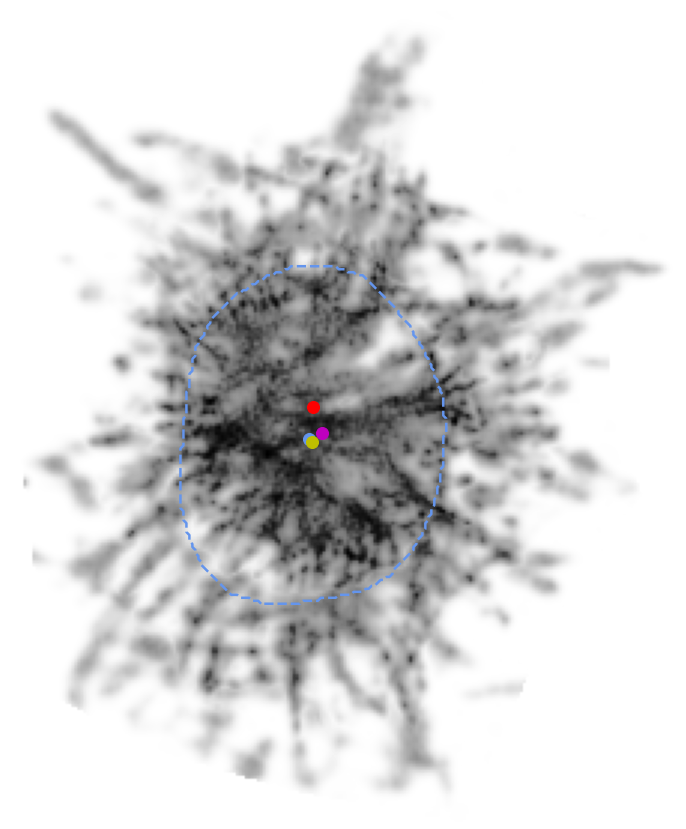

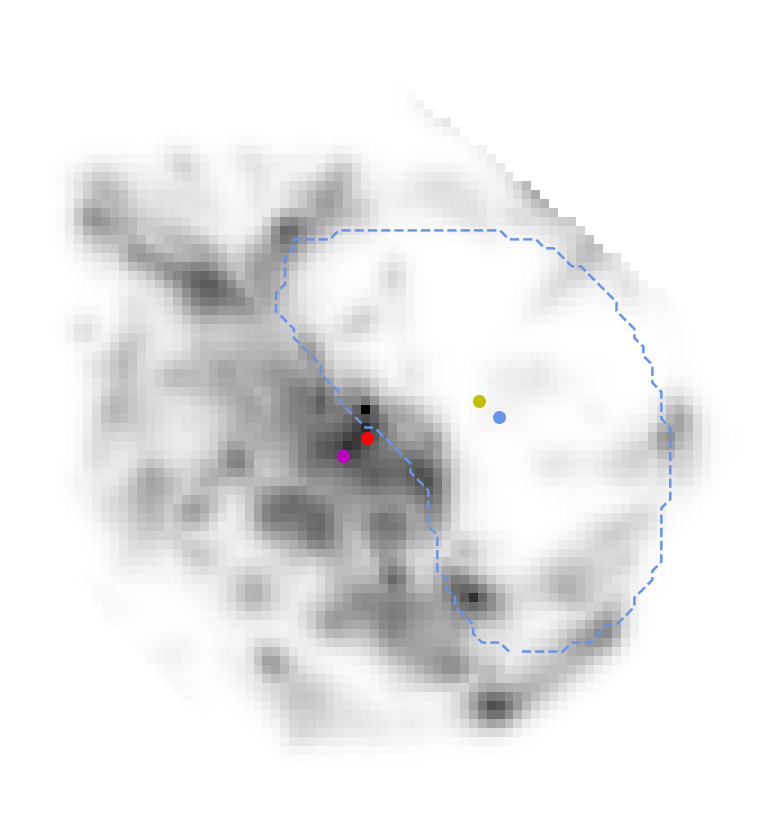

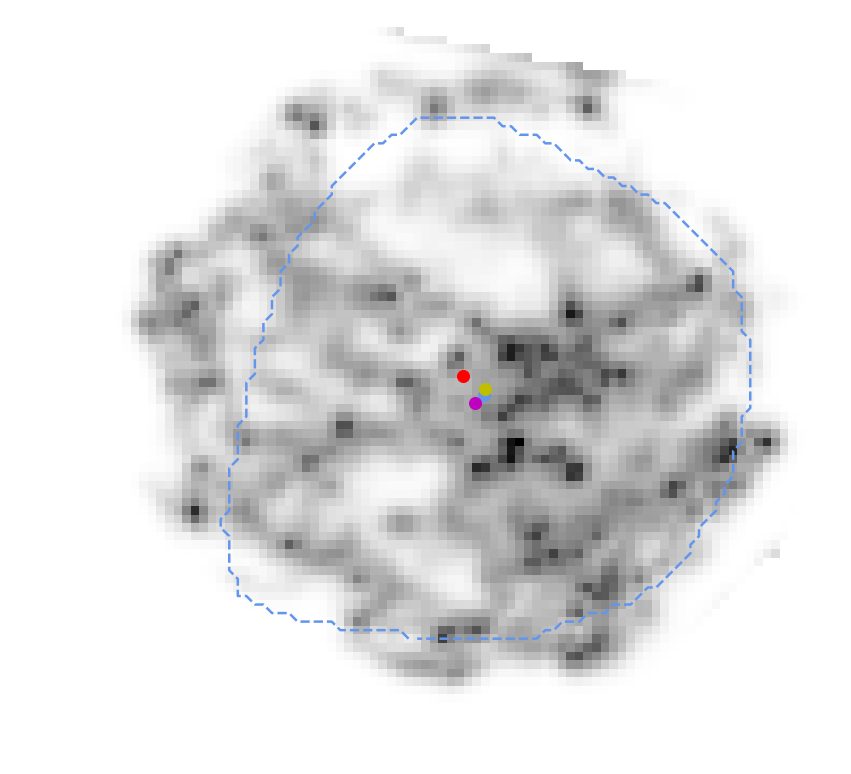

In [86]:
for index,row in subResultsDF.iterrows():
    # Deconv
    fig,ax = plt.subplots(figsize=(15,15))
    nuc = NucleiDeconvDF['Image'][row['Img Index']] * row['Mask']
    img = DeconvDF['Image'][row['Img Index']] * row['Mask']
    plt.imshow(np.max(img) - img,cmap='gray')
    ax.plot(row['Nucleus Centroid'][1],row['Nucleus Centroid'][0],'o',color='#6495ED',markersize=12,zorder=8)
    props = regionprops((img!=0)*1,img)
    propsn = regionprops((nuc!=0)*1,nuc)
    cent = props[0].centroid
    centw = props[0].centroid_weighted
    centwn = propsn[0].centroid_weighted
    ax.plot(cent[1],cent[0],'o',color='r',markersize=12,zorder=8)
    ax.plot(centw[1],centw[0],'o',color='m',markersize=12,zorder=8)
    ax.plot(centwn[1],centwn[0],'o',color='y',markersize=12,zorder=8)
    ax.plot(row['Nucleus Contour'][:,0],row['Nucleus Contour'][:,1],'--',color='#6495ED',zorder=11,linewidth=2.5)
    ax.set_ylim([min(row['Patches'][4]),max(row['Patches'][4])])
    ax.set_xlim([min(row['Patches'][5]),max(row['Patches'][5])])            
    plt.axis('off')
    #plt.savefig(".//CytoskeletonOrganisationExamples//distfromcent_deconv" + str(index) + ".png",format='png',transparent=True,bbox_inches='tight',dpi=500)
    plt.show()

# <font color='red'>Fiber Radiality</font>

In [17]:
ResultsDF['LSF3D:RS Mat Scores'] = pd.read_pickle(folder + ".//rsmatscoresvector.pkl")

##### <font color='red'>Sort by desired feature, choose cells and get new dataset</font>

In [170]:
temp = temp.sort_values(by=['LSF1D:Angles mean'])

31.50063813229572 WT 497
45.99945999999999 Del38_46 365
55.65473239436619 Del38_46 354


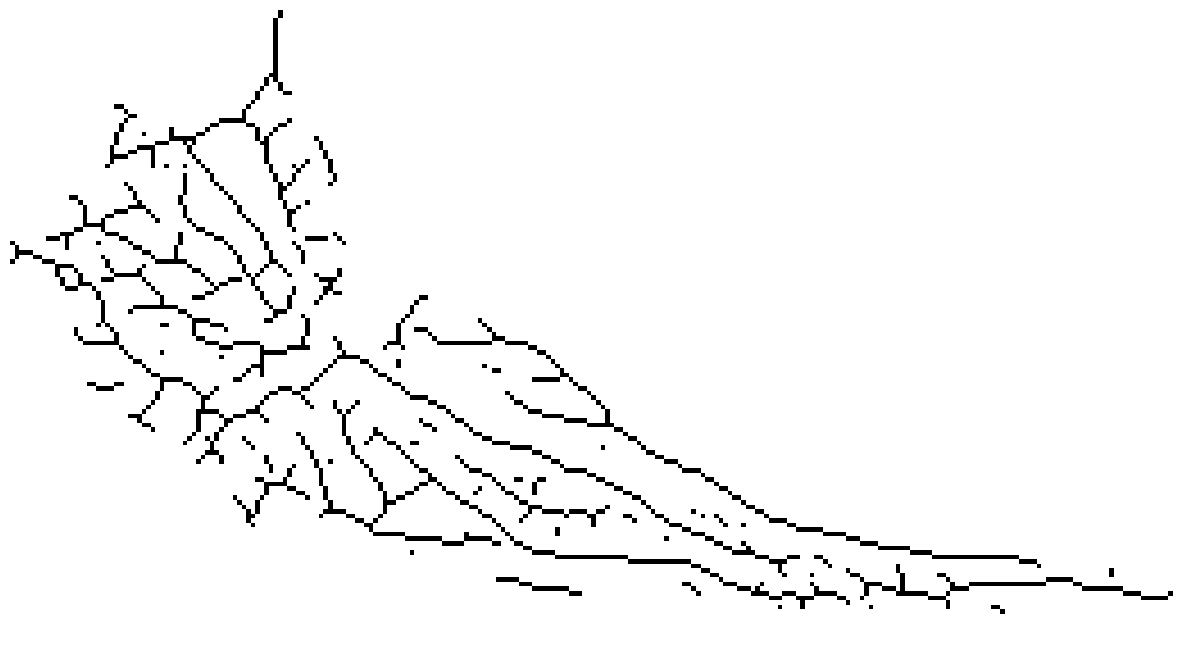

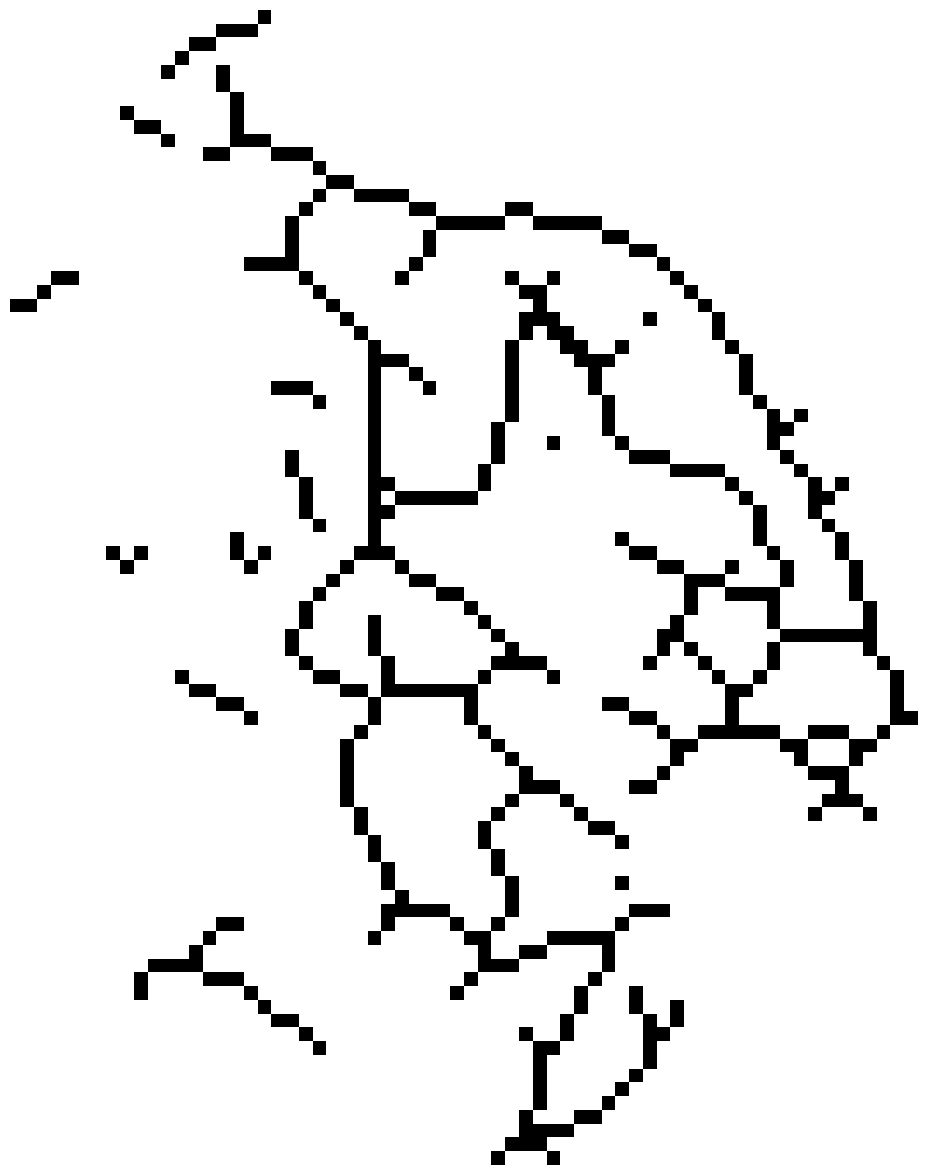

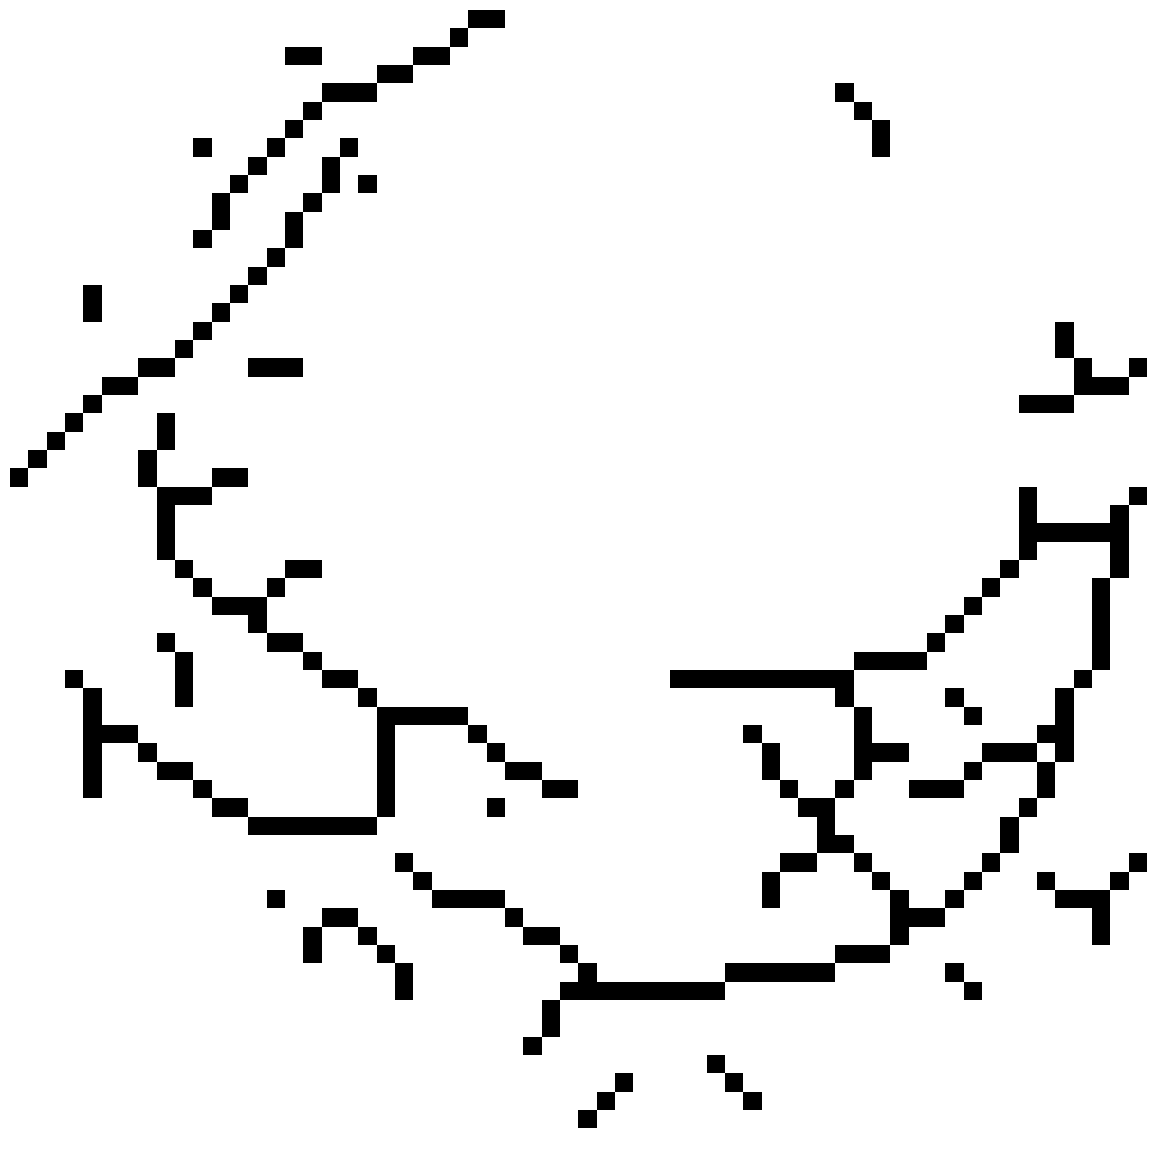

In [175]:
#low_mid_high = [temp.loc[144],temp.loc[156],temp.loc[146]]
low_mid_high = [temp.loc[497],temp.loc[temp.index[int(len(temp)/2)]],temp.loc[temp.index[-5]]]

for i in range(3):
    print(low_mid_high[i]['LSF1D:Angles mean'],low_mid_high[i]['Label'],low_mid_high[i].name)
    # Skel
    fig,ax = plt.subplots(figsize=(15,15))
    plt.imshow(1-low_mid_high[i]['Patches'][0],cmap='gray')
    plt.axis('off')
    #scalebar = ScaleBar(1,"um",color='k',box_alpha=0,dimension='si-length') 
    #ax.add_artist(scalebar)
    #plt.savefig(".//CytoskeletonOrganisationExamples//distfromcent_skel" + str(i) + ".png",format='png',transparent=True,bbox_inches='tight',dpi=500)
        
    
df = pd.concat(low_mid_high,axis=1).transpose()

In [78]:
res = []
i=0
for index,row in temp.iterrows():
    
    mat_scores,radialSC, radialSC_pos = get_radial(row)
    res += [[mat_scores,radialSC, radialSC_pos[0]]]
    i=i+1
    print(100*i/len(temp))

temp['LSF:RS Mat Scores'] = [x[0] for x in res]
temp['LSF:RS'] = [x[1] for x in res]
temp['LSF:RSpos'] = [x[2] for x in res]

resu = []
i = 0
for i in range(len(temp['LSF:RSpos'])):
    nc = temp['Nucleus Centroid'].values[i]
    rs = temp['LSF:RSpos'].values[i]
    try:
        dist = np.sqrt((nc[0]-rs[0])**2 + (nc[1]-rs[1])**2)
    except:
        dist = 0
        
    resu += [dist]
    
temp['LSF:RS-NucCent Distance'] = resu

0.09560229445506692
0.19120458891013384
0.28680688336520077
0.3824091778202677
0.4780114722753346
0.5736137667304015
0.6692160611854685
0.7648183556405354
0.8604206500956023
0.9560229445506692
1.0516252390057361
1.147227533460803
1.24282982791587
1.338432122370937
1.4340344168260037
1.5296367112810707
1.6252390057361377
1.7208413001912046
1.8164435946462716
1.9120458891013383
2.0076481835564053
2.1032504780114722
2.198852772466539
2.294455066921606
2.390057361376673
2.48565965583174
2.581261950286807
2.676864244741874
2.7724665391969405
2.8680688336520075
2.9636711281070744
3.0592734225621414
3.1548757170172084
3.2504780114722753
3.3460803059273423
3.4416826003824093
3.537284894837476
3.632887189292543
3.72848948374761
3.8240917782026767
3.9196940726577436
4.015296367112811
4.1108986615678775
4.2065009560229445
4.3021032504780115
4.397705544933078
4.493307839388145
4.588910133843212
4.684512428298279
4.780114722753346
4.875717017208413
4.97131931166348
5.066921606118547
5.1625239005736

42.54302103250478
42.638623326959845
42.734225621414915
42.829827915869984
42.92543021032505
43.021032504780116
43.11663479923518
43.21223709369025
43.30783938814532
43.40344168260038
43.49904397705545
43.59464627151051
43.69024856596558
43.78585086042065
43.881453154875715
43.977055449330784
44.072657743785854
44.168260038240916
44.263862332695986
44.35946462715105
44.45506692160612
44.55066921606119
44.64627151051625
44.74187380497132
44.83747609942639
44.93307839388145
45.02868068833652
45.124282982791584
45.219885277246654
45.31548757170172
45.411089866156786
45.506692160611856
45.602294455066925
45.69789674952199
45.79349904397706
45.88910133843212
45.98470363288719
46.08030592734226
46.17590822179732
46.27151051625239
46.367112810707454
46.46271510516252
46.55831739961759
46.653919694072655
46.749521988527725
46.845124282982795
46.94072657743786
47.03632887189293
47.13193116634799
47.22753346080306
47.32313575525813
47.41873804971319
47.51434034416826
47.60994263862333
47.7055449

ipykernel_launcher.py (252): invalid value encountered in arccos


52.103250478011475
52.19885277246654
52.29445506692161
52.39005736137667
52.48565965583174
52.58126195028681
52.67686424474187
52.77246653919694
52.86806883365201
52.96367112810707
53.05927342256214
53.154875717017205
53.250478011472275
53.346080305927345
53.44168260038241
53.53728489483748
53.632887189292546
53.72848948374761
53.82409177820268
53.91969407265774
54.01529636711281
54.11089866156788
54.20650095602294
54.30210325047801
54.397705544933075
54.493307839388144
54.588910133843214
54.68451242829828
54.780114722753346
54.875717017208416
54.97131931166348
55.06692160611855
55.16252390057361
55.25812619502868
55.35372848948375
55.44933078393881
55.54493307839388
55.64053537284895
55.736137667304014
55.831739961759084
55.927342256214146
56.022944550669216
56.118546845124285
56.21414913957935
56.30975143403442
56.40535372848949
56.50095602294455
56.59655831739962
56.69216061185468
56.78776290630975
56.88336520076482
56.978967495219884
57.07456978967495
57.170172084130016
57.26577437

95.79349904397705
95.88910133843213
95.98470363288719
96.08030592734225
96.17590822179733
96.27151051625239
96.36711281070745
96.46271510516253
96.5583173996176
96.65391969407266
96.74952198852772
96.8451242829828
96.94072657743786
97.03632887189292
97.131931166348
97.22753346080306
97.32313575525812
97.4187380497132
97.51434034416826
97.60994263862332
97.7055449330784
97.80114722753346
97.89674952198853
97.99235181644359
98.08795411089866
98.18355640535373
98.27915869980879
98.37476099426387
98.47036328871893
98.56596558317399
98.66156787762907
98.75717017208413
98.8527724665392
98.94837476099427
99.04397705544933
99.1395793499044
99.23518164435947
99.33078393881453
99.4263862332696
99.52198852772466
99.61759082217974
99.7131931166348
99.80879541108986
99.90439770554494
100.0


In [116]:
def get_radial(ResultsRow):
    # Get contour mask
    img = DeconvDF['Image'][ResultsRow['Img Index']] * ResultsRow['Mask']
    res = apply_hysteresis_threshold(img,threshold_otsu(img)*0.3,threshold_otsu(img))
    
    #Get x_,y_
    x_,y_   = np.where((ResultsRow['Mask']*1) != 0)
    
    # Get radial score
    gridpoints   = subsample_mask(ResultsRow['Mask'],3)
    mat_scores   = radialscore(ResultsRow['Lines'],gridpoints,x_,y_)
    radialSC     = round(np.max(mat_scores),5)
    radialSC_pos = [np.argwhere(mat_scores == np.max(mat_scores))[0]]
    
    return mat_scores,radialSC, radialSC_pos

def est_area(ResultsRow):
    img = DeconvDF['Image'][ResultsRow['Img Index']] * ResultsRow['Mask']
    res = apply_hysteresis_threshold(img,threshold_otsu(img)*0.6,threshold_otsu(img))
    
    img_nucl = ResultsRow['Mask'] * (NucleiDeconvDF['Image'][ResultsRow['Img Index']] / np.max(NucleiDeconvDF['Image'][ResultsRow['Img Index']]))
    
    rprops_cyto,rprops_nucl = regionprops((res!=0)*1,res),regionprops((img_nucl!=0)*1,img_nucl)
    centro_cyto,centro_nucl = rprops_cyto[0].centroid,rprops_nucl[0].centroid
    w_centro_cyto,w_centro_nucl = rprops_cyto[0].weighted_centroid,rprops_nucl[0].weighted_centroid

    return rprops_nucl[0].area/rprops_cyto[0].area


In [85]:
def get_centroid_again(ResultsRow):
    centroids = Centroids[ResultsRow['Img Index']]
    x_,y_   = np.where((ResultsRow['Mask']*1) != 0)

    # GET and PLOT centroid
    global centroid_list,centroid
    centroid_list = []

    # GET: centroid inside ROI indexes
    for idx,row in centroids.iterrows():
        if (round(row['Centroid'][0]),round(row['Centroid'][1])) in list(zip(x_,y_)): 
            centroid_list += [idx]
    if centroid_list == []:  print("Error: No centroids within ROI"); return 0,0,0,0,0,0;
    if len(centroid_list) > 1: print("Warning: More than 1 centroid identified within ROI");

    # PLOT: first centroid identified and nucleus contour
    centroid = centroids.loc[centroid_list[0]]['Centroid']
    
    return centroid

res = []

for index,row in data.iterrows():
    res += [get_centroid_again(row)]
    
data['Nucleus Centroid'] = res

Error: No centroids within ROI
Error: No centroids within ROI


In [43]:
#data['Nucleus Centroid'].to_pickle(".//nucleuscentroidvector.pkl")
ResultsDF ['DCF:Nucleus Centroid 2'] = pd.read_pickle(folder + ".//nucleuscentroidvector.pkl") 

In [87]:
resu = []
i = 0
for i in range(len(data['LSF:RSpos'])):
    nc = data['Nucleus Centroid'].values[i]
    rs = data['LSF:RSpos'].values[i]
    try:
        dist = np.sqrt((nc[0]-rs[0])**2 + (nc[1]-rs[1])**2)
    except:
        dist = 0
        
    resu += [dist]
    
data['LSF1D:RS NucCent Distance'] = resu

In [23]:
def plot_nuclei_contours(CentroidsDF,imgIndex,coordxy,ax):
    for index,row in CentroidsDF[imgIndex].iterrows():
        if (round(row['Centroid'][0]),round(row['Centroid'][1])) in list(zip(coordxy[0],coordxy[1])):
            if type(imgIndex) != int:
                ax.plot(row['Centroid'][1],row['Centroid'][0],'o',color='r',markersize=7,zorder=5)
            else:
                ax.plot(row['Centroid'][1],row['Centroid'][0],'o',color='#6495ED',markersize=7,zorder=5)
                try:
                    contourr  = row['Contour'][0]
                    cr = contourr.reshape((contourr.shape[0],contourr.shape[2]))
                except:
                    contourr  = row['Contour']
                    cr = contourr.reshape((contourr.shape[0],contourr.shape[2]))
                    print('e')
                ax.plot(cr[:,0],cr[:,1],'--',color='#6495ED',zorder=11,linewidth=3)

def plot_radial(ResultsRow,overlay,normalize_bounds,colorbar_label,save):
    from skimage.morphology import square,dilation
    from skimage.filters import apply_hysteresis_threshold
    
    fig,ax=plt.subplots(figsize=(15,15))
    t = dilation(ResultsRow['LSF3D:RS Mat Scores'], square(5))
    
    # Plot background
    if overlay == None:
        ax.imshow(np.zeros((1040, 1388)),cmap='gray',alpha=0)
    if overlay == 'sk':
        ax.imshow(1-ResultsRow['Mask']*TextureDF['Skeleton'][ResultsRow['Img Index']],cmap='gray',alpha=0.5)
        #ax.imshow(np.max(ResultsRow['Patches'][1]) - ResultsRow['Patches'][1],cmap='gray',zorder=2)
    
    # Get contour mask
    img = data['CYTO']['Image'][ResultsRow['Img Index']] * ResultsRow['Mask']
    res = apply_hysteresis_threshold(img,threshold_otsu(img)*0.6,threshold_otsu(img))
    
    
    # Plot RS
    mycmap = pltc.get_cmap('Reds')
    mycmap.set_under('w')
    ax.imshow(t*res,cmap=mycmap,vmin=.001)
    ax.axis('off')
    
    # Plot points
    x_,y_   = np.where((ResultsRow['Mask']*1) != 0)
    plot_nuclei_contours(CentroidsDF,ResultsRow['Img Index'],[x_,y_],ax)
    
    #ax.plot(ResultsRow['Nucleus Centroid'][1],ResultsRow['Nucleus Centroid'][0],'o',color='#6495ED',markersize=12,zorder=8)
    #ax.plot(ResultsRow['Nucleus Contour'][:,0],ResultsRow['Nucleus Contour'][:,1],'--',color='#6495ED',zorder=11,linewidth=2.5)
    ax.plot(ResultsRow['LSF1D:RSpos'][1],ResultsRow['LSF1D:RSpos'][0],'o',color='#EDE7B1',zorder=12,markersize=12)
    
    # Get bounds for color map (either 'default' or [0,90], etc)
    if normalize_bounds == 'default':
        normalize_bounds = [0,ResultsRow['LSF1D:RS']]

    # Colorbar
    if colorbar_label != None:
        cbar = fig.colorbar(pltc.ScalarMappable(norm=plt.Normalize(normalize_bounds[0], normalize_bounds[1]), cmap=mycmap), ax=ax, shrink = 0.4)
        cbar.set_label(colorbar_label,fontfamily='arial',fontsize=12)
        cbar.set_ticks(np.linspace(0,1,5,endpoint=True))

    # Scale Bar
    scalebar = ScaleBar(0.16125,"um",color='k',box_alpha=0,dimension='si-length',location='lower right') 
    ax.add_artist(scalebar)
    
    # Lims
#     ax.set_ylim([min(ResultsRow['Patches'][4]),max(ResultsRow['Patches'][4])])
#     ax.set_xlim([min(ResultsRow['Patches'][5]),max(ResultsRow['Patches'][5])])
    ax.set_ylim([min(x_),max(x_)])
    ax.set_xlim([min(y_),max(y_)])
    
    # Adjust and Show
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    if save != False:
        plt.savefig(folder + str("\\") + str(save) + ".pdf",format='pdf',transparent=True,bbox_inches='tight')
    fig.show()
    
    return print('Done.')

In [62]:

#test = subResultsDF.sort_values(by=['LSF:RS'])
test = data.sort_values(by=['LSF1D:RS'])

C:\Users\diogo\AppData\Local\Temp\ipykernel_3168\1533168765.py:74: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


Done.


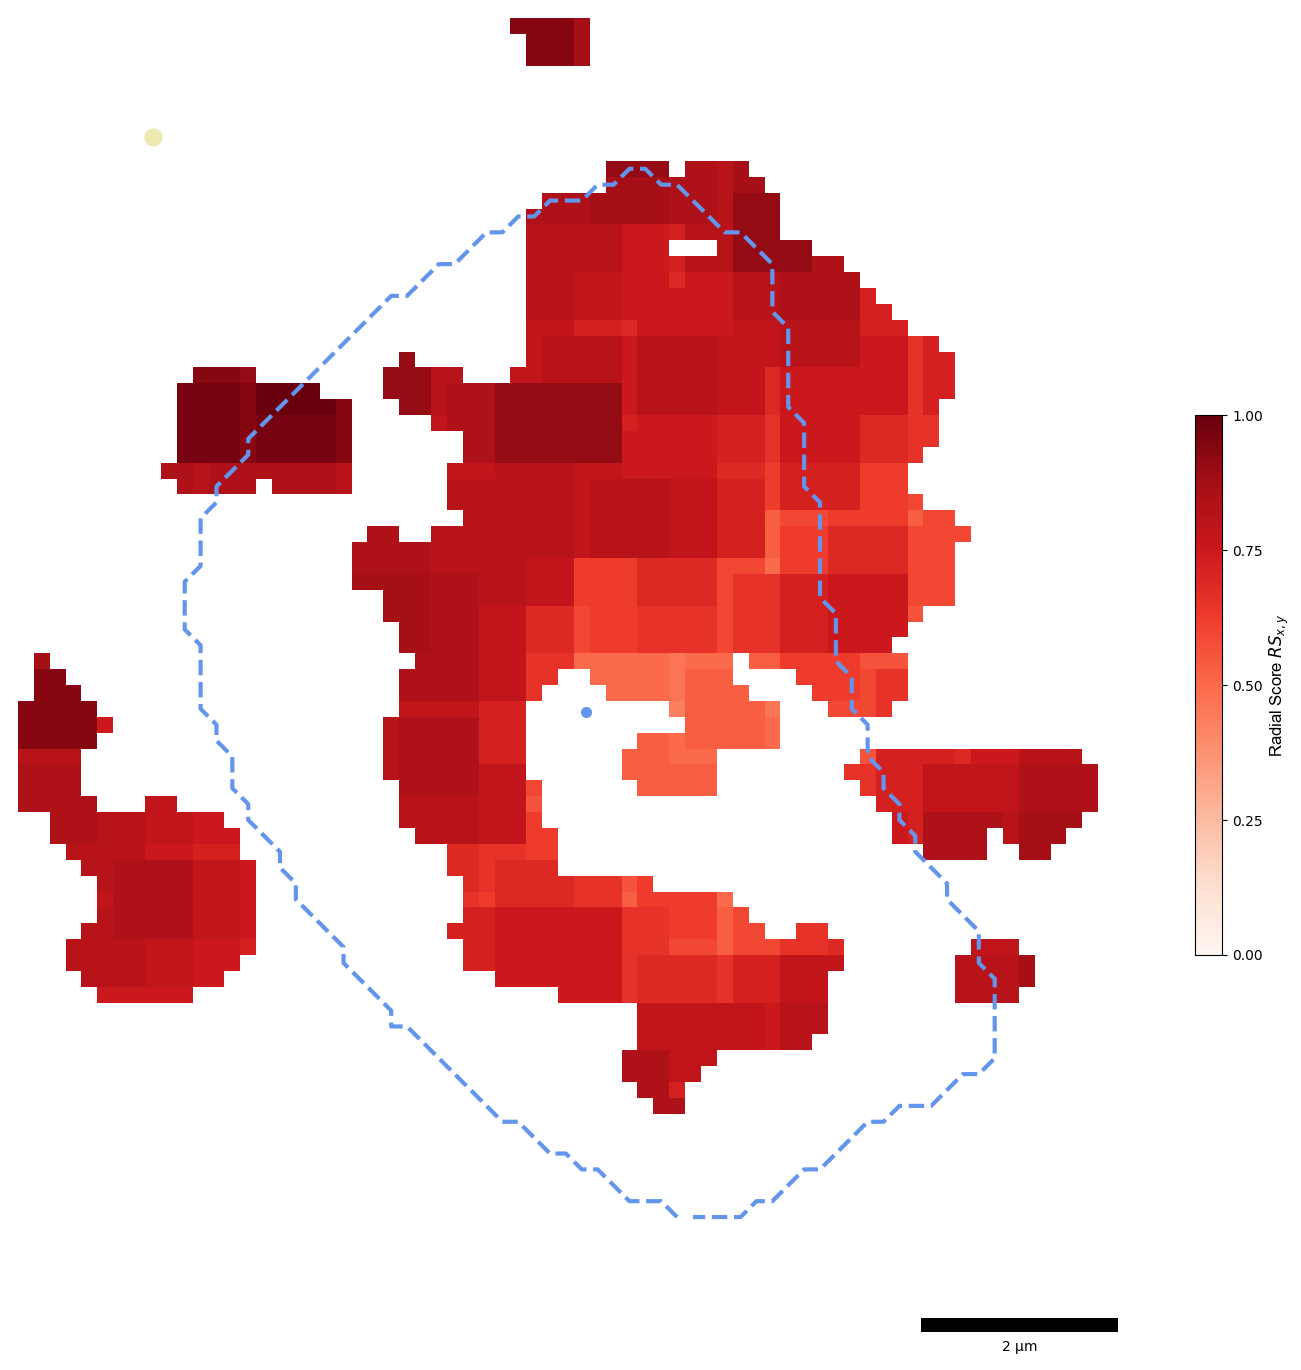

In [25]:
plot_radial(ResultsRow       = ResultsDF.loc[32], 
            overlay          = None, 
            normalize_bounds = [0,1],
            colorbar_label   = 'Radial Score $RS_{x,y}$',
            save             = "cell_radmap") 

ipykernel_launcher.py (20): You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("Reds").copy()
ipykernel_launcher.py (52): Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


Done.


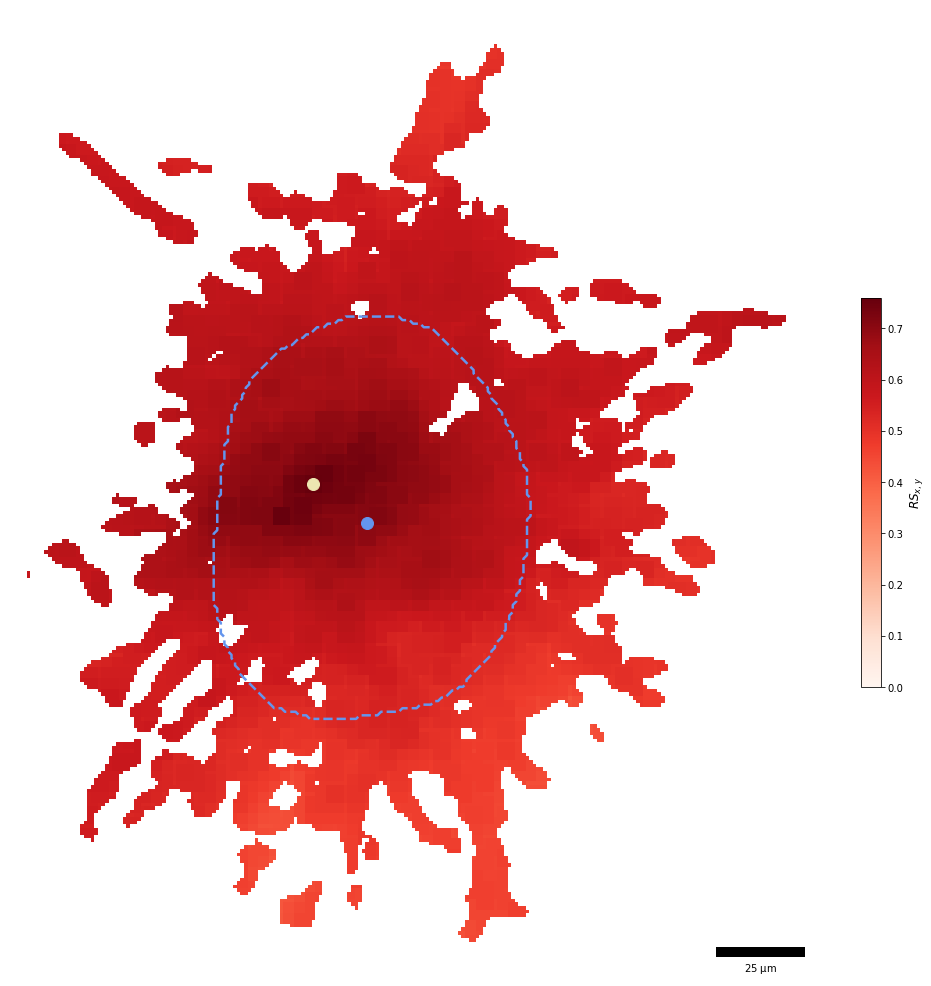

In [133]:
plot_radial(ResultsRow       = ResultsDF.loc[0], 
            overlay          = None, 
            normalize_bounds = [0,1],
            colorbar_label   = 'Radial Score $RS_{x,y}$',
            save             = "cell_radmap") 

# <font color='red'>Fibre Bundling</font>

##### <font color='red'>Sort by desired feature, choose cells and get new dataset</font>

In [35]:
temp = data.sort_values(by=['DCF:CV'])

In [37]:
#low_mid_high = [data.loc[144],data.loc[422],data.loc[163]]
low_mid_high = [temp.loc[temp.index[1]],temp.loc[temp.index[int(len(temp)/2)]],temp.loc[temp.index[-1]]]

for i in range(3):
    # Deconv
    fig,ax = plt.subplots(figsize=(15,15))
    plt.imshow(np.max(low_mid_high[i]['Patches'][1]) - low_mid_high[i]['Patches'][1],cmap='gray')
    plt.axis('off')
    #plt.savefig(".//CytoskeletonOrganisationExamples//bundling_deconv" + str(i) + ".png",format='png',transparent=True,bbox_inches='tight',dpi=500)
    plt.show()
    
    # Skel
    fig,ax = plt.subplots(figsize=(15,15))
    plt.imshow(1-low_mid_high[i]['Patches'][0],cmap='gray')
    plt.axis('off')
    #scalebar = ScaleBar(1,"um",color='k',box_alpha=0,dimension='si-length') 
    #ax.add_artist(scalebar)
    #plt.savefig(".//CytoskeletonOrganisationExamples//bundling_skel" + str(i) + ".png",format='png',transparent=True,bbox_inches='tight',dpi=500)
    plt.show()    
    
df = pd.concat(low_mid_high,axis=1).transpose()

# <font color='red'>Fibre Connectivity</font>

##### <font color='red'>Sort by desired feature, choose cells and get new dataset</font>

In [76]:
temp = data.sort_values(by=['SKNW:Ratio of Junction-to-junctions'])

In [77]:
low_mid_high = [temp.loc[482],temp.loc[485],temp.loc[353]]

for i in range(3):
    fig,ax = plt.subplots(figsize=(15,15))
    plt.imshow(np.max(low_mid_high[i]['Patches'][1]) - low_mid_high[i]['Patches'][1],cmap='gray')
    plt.axis('off')
    plt.savefig(".//CytoskeletonOrganisationExamples//connectivity_deconv" + str(i) + ".png",format='png',transparent=True,bbox_inches='tight',dpi=500)
    plt.show()
    
    plt.figure(figsize=(15,15))
    plt.imshow(low_mid_high[i]['Patches'][0],cmap='gray')
    #plt.savefig(".//CytoskeletonOrganisationExamples//connectivity_deconv" + str(i) + ".png",format='png',transparent=True,bbox_inches='tight',dpi=500)
    plt.show()
    
df = pd.concat(low_mid_high,axis=1).transpose()

ipykernel_launcher.py (122): Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


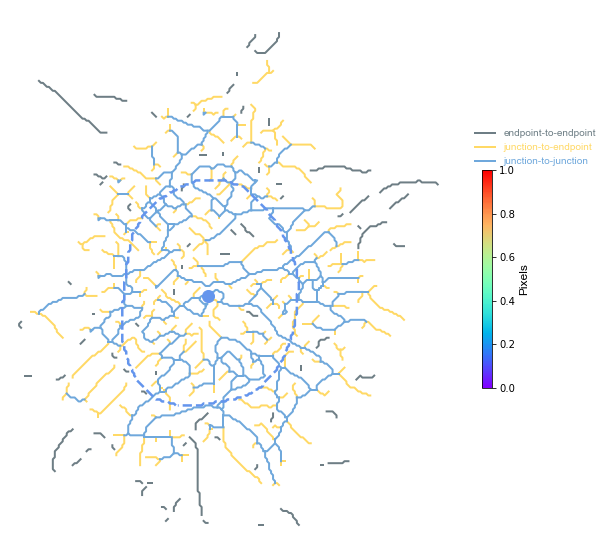

In [82]:
qual = 0 #low = 0, mid = 1, high = 2
graph_plotter(ResultsRow=subResultsDF.loc[qual],feat='branch-type',cmap=cm,normalize_bounds=[0,1],colorbar_label='Pixels',nodes=False,main_branch=False, overlay=False,scalebar=False,save="RA_connectivity" + str(qual))

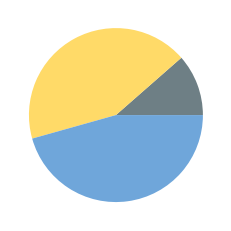

In [96]:
t = df[['SKNW:Ratio of Endpoint-to-endpoint (isolated branch)',
                        'SKNW:Ratio of Junction-to-endpoints',
                        'SKNW:Ratio of Junction-to-junctions']]

plt.figure()
plt.pie(np.array(t.loc[t.index[0]]),colors=['#6E7F85','#FFDA68','#6FA6DA'])
#plt.savefig(".//CytoskeletonOrganisationExamples//pie" + str(2) + ".png",format='png',transparent=True,bbox_inches='tight',dpi=500)
plt.show()

# <font color='red'>Fiber Morphology</font>

##### <font color='red'>Sort by desired feature, choose cells and get new dataset</font>

In [83]:
temp = data.sort_values(by=['SKNW:branch-distance mean'])

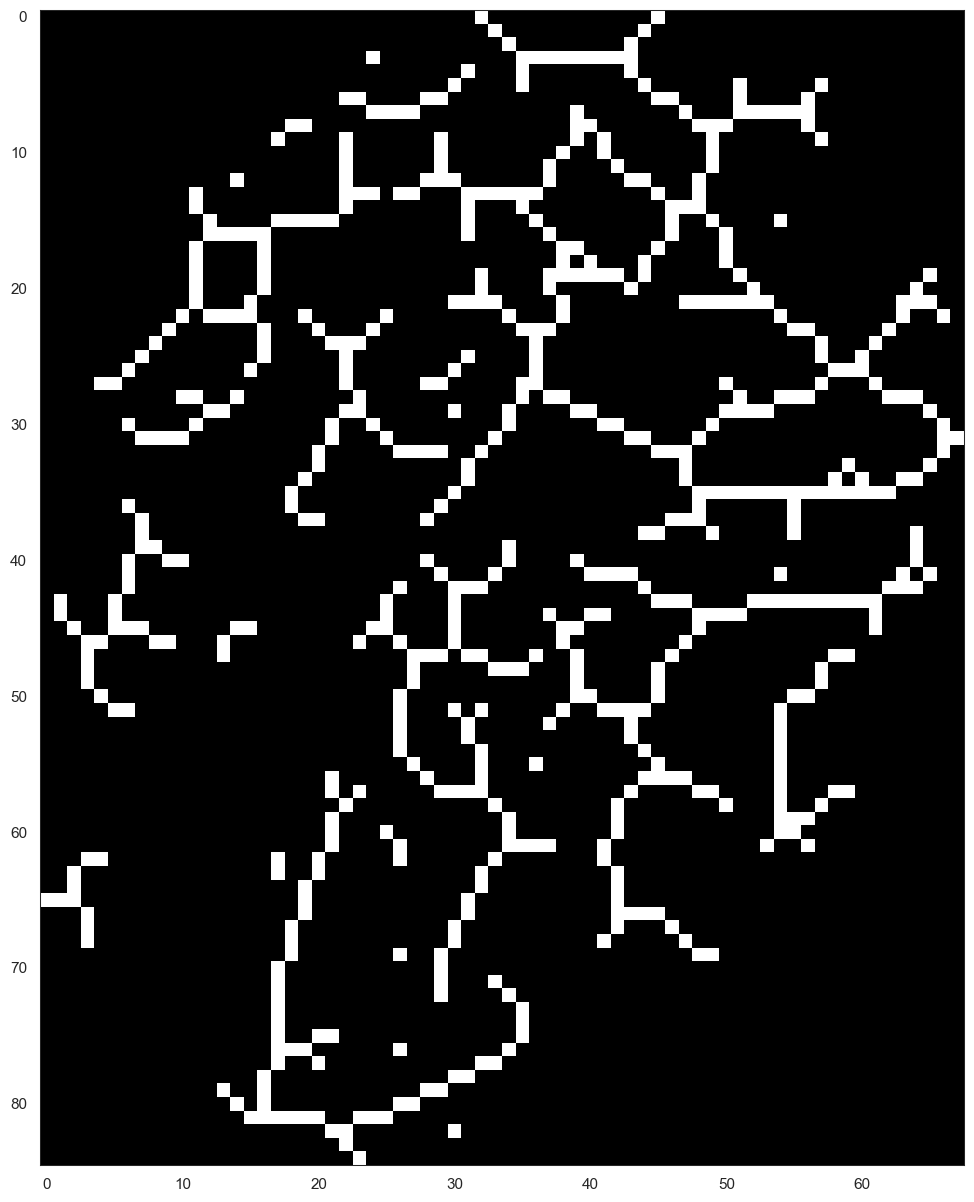

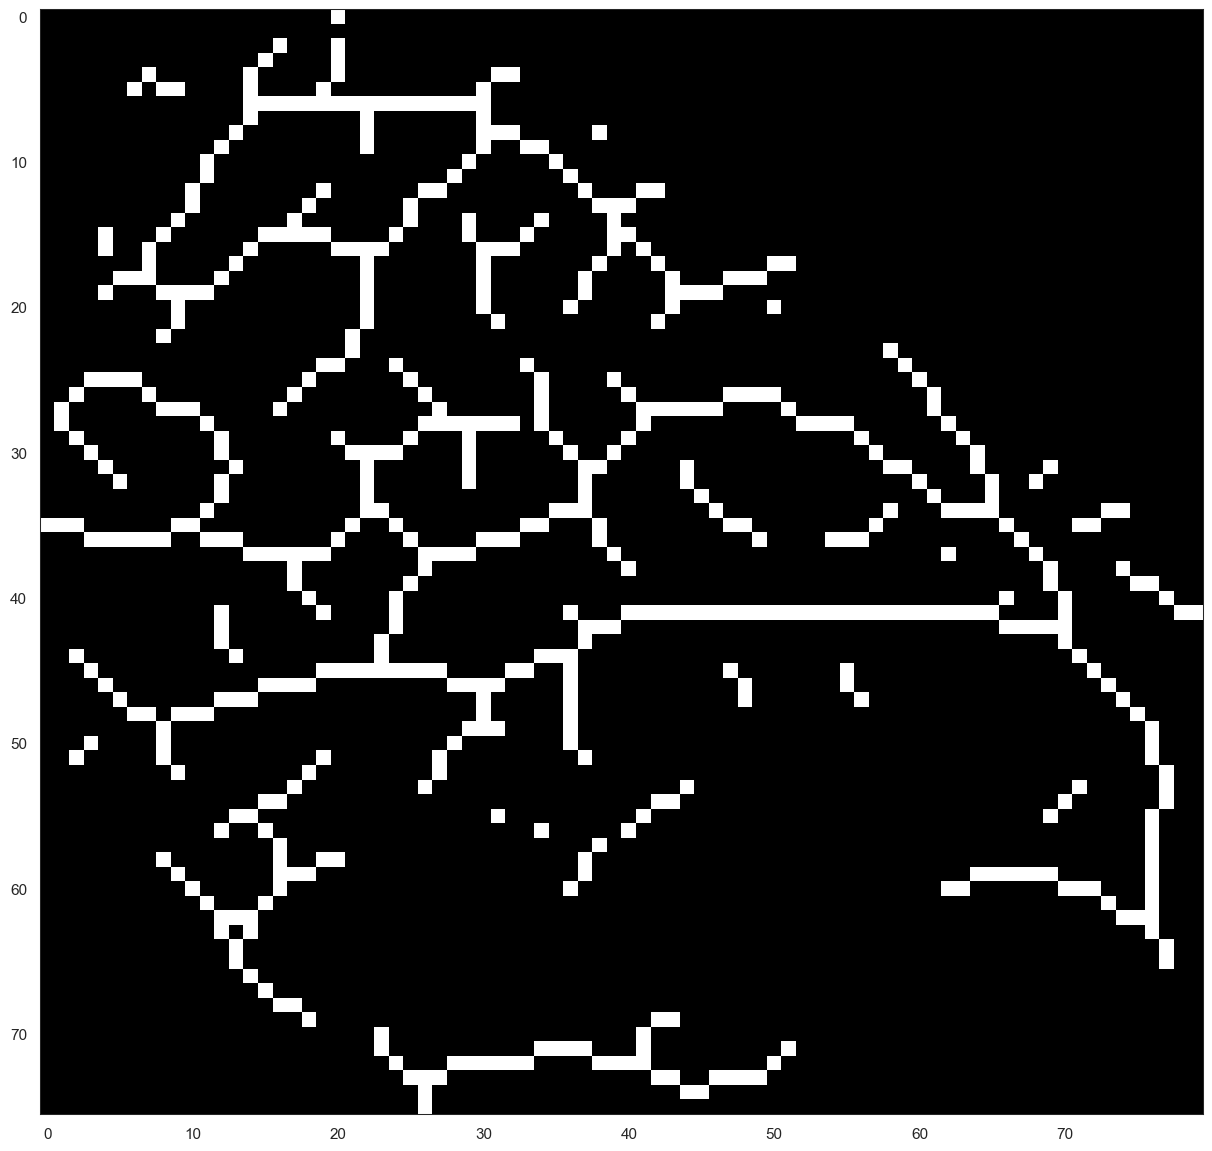

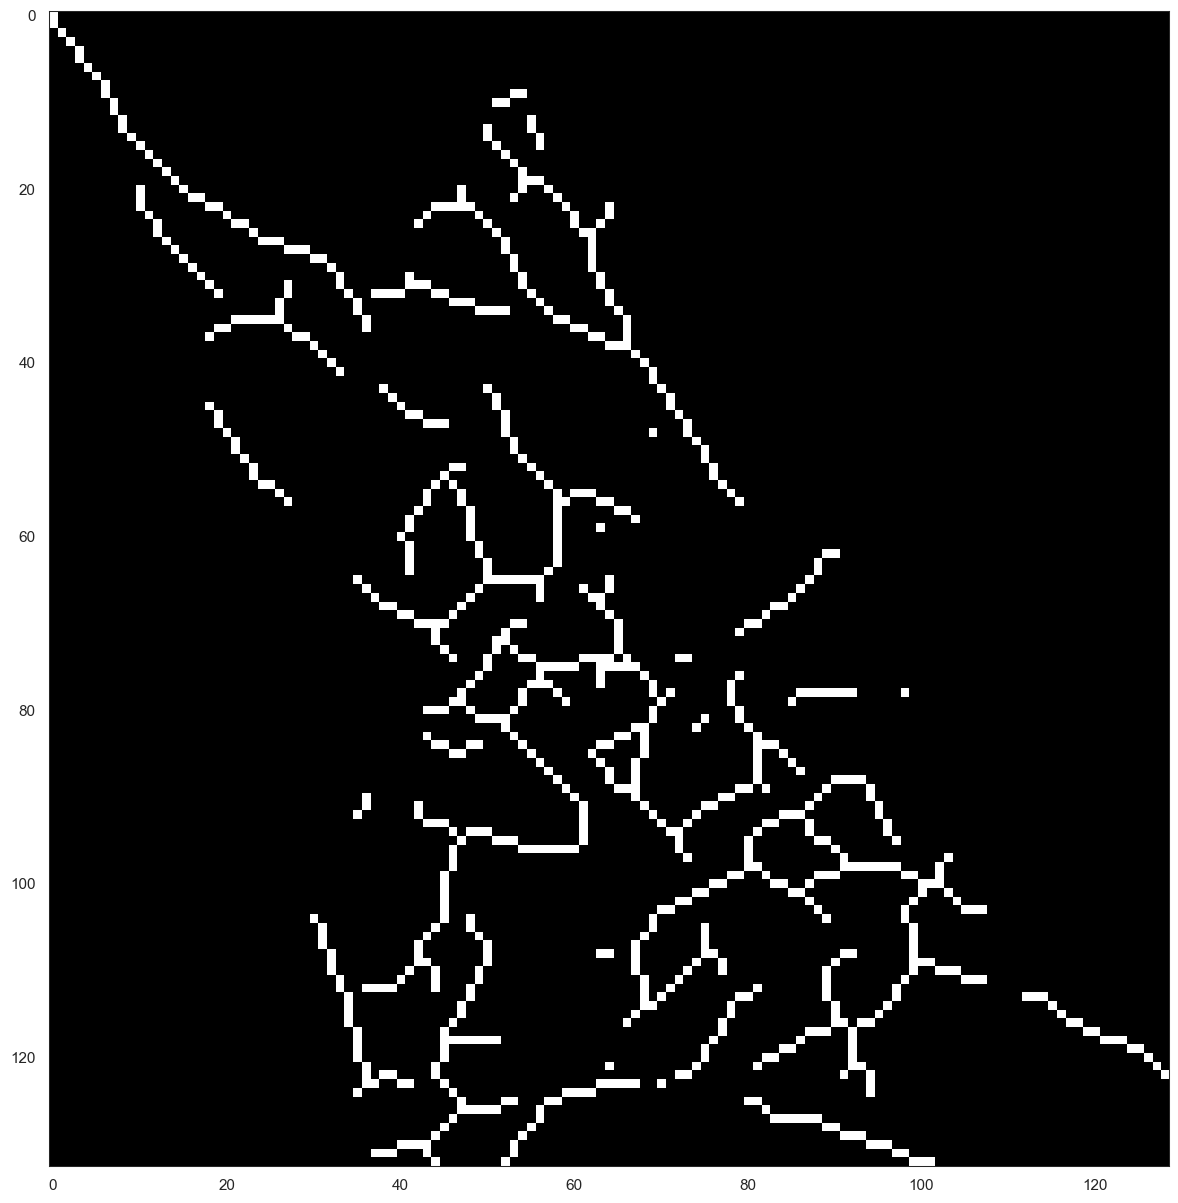

In [88]:
#low_mid_high = [data.loc[144],data.loc[422],data.loc[163]]
#low_mid_high = [temp.loc[362],temp.loc[501],temp.loc[1041]]
low_mid_high = [data.loc[362],data.loc[175],data.loc[1041]]

for i in range(3):
#     fig,ax = plt.subplots(figsize=(15,15))
#     plt.imshow(np.max(low_mid_high[i]['Patches'][1]) - low_mid_high[i]['Patches'][1],cmap='gray')
#     plt.axis('off')
#     plt.savefig(".//CytoskeletonOrganisationExamples//morphology_deconv" + str(i) + ".png",format='png',transparent=True,bbox_inches='tight',dpi=500)
#     plt.show()
    
    plt.figure(figsize=(15,15))
    plt.imshow(low_mid_high[i]['Patches'][0],cmap='gray')
    plt.show()
    
df = pd.concat(low_mid_high,axis=1).transpose()

##### <font color='red'>Sort by desired feature, choose cells and get new dataset</font>

In [82]:
# from scipy.stats import skew
ResultsDF['SKNW:Tortuosity'] = [np.ma.masked_invalid(summarize(Skeleton((el[0]).astype(float))).loc[np.where(summarize(Skeleton((el[0]).astype(float)))['branch-distance'] > 2)[0]]['branch-distance'] / summarize(Skeleton((el[0]).astype(float))).loc[np.where(summarize(Skeleton((el[0]).astype(float)))['branch-distance'] > 2)[0]]['euclidean-distance']) for el in data['Patches']]
ResultsDF['SKNW:Tortuosity mean'] = [np.mean(x) for x in ResultsDF['SKNW:Tortuosity']]
ResultsDF['SKNW:Tortuosity skewness'] = [skew(x) for x in ResultsDF['SKNW:Tortuosity']]
ResultsDF['SKNW:Tortuosity std_dev'] = [np.std(x) for x in ResultsDF['SKNW:Tortuosity']]
ResultsDF['SKNW:Tortuosity CV'] = ResultsDF['SKNW:Tortuosity std_dev'] / ResultsDF['SKNW:Tortuosity mean']

In [100]:
temp = data.sort_values(by=['SKNW:Tortuosity mean'])

In [72]:
#low_mid_high = [temp.loc[temp.index[1]],temp.loc[temp.index[2+int(len(temp)/2)]],temp.loc[temp.index[-1]]]
#low_mid_high = [data.loc[667],data.loc[699],data.loc[785]]
low_mid_high = [data.loc[701],data.loc[709],data.loc[1044]]

for i in range(3):
    plt.figure(figsize=(15,15))
    plt.imshow(low_mid_high[i]['Patches'][0],cmap='gray')
    plt.show()
    
df = pd.concat(low_mid_high,axis=1).transpose()

# <font color='red'>Final Description - Flowerplot</font>

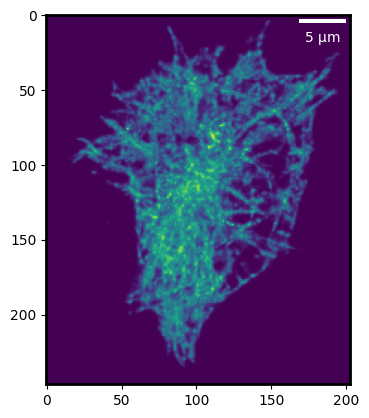

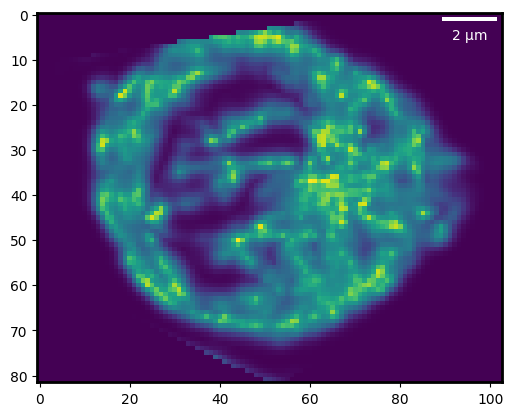

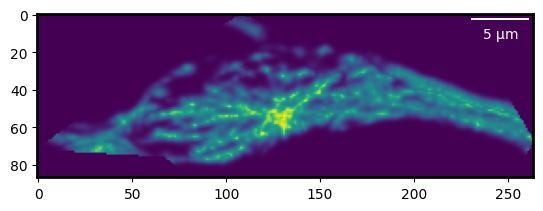

In [36]:
data['LSF:Radial Score 2'] = ResultsDF['LSF:Radial Score 2']

#low_mid_high = [data.loc[9],data.loc[939],data.loc[144],data.loc[146],data.loc[temp.index[940]]]
#low_mid_high = [data.loc[145],data.loc[144],data.loc[939]]
low_mid_high = [data.loc[950],data.loc[156],data.loc[161]]
df = pd.concat(low_mid_high,axis=1).transpose()

%matplotlib inline
for index,row in df.iterrows():
    
    fig,ax = plt.subplots()
    ax.imshow(row['Patches'][1])
    
    scalebar = ScaleBar(0.1612500,"um",color='w',box_alpha=0,dimension='si-length') 
    ax.add_artist(scalebar)
    #plt.savefig(folder + str("\\") + str(index) + ".pdf",format='pdf',transparent=True,bbox_inches='tight')
    plt.show()

In [41]:
def comp_radarplot(dataframe,feats,colors_bar,colors_m,markers,labels_mod,save):
    #df = dataframe[dataframe.columns[5:]]
    
    #LSF,DCF,DNF,SKNW,OTHERS,FULL = create_separate_DFs(ResultsDF)
    #cols = [x for x in FULL.columns if x.startswith("LSF2D") or x.startswith("LSF1D")]
    #feats = ['LSF2D:Angles mean','LSF2D:Distances to Centroid mean','LSF2D:Triangle Areas mean','LSF2D:Line Lengths mean','LSF2D:Angle Difference mean','LSF2D:Std. Angle Difference mean','LSF2D:Local Line Distance mean','LSF2D:Std. Local Line Distance mean','LSF1D:Number of Lines']
    
    df = dataframe[feats]
    data = copy.deepcopy(df)

    for col in data.columns:
        if df[col].max() == 0:
            data[col] = df[col]
        else:
            data[col] = df[col] / df[col].max()
    
    #data = df[feats] / df[feats].max()
    #data = pd.concat([data, ResultsDF['Cell desc.']],axis=1)
    angles = [n / len(feats) * 2 * np.pi for n in range(len(feats))]
    #diff  = np.mean(np.diff(angles))
    #angles = np.array(angles) + diff
    
    #angles += angles[:1]
    
    #HANGLES = np.linspace(0, 2 * np.pi)
    
    # Figure
    fig = plt.figure(figsize=(20, 20))
    ax  = fig.add_subplot(111, projection='polar')
    
    for idx, desc in enumerate(markers):
        values = data.iloc[idx].values.tolist()
        #values += values[:1]
        #ax.plot(angles, values,'--',marker= markers[idx],c=colors_m[idx],linewidth=1,markersize=10,label=desc,zorder = 8)
        ax.scatter(angles, values,s=200,marker=markers[idx],c=colors_m[idx],linewidth=1, label=desc,zorder=8)
        #ax.set_xticklabels(ax.get_xticks(), rotation = (angles[idx])*180/np.pi,size=10)
        #ax.scatter(angles, values, marker=markers[idx],s=160, c=colors[idx], zorder=10,label=desc)
        
        
        # ANNOTATIONS
#         values_annot = df.iloc[idx].values.tolist()
#         for angle, value, value_annot in zip(angles, values,values_annot):
#             #ax.annotate(str(round(value_annot,3)), xy=(angle, value), xytext=(15*np.sin(angle),15*np.cos(angle)), textcoords="offset pixels", fontsize=8, color="grey")
#             #ax.annotate(str(round(value_annot,3)), xy=(angle, value), xytext=(15*np.cos(angle),15*np.sin(angle)), textcoords="offset pixels", fontsize=8, color="grey")
#             ax.annotate(str(round(value_annot,3)), xy=(angle, value), xytext=(12,12), textcoords="offset pixels", fontsize=8, color="grey")
        
    
    
    ax.bar(angles, np.ones(len(angles)), width=0.62,bottom=0.0, color=colors_bar,alpha=0.2,edgecolor='k',linewidth=3)
    #ax.bar(angles, np.ones(len(angles)), width=0.5,bottom=0.0, fill=False,alpha=1,edgecolor='k')

    ax.legend(loc=(1, 0),frameon=False)
    ax.set_xticks(angles)
    ax.set_xticklabels(labels_mod, font="Arial")
    ax.tick_params(axis='x', which='major', labelsize=18)
    for tick in ax.xaxis.get_major_ticks():
        tick.set_pad(12)
    #ax.set_xticklabels([], size=10)
    
    # ANTES
    ax.set_yticklabels([])
    #ax.set_yticks([0.2,0.4,0.6,0.8,1])
    ax.set_yticks([])
    
    # DEPOIS
    #ax.set_yticklabels([])
    #ax.set_yticks([0.2,0.4,0.6,0.8,1])
    #ax.set_yticks([])
    
    ax.set_ylim(-0.09, 1.05)
    #ax.set_yticks(np.linspace(0, 1, 5))
    #ax.set_yticklabels((max_values * np.linspace(0, 1, 5)).astype(int))
    
    #ax.set_ylim(-0.09, 1.05) 
    plt.box(False)
    ax.grid(alpha=0.3)
    
    if save != False:
        plt.savefig(str(save) + ".pdf",format='pdf',transparent=True,bbox_inches='tight')
    
    #ax.fill_between([angles[0],angles[1]],[0,0],[1,1],color='r',zorder=20)
    
    fig.show()
    
    
print('comp_radarplot')

comp_radarplot


In [60]:
%matplotlib qt
# df WITH 5 CELLS
comp_radarplot(df,feats=['LSF1D:OOP',
                        'LSF1D:Circular Variance',
                         
                        'DCF:Skewness',
                        'DCF:CV',
                         
                        'LSF1D:Angle Difference mean',
                         
                        'LSF1D:Line Lengths mean',
                        'SKNW:branch-distance mean',
                        'SKNW:Tortuosity mean',
                         
                        'LSF1D:N over A',
                        'SKNW:euclidean-distance mean',
                         
                        'SKNW:Ratio of Endpoint-to-endpoint (isolated branch)',
                        'SKNW:Ratio of Junction-to-endpoints',
                        'SKNW:Ratio of Junction-to-junctions',
                         
                        'DCF:AAI',
                        'LSF1D:Number of Lines',
                        'SKNW:Number of Branches',
                         
                        'SKNW:Fractal Dimension (Rot)',
                         
                        'LSF1D:RS',
                        'LSF1D:RS NucCent Distance',
                         
                        'OTHERS:Cytoskeleton-Nuclei Centroid Distance',
                        'OTHERS:Weighted Cytoskeleton-Nuclei Centroid Distance',
                        'OTHERS:Area Ratio (Cyto vs. Nucl)',
                        'LSF1D:Distances to Centroid mean'],
               colors_bar= ["#9999C3",
                            "#9999C3",
                            
                            "#C4CB79",
                            "#C4CB79",
                            
                            "#64B6AC",
                            
                            "#C0E6DE",
                            "#C0E6DE",
                            "#C0E6DE",
                             
                            "#faa330",
                            "#faa330",
                            
                            "#A4031F",
                            "#A4031F",
                            "#A4031F",
                            
                            "#E88873",
                            "#E88873",
                            "#E88873",
                            
                            "#6153CC",
                            
                            "#826251",
                            "#826251",
                            
                            "#F3D34A",
                            "#F3D34A",
                            "#F3D34A",
                            "#F3D34A"],
               colors_m = ["r","b","g","m","c"],
               markers = ["s",
                          "X",
                          "D",
                          "o",
                          "p"],
               labels_mod=[r"$OOP$",
                          r"$CVar$",
                          
                          r"$Skew$",
                          r"$CV$", 
                           
                          r"$\bar{\theta}^5$",
                           
                          r"$\bar{L}^l$",
                          r"$\bar{L}^E$",
                          r"$\bar{T}$",
                           
                          r"$N_l/A_C$",
                          r"$\bar{D}^V$",
                           
                          r"$R_{(e,e)}$",
                          r"$R_{(j,e)}$",
                          r"$R_{(j,j)}$",
                           
                          r"$AMI$",
                          r"$N_l$",
                          r"$N_E$",
                           
                          r"$FD$",

                          r"$RS$",
                          r"$D_{RS}$",
                          
                          r"$D_{CN}$",
                          r"$D^W_{CN}$",
                          r"$A_N/A_C$",
                          r"$D_N$"],
              save="flowerplot")

In [42]:
%matplotlib qt
# df WITH 3 CELLS
comp_radarplot(df,feats=['LSF1D:OOP (LinReg)',
                        
                         
                        'DCF:Skewness',
                        
                         
                        'LSF1D:Angle Difference mean',
                         
                        
                        'SKNW:branch-distance mean',
                        
                         
                        'LSF1D:N over A (LinReg)',
                        
                         
                        'SKNW:Ratio of Endpoint-to-endpoint (isolated branch)',
                        
                         
                        'SKNW:Number of Branches',
                         
                        'SKNW:Fractal Dimension (Rot)',
                         
                        'LSF:Radial Score 2',
                         
                        'OTHERS:Weighted Cytoskeleton-Nuclei Centroid Distance'],
               colors_bar= ["#9999C3",
                            
                            
                            "#C4CB79",
                            
                            
                            "#64B6AC",
                            
                            
                            "#C0E6DE",
                            
                             
                            "#faa330",
                            
                            
                            "#A4031F",
                            
                            
                            "#E88873",
                            
                            "#6153CC",
                            
                            "#826251",
                            
                            "#F3D34A"],
               colors_m = ["r","b","g"],
               markers = ["s",
                          "X",
                          "D"],
               labels_mod=[r"$OOP$",
                          
                          
                          r"$Skew$",
                           
                           
                          r"$\bar{\theta}^5$",
                           
                          
                          r"$\bar{L}^E$",
                          
                           
                          r"$N_l/A_C$",
                          
                           
                          r"$R_{(e,e)}$",
                          
                           
                          r"$N_E$",
                           
                          r"$FD$",

                          r"$RS$",
                          
                          r"$D^W_{CN}$"
                          ],
              save=folder + "\\flowerplot_paper_pdf")

In [44]:
df[['LSF1D:OOP (LinReg)',
                        
                         
                        'DCF:Skewness',
                        
                         
                        'LSF1D:Angle Difference mean',
                         
                        
                        'SKNW:branch-distance (scaled) mean',
                        
                         
                        'LSF1D:N over A (LinReg)',
                        
                         
                        'SKNW:Ratio of Endpoint-to-endpoint (isolated branch)',
                        
                         
                        'SKNW:Number of Branches',
                         
                        'SKNW:Fractal Dimension (Rot)',
                         
                        'LSF:Radial Score 2',
                         
                        'OTHERS:Weighted Cytoskeleton-Nuclei Centroid Distance']]
               

LSF1D:OOP (LinReg) DCF:Skewness LSF1D:Angle Difference mean  \
950           0.077904        0.624                   55.661441   
156           0.067024        0.435                    51.41629   
161           0.169672        0.662                   38.077511   

    SKNW:branch-distance (scaled) mean LSF1D:N over A (LinReg)  \
950                            1.01352                1.589957   
156                           1.181298                1.077261   
161                           1.276519                0.975662   

    SKNW:Ratio of Endpoint-to-endpoint (isolated branch)  \
950                                           0.044709     
156                                           0.082569     
161                                           0.084848     

    SKNW:Number of Branches SKNW:Fractal Dimension (Rot) LSF:Radial Score 2  \
950                     671                     1.526542              0.474   
156                     109                     1.462684              0.477   
161                     165                     1.374423              0.564   

    OTHERS:Weighted Cytoskeleton-Nuclei Centroid Distance  
950                                          11.489502     
156                                           7.687889     
161                                          37.928946

# <font color='red'>Bar Plots</font>

In [12]:
import statannot
def plot_barplot_paper(data,f,errorbar):
    # SHOULD BE CHANGED
    if type(f) != str:
        cols     = [x for x in data.columns if x.startswith("LSF2D") or x.startswith("LSF1D") or x.startswith("DCF") or x.startswith("DNF") or x.startswith("SKNW") or x.startswith("OTHERS")]
    else:
        cols     = [f]
    #cols     = [x for x in data.columns if x.startswith("LSF2D") or x.startswith("LSF1D") or x.startswith("DCF") or x.startswith("DNF") or x.startswith("SKNW") or x.startswith("OTHERS")]
    #feats_1D = [x for x in df.columns if x.startswith("LSF2D")]
    #feats    = [x for x in df.columns if x.startswith("LSF1D") or x.startswith("DCF") or x.startswith("DNF") or x.startswith("SKNW") or x.startswith("OTHERS")]

    # 4
    colors   = ["k","#737373",'#bfbfbf']
    labels   = ['Cell 1', 'Cell 2','Cell 3']
     

    # 6
    #     colors   = ["#2ECC71","#DECF77","#5AB7BD","#FFA500","#E74C3C","#BC544B",]
    #     labels   = ['WT','No transfection','Mock','Dup41_46','Del38_46','Mut394']
    #     pairs    = [(('WT', 'No transfection')),(('WT', 'Mock')),(('WT', 'Dup41_46')), (('WT', 'Del38_46')), (('WT', 'Mut394'))] 
    


    for f in cols:
        try:
            data[f] = data[f].astype(float)
        except: 
            continue

        #print(data.groupby(['Label']).describe()[[(f,'mean'),(f,'std')]])

        global f_
        f_ = f[:-5]


        fig,ax = plt.subplots(figsize=(4,3))
#         sns.set_theme(style="white")
        ax.spines['bottom'].set_zorder(20)
        ax.spines['left'].set_zorder(20)
        # 4

#             for index,row in df.iterrows():
#                 ResultsDF.loc[497]['LSF2D:Angles']

        #sns.barplot(x=labels, y=f, data=data,yerr=data['SKNW:branch-distance std_dev'],capsize=.1,errorbar='se',edgecolor='k',fill=True,palette=colors,linewidth=2)
        #sns.barplot(x=labels, y=f, data=data,capsize=.1,yerr=data['SKNW:branch-distance std_dev']/data['SKNW:Number of Branches'],errorbar='se',edgecolor=colors,fill=False,palette=colors,linewidth=2)

        

        # WITH ERRORBARS
        # tentativas
        #sns.barplot(x=labels, y=f, data=data,capsize=.1, yerr=df[f_ + ' std_dev'],edgecolor=colors,fill=False,palette=colors,linewidth=3,zorder=5)
        #plt.rcParams.update({'errorbar.capsize': 3})
        ####sns.barplot(x=labels, y=f, data=data,capsize=2,yerr=data['SKNW:branch-distance (scaled) std_dev'],edgecolor=colors,fill=False,palette=colors,linewidth=3)

        # este
        if errorbar == True:
            sns.barplot(x=labels, y=f, data=data,capsize=.1, edgecolor=colors,fill=False,palette=colors,linewidth=3,zorder=5,errorbar=None)
            for k in range(3):
                plt.errorbar(x=labels[k], y=df[f][df.index[k]],yerr=df[f_ + ' std_dev'][df.index[k]],capsize=6, linewidth=3,zorder=5,linestyle='',ecolor=colors[k],capthick=3)
            sns.barplot(x=labels, y=f, data=data,fill=True,palette=['w','w','w'],edgecolor=colors,linewidth=3,zorder=10,errorbar=None)


    
        # W/O ERRORBARS
        if errorbar == False:
            sns.barplot(x=labels, y=f, data=data,capsize=2,edgecolor=colors,fill=False,palette=colors,linewidth=3)


        # ORIGINAL
        #sns.barplot(x=labels, y=f, data=data,capsize=.1,errorbar=('ci', 95),edgecolor='k',fill=True,palette=colors,linewidth=2)


        #cis = [container.get_yerr()[1]/2 for container in containers]

        ax.set_xticks(ax.get_xticks(),labels,font='arial',color='k',fontsize=14)
        ax.set_yticks(ax.get_yticks(),font='arial',color='k',fontsize=18,visible=False)




        ax.set_xlabel(None)
        plt.rcParams['axes.linewidth'] = 2 
        #ax.tick_params(axis='both',which='both',length=0)
        ax.tick_params(left=True, bottom=False)
        
        
        sns.despine(right=True)
        ax.spines['left'].set_linewidth(2)
        #plt.grid(alpha=0.2,axis='y')


        # COMMENT TO CHECK
#             for bar, err in zip(ax.patches, data['LSF1D:Distances to Centroid std_dev']):
#                 bar_x = bar.get_x()
#                 bar_width = bar.get_width()
#                 bar_height = bar.get_height()
#                 plt.errorbar(
#                     bar_x + bar_width / 2,
#                     bar_height,
#                     yerr=err,
#                     color='black',  # Adjust color as needed
#                     linewidth=2,
#                     capsize=5, # Adjust capsize value as needed
#                     markeredgewidth=2
#                 )


        plt.savefig(folder + "\\fig2_" + str(f.split(':')[0]) + "-"  + str(f.split(':')[1]) + ".pdf",format='pdf',transparent=True,bbox_inches='tight')

        plt.show()

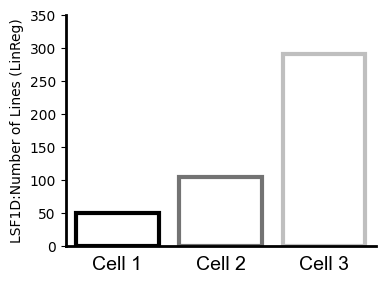

In [13]:
plot_barplot_paper(data     = df,
                   f        = f,
                   errorbar = errorbar)

## Values from plot

### ORIENTATION

In [4]:
# ORIENTATION
df = pd.concat([data.loc[315],data.loc[471],data.loc[30]],axis=1).transpose()
df['LSF1D:OOP']

315    0.015621
471    0.151864
30     0.516236
Name: LSF1D:OOP, dtype: object

In [7]:
# ORIENTATION
df = pd.concat([data.loc[315],data.loc[471],data.loc[488]],axis=1).transpose()
f = 'LSF1D:OOP (LinReg)'
errorbar = False
df[f]

315    0.019108
471    0.139051
488    0.475737
Name: LSF1D:OOP (LinReg), dtype: object

### MORPHOLOGY

In [10]:
# MORPHOLOGY
df = pd.concat([data.loc[362],data.loc[175],data.loc[1041]],axis=1).transpose()
df[['SKNW:branch-distance mean','SKNW:branch-distance std_dev']]

SKNW:branch-distance mean SKNW:branch-distance std_dev
362                   5.000927                     3.725866
175                   6.465018                      5.64472
1041                  8.604081                     7.776142

In [9]:
df = pd.concat([data.loc[362],data.loc[175],data.loc[1041]],axis=1).transpose()
df[['SKNW:branch-distance (scaled) mean','SKNW:branch-distance (scaled) std_dev']]

SKNW:branch-distance (scaled) mean SKNW:branch-distance (scaled) std_dev
362                            0.848072                              0.641584
175                            1.090557                              0.915686
1041                           1.254075                              1.203489

### COMPACTNESS

In [9]:
# COMPACTNESS
df = pd.concat([data.loc[1025],data.loc[303],data.loc[958]],axis=1).transpose()
df['LSF1D:N over A']
# 1025, 936, 958

1025    0.012162
303     0.021869
958     0.032456
Name: LSF1D:N over A, dtype: object

In [13]:
df = pd.concat([data.loc[1025],data.loc[936],data.loc[801]],axis=1).transpose()
f = 'LSF1D:N over A (LinReg)'
errorbar = False
df[f]

1025    0.420912
936     1.539134
801     2.038763
Name: LSF1D:N over A (LinReg), dtype: object

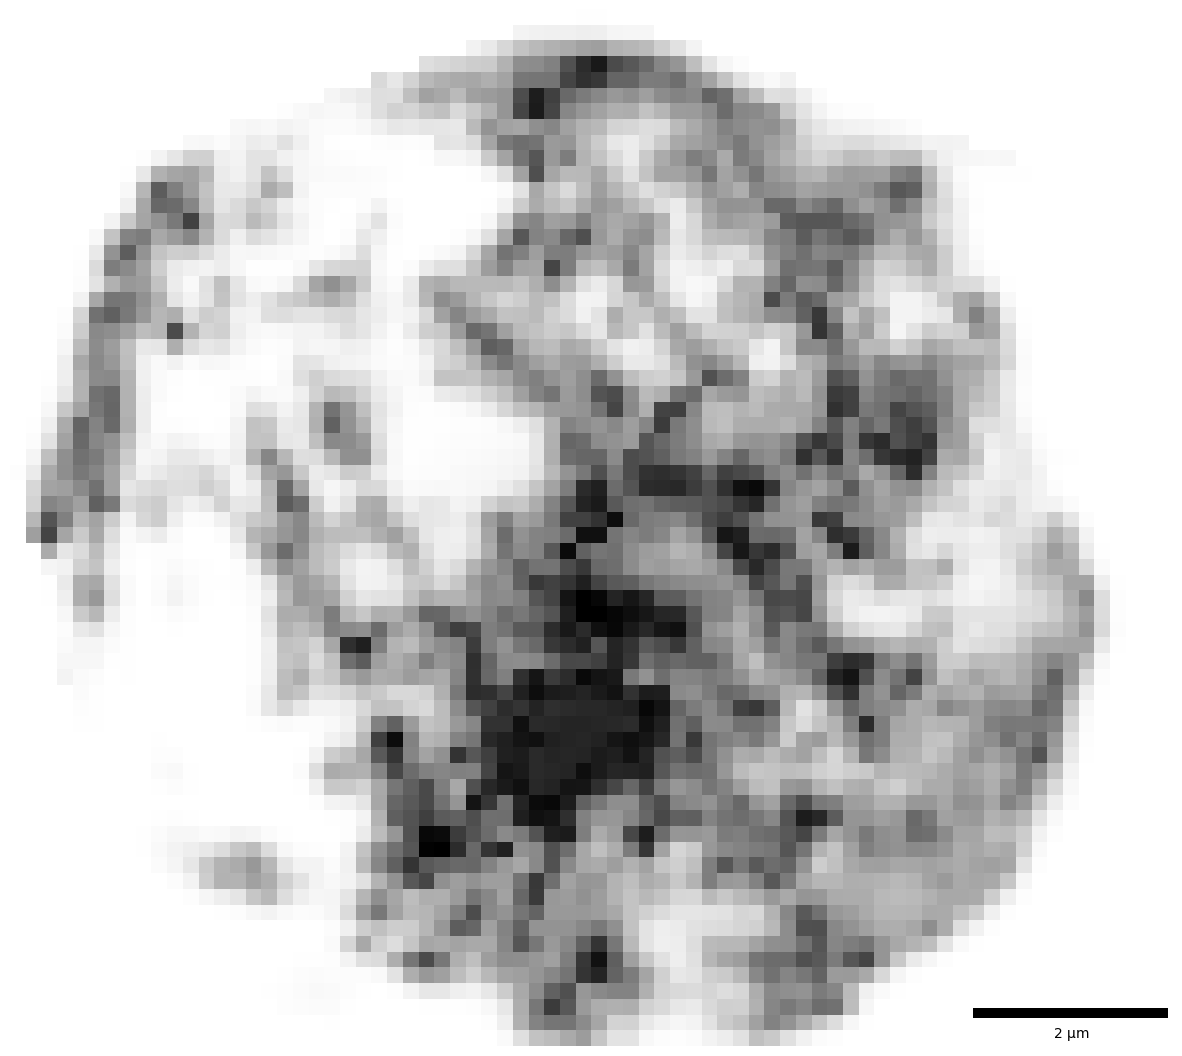

In [6]:
fig,ax = plt.subplots(figsize=(15,15))
plt.imshow(np.max(ResultsDF.loc[801]['Patches'][1]) - ResultsDF.loc[801]['Patches'][1],cmap='gray')
plt.axis('off')

scalebar = ScaleBar(0.1612500,"um",color='k',box_alpha=0,dimension='si-length',location='lower right') 
ax.add_artist(scalebar)   
plt.savefig(folder + str("\\") + str('compactness_deconv2') + ".pdf",format='pdf',transparent=True,bbox_inches='tight')

### QUANTITY

In [22]:
# QUANTITY
df = pd.concat([data.loc[354],data.loc[367],data.loc[72]],axis=1).transpose()
df['LSF1D:Number of Lines']

354     71
367    142
72     348
Name: LSF1D:Number of Lines, dtype: object

In [11]:
# QUANTITY
df = pd.concat([data.loc[354],data.loc[367],data.loc[72]],axis=1).transpose()
f = 'LSF1D:Number of Lines (LinReg)'
errorbar = False
df[f]

354     50
367    105
72     292
Name: LSF1D:Number of Lines (LinReg), dtype: object

### RADIALITY

In [156]:
# RADIALITY
df = pd.concat([data.loc[497],data.loc[365],data.loc[354### QUANTITY]],axis=1).transpose()
df[['LSF1D:Angles mean','LSF1D:Angles std_dev']]

LSF1D:Angles mean LSF1D:Angles std_dev
497         31.500638            24.435815
365          45.99946            26.428034
354         55.654732            27.641593

In [15]:
df = pd.concat([data.loc[497],data.loc[365],data.loc[333]],axis=1).transpose()
f = 'LSF1D:Alphas (LinReg) mean'
errorbar = True
df[['LSF1D:Alphas (LinReg) mean','LSF1D:Alphas (LinReg) std_dev']]

LSF1D:Alphas (LinReg) mean LSF1D:Alphas (LinReg) std_dev
497                  31.561843                     24.714994
365                  46.117808                     25.524485
333                  55.033646                     27.033518

### CYTO-NUC

In [16]:
# CYTO-NUC INTERACTION
df = pd.concat([data.loc[31],data.loc[165],data.loc[713]],axis=1).transpose()
df[['LSF1D:Distances to Centroid mean','LSF1D:Distances to Centroid std_dev']]

LSF1D:Distances to Centroid mean LSF1D:Distances to Centroid std_dev
31                         19.483444                            8.049438
165                        47.929039                           32.433773
713                        98.841386                           47.304199

In [17]:
# CYTO-NUC INTERACTION
df = pd.concat([data.loc[31],data.loc[165],data.loc[713]],axis=1).transpose()
f = 'LSF1D:Distances to Centroid (scaled) mean'
errorbar = True
df[['LSF1D:Distances to Centroid (scaled) mean','LSF1D:Distances to Centroid (scaled) std_dev']]

LSF1D:Distances to Centroid (scaled) mean  \
31                                   3.141705   
165                                  7.728558   
713                                 15.938173   

    LSF1D:Distances to Centroid (scaled) std_dev  
31                                      1.297972  
165                                     5.229946  
713                                     7.627802

In [32]:
# CYTO-NUC INTERACTION
df = pd.concat([data.loc[31],data.loc[165],data.loc[713]],axis=1).transpose()
f = 'LSF1D:Distances to Centroid (LinReg) (scaled) mean'
errorbar = True
df[['LSF1D:Distances to Centroid (LinReg) (scaled) mean','LSF1D:Distances to Centroid (LinReg) (scaled) std_dev']]

LSF1D:Distances to Centroid (LinReg) (scaled) mean  \
31                                            3.190943   
165                                           6.853056   
713                                          15.196813   

    LSF1D:Distances to Centroid (LinReg) (scaled) std_dev  
31                                            1.488792     
165                                           4.274804     
713                                           7.227587

-------------------------------------------------------------------------------------------------------------

In [33]:
ResultsDF.to_pickle(folder + "//ResultsDF_5_nov_23.pkl") 
ResultsDF.to_excel(folder + "//ResultsDF_5_nov_23.xlsx")